In [1]:
import os
import struct
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.export.export_output import PredictOutput

tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!rm -rf logdir-small

In [3]:
#load MNIST data from files

fname_img_train = os.path.join(os.getcwd(), 'MNIST-data/train-images.idx3-ubyte')
fname_lbl_train = os.path.join(os.getcwd(), 'MNIST-data/train-labels.idx1-ubyte')

fname_img_eval = os.path.join(os.getcwd(), 'MNIST-data/t10k-images.idx3-ubyte')
fname_lbl_eval = os.path.join(os.getcwd(), 'MNIST-data/t10k-labels.idx1-ubyte')


with open(fname_lbl_train, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.int8).astype(dtype=np.int32)
    
with open(fname_lbl_eval, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    eval_labels = np.fromfile(flbl, dtype=np.int8).astype(dtype=np.int32)
    
with open(fname_img_train, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_data = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols, 1).astype(dtype=np.float32)
    train_data = np.true_divide(train_data, 256)
    
with open(fname_img_eval, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    eval_data = np.fromfile(fimg, dtype=np.uint8).reshape(len(eval_labels), rows, cols, 1).astype(dtype=np.float32)
    eval_data = np.true_divide(eval_data, 256)
    
print('train_data shape:   ' + str(train_data.shape))
print('train_labels shape: ' + str(train_labels.shape))

print('eval_data shape:    ' + str(eval_data.shape))
print('eval_labels shape:  ' + str(eval_labels.shape))

train_data shape:   (60000, 28, 28, 1)
train_labels shape: (60000,)
eval_data shape:    (10000, 28, 28, 1)
eval_labels shape:  (10000,)


In [4]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=features["x"],
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    export_outputs={"SIGNATURE_NAME": PredictOutput({
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="final_result")
    })}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./logdir-small")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4d2ceddc50>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './logdir', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [6]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "final_result"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [7]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=50,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./logdir/model.ckpt.
INFO:tensorflow:probabilities = [[0.09167054 0.11550101 0.12592621 0.08964604 0.10554254 0.08973829
  0.08359547 0.1007318  0.10916951 0.08847861]
 [0.09654735 0.0974607  0.10905635 0.09719849 0.09937239 0.10463867
  0.1007055  0.10193887 0.10009699 0.09298471]
 [0.09681891 0.11680344 0.1107169  0.0907321  0.09950896 0.08816329
  0.07989134 0.10950025 0.10629955 0.10156523]
 [0.08861032 0.1043782  0.09602284 0.10086949 0.11500955 0.08856355
  0.10736222 0.09363405 0.11384567 0.09170409]
 [0.09726018 0.10963957 0.11721224 0.09242178 0.09566294 0.09120642
  0.10016283 0.10209581 0.09565364 0.09868459]
 [0.10636273 0.11470391 0.09739807 0.0856234  0.09907709 0.0988296
  0.09897026 0.1105059

INFO:tensorflow:global_step/sec: 128.852
INFO:tensorflow:probabilities = [[0.0900482  0.09891827 0.10197644 0.10457862 0.09590989 0.09683663
  0.09972762 0.11789951 0.09958536 0.09451938]
 [0.10504142 0.10911738 0.11527602 0.08979435 0.09971467 0.09211586
  0.0878272  0.10737211 0.1053533  0.08838767]
 [0.09369858 0.09999173 0.10363632 0.09574414 0.10764311 0.09389036
  0.09428487 0.11033755 0.11021897 0.09055436]
 [0.10340057 0.1079267  0.10395484 0.10331662 0.11083703 0.09228861
  0.0901618  0.08778401 0.09877561 0.10155423]
 [0.11093728 0.103282   0.09822584 0.10238771 0.10117231 0.08391597
  0.09328378 0.11183228 0.09082562 0.10413717]
 [0.08981109 0.09893514 0.10592971 0.09747079 0.09873158 0.08473939
  0.09835379 0.11779352 0.11412586 0.09410923]
 [0.10126456 0.10877699 0.11156479 0.09208169 0.10150599 0.09956127
  0.09441466 0.09593683 0.1056411  0.08925209]
 [0.09419752 0.09460785 0.09366003 0.09982718 0.10510785 0.08932374
  0.10511012 0.10881548 0.10107645 0.10827382]
 [0.105

INFO:tensorflow:global_step/sec: 152.492
INFO:tensorflow:probabilities = [[0.11181413 0.09235643 0.11380398 0.09984895 0.09059943 0.08575429
  0.10394973 0.09965273 0.10509256 0.09712787]
 [0.09952589 0.10824271 0.10491976 0.10006779 0.10226636 0.09226466
  0.09650885 0.10511571 0.10126089 0.08982734]
 [0.09183405 0.10918364 0.10154971 0.10144454 0.10441825 0.09219661
  0.09525594 0.09671713 0.10882099 0.09857914]
 [0.09450448 0.08969773 0.11316907 0.0998632  0.11167856 0.09096377
  0.10452453 0.09054179 0.10754555 0.09751125]
 [0.10173356 0.09998111 0.11155295 0.08266661 0.10308112 0.0825955
  0.10455894 0.1158873  0.106563   0.09137996]
 [0.09399208 0.10318533 0.10857312 0.08761118 0.10045007 0.10110813
  0.10149187 0.1038966  0.10613777 0.09355386]
 [0.10153415 0.10617772 0.10630335 0.09047922 0.09808911 0.09312946
  0.09764368 0.1035622  0.10545359 0.09762758]
 [0.11098372 0.09466501 0.09472516 0.09304588 0.10366634 0.08974011
  0.11124708 0.10425159 0.10274492 0.09493012]
 [0.0928

INFO:tensorflow:global_step/sec: 155.003
INFO:tensorflow:probabilities = [[0.09826857 0.08388808 0.10495074 0.10364465 0.09945324 0.10496566
  0.10547163 0.10085694 0.10535277 0.09314771]
 [0.08611609 0.10378461 0.11357205 0.09866817 0.09401759 0.09599198
  0.10028587 0.10591998 0.10107125 0.10057236]
 [0.09806698 0.09671284 0.10724787 0.1018592  0.09800813 0.0954093
  0.09368163 0.10442139 0.10771168 0.09688102]
 [0.10472115 0.09090719 0.11203609 0.10112829 0.0951921  0.08936103
  0.09681732 0.09310829 0.1037102  0.11301836]
 [0.09361138 0.10155942 0.10766144 0.09803844 0.10352216 0.10031377
  0.10173984 0.09301271 0.1164653  0.08407549]
 [0.08748861 0.09171882 0.10832778 0.11278392 0.10176109 0.08795574
  0.09457409 0.09305404 0.11970668 0.10262927]
 [0.09699134 0.09611884 0.10578321 0.09592825 0.11593849 0.09482976
  0.09843986 0.11024741 0.09576562 0.08995719]
 [0.09951397 0.09631956 0.11127012 0.09107567 0.09910731 0.09687895
  0.09487815 0.10512553 0.10984199 0.09598883]
 [0.1032

INFO:tensorflow:global_step/sec: 154.629
INFO:tensorflow:probabilities = [[0.09434048 0.10714231 0.11268488 0.12018504 0.0955435  0.08391383
  0.09250262 0.09485698 0.10453032 0.09430005]
 [0.10216672 0.09662595 0.10312681 0.1007476  0.09851498 0.08437844
  0.10218969 0.10444748 0.11532598 0.09247635]
 [0.12548476 0.09538008 0.10096825 0.09072489 0.09059823 0.08490058
  0.09668708 0.09420934 0.11887011 0.10217669]
 [0.09617345 0.09819717 0.10109551 0.09488066 0.10473543 0.09415467
  0.10963599 0.10230064 0.10944276 0.08938374]
 [0.10459083 0.0968188  0.11073602 0.1048907  0.10441419 0.09802756
  0.09146351 0.09320927 0.11284587 0.08300319]
 [0.08852869 0.1077508  0.09604473 0.09508681 0.10593317 0.09481802
  0.10725635 0.10545877 0.10292141 0.09620127]
 [0.10321682 0.0986757  0.1121567  0.09890871 0.11028617 0.09805486
  0.09218686 0.09625035 0.09561878 0.09464511]
 [0.10078435 0.09569715 0.10809595 0.10387718 0.10056189 0.09561017
  0.09062213 0.09103651 0.10624559 0.1074691 ]
 [0.095

INFO:tensorflow:global_step/sec: 155.456
INFO:tensorflow:probabilities = [[0.13960199 0.09448303 0.10042664 0.09527618 0.10079985 0.089963
  0.10523158 0.09620279 0.09435696 0.08365799]
 [0.08418351 0.11212029 0.11471076 0.11491114 0.0991968  0.08186339
  0.10149327 0.09074859 0.09897485 0.10179736]
 [0.12762044 0.08508503 0.13006513 0.10253412 0.10290132 0.07612458
  0.09654294 0.08820859 0.09573499 0.09518292]
 [0.08747932 0.11375508 0.10658618 0.10215891 0.10056807 0.08948267
  0.08701178 0.09479585 0.11368184 0.10448024]
 [0.09791294 0.09623892 0.09712085 0.10997342 0.09460367 0.09830715
  0.10381236 0.10427558 0.10270219 0.09505291]
 [0.103908   0.09432911 0.1062456  0.09988301 0.09088065 0.09761795
  0.10220984 0.08865118 0.12366456 0.09261018]
 [0.09507847 0.10863359 0.09947924 0.09749055 0.09680049 0.09591732
  0.10261966 0.09771086 0.10205364 0.10421618]
 [0.11206121 0.08894473 0.11330532 0.08547238 0.09996181 0.09909515
  0.10597762 0.098732   0.10534243 0.09110735]
 [0.09524

INFO:tensorflow:global_step/sec: 153.881
INFO:tensorflow:probabilities = [[0.09687272 0.11226283 0.09391048 0.10728664 0.09376411 0.08703824
  0.10695493 0.09368967 0.120269   0.08795136]
 [0.09781609 0.08305804 0.12027568 0.0966538  0.08666452 0.09332945
  0.09665928 0.10177846 0.10046922 0.12329549]
 [0.10204387 0.09704892 0.10927974 0.10368352 0.09492985 0.10819682
  0.09738602 0.09015164 0.09619255 0.10108715]
 [0.14901017 0.09200073 0.08581488 0.09607567 0.08970467 0.10007744
  0.09455895 0.09236374 0.1052103  0.09518348]
 [0.12663879 0.0658305  0.11251731 0.13164206 0.08792035 0.09837553
  0.09247863 0.08674265 0.11038415 0.08747005]
 [0.10692647 0.07697097 0.09474934 0.11106662 0.09724678 0.07852349
  0.10183492 0.09680969 0.12036086 0.11551087]
 [0.10649022 0.09403073 0.1032526  0.11528097 0.09099393 0.10427873
  0.08898077 0.09679645 0.10806968 0.09182589]
 [0.10942531 0.08829848 0.11006574 0.10685497 0.09909631 0.08090234
  0.09720377 0.11459897 0.10526395 0.08829018]
 [0.122

INFO:tensorflow:global_step/sec: 153.988
INFO:tensorflow:probabilities = [[0.10464418 0.08842404 0.11093304 0.10306293 0.09377438 0.07916213
  0.0999959  0.10621651 0.11767379 0.09611315]
 [0.12947527 0.07345527 0.11444531 0.11880931 0.10530479 0.07137109
  0.09319068 0.10438237 0.1009285  0.0886374 ]
 [0.09488858 0.09054206 0.12805502 0.09701409 0.10862374 0.09204274
  0.08544127 0.10188736 0.10813455 0.09337057]
 [0.11904072 0.0863838  0.09873723 0.10908762 0.10621217 0.09719852
  0.10968105 0.09339226 0.10191951 0.07834709]
 [0.16434121 0.06558802 0.10816495 0.10637007 0.08373366 0.09724797
  0.10045915 0.08747595 0.1028768  0.08374218]
 [0.12276449 0.09148718 0.09792933 0.0874299  0.0803718  0.09080526
  0.09528547 0.11259136 0.1306471  0.09068812]
 [0.09930073 0.06406412 0.10140958 0.1111391  0.09726647 0.08658975
  0.11607853 0.12259524 0.11218817 0.0893683 ]
 [0.10554946 0.09651223 0.10699669 0.11449485 0.10679328 0.10177999
  0.09788205 0.0914983  0.09238002 0.08611314]
 [0.125

INFO:tensorflow:global_step/sec: 154.985
INFO:tensorflow:probabilities = [[0.11784483 0.07949027 0.10749791 0.10770163 0.0852511  0.08247026
  0.10315508 0.09469658 0.11047539 0.11141691]
 [0.09083711 0.09918214 0.10337029 0.13509512 0.09982622 0.08509763
  0.08543545 0.08694388 0.11460547 0.09960669]
 [0.11213809 0.09514493 0.10629804 0.10814101 0.09819382 0.09843395
  0.08484157 0.07393854 0.10277461 0.12009542]
 [0.08527812 0.10535132 0.10075058 0.13179372 0.10012192 0.08892785
  0.09875623 0.08806958 0.10695691 0.09399375]
 [0.08236486 0.08377254 0.12029178 0.10273024 0.08905099 0.08394971
  0.08389993 0.13174652 0.1223886  0.09980487]
 [0.13566266 0.06788006 0.10603053 0.10522363 0.10319586 0.07752172
  0.09936705 0.09537442 0.10378957 0.10595443]
 [0.08861804 0.10171805 0.10623688 0.1365556  0.09547836 0.08832599
  0.07620531 0.0944318  0.09289195 0.11953799]
 [0.08446422 0.11605953 0.10120129 0.12046836 0.09989204 0.08146118
  0.09487813 0.09060794 0.103785   0.10718227]
 [0.094

INFO:tensorflow:global_step/sec: 153.543
INFO:tensorflow:probabilities = [[0.09819689 0.08153445 0.10202151 0.09496976 0.12188181 0.08360452
  0.11117721 0.10832645 0.10327014 0.09501728]
 [0.18452567 0.05671321 0.11112175 0.11018596 0.07744824 0.08082512
  0.0984047  0.09045526 0.11284661 0.07747342]
 [0.09541589 0.08122703 0.13105111 0.11719859 0.0868867  0.07139245
  0.1202477  0.08538465 0.11645258 0.09474328]
 [0.08834189 0.11890914 0.11257562 0.11318298 0.09352455 0.0938187
  0.09731688 0.08605467 0.10904859 0.08722695]
 [0.1293633  0.09314189 0.10778443 0.09580979 0.10102619 0.09226489
  0.09706073 0.09773339 0.09777259 0.0880428 ]
 [0.18031679 0.05139953 0.13853242 0.0969489  0.09210461 0.07453043
  0.09643765 0.09094886 0.09201372 0.08676711]
 [0.07821516 0.14364167 0.12262829 0.09388079 0.08436403 0.07987472
  0.09764954 0.08568714 0.10886849 0.10519013]
 [0.10346967 0.07086814 0.10110043 0.10575876 0.12842114 0.07564542
  0.08505664 0.09684229 0.10557583 0.12726171]
 [0.0962

INFO:tensorflow:global_step/sec: 153.43
INFO:tensorflow:probabilities = [[0.10500523 0.07530635 0.16702133 0.11355018 0.09176635 0.07217699
  0.09510937 0.07655199 0.12786052 0.07565169]
 [0.07640986 0.11893316 0.12323742 0.10451691 0.09452013 0.07754221
  0.08734892 0.09607197 0.11107468 0.11034477]
 [0.1230287  0.09366523 0.09581521 0.09886876 0.10284281 0.12417261
  0.09741456 0.0636989  0.1116745  0.08881871]
 [0.11628753 0.08136115 0.11763662 0.09632837 0.11276755 0.06981017
  0.10451849 0.09665286 0.10380073 0.10083658]
 [0.13152589 0.09021667 0.11116745 0.10627984 0.06879736 0.08141831
  0.0965082  0.11341048 0.11838928 0.08228647]
 [0.11193208 0.07655247 0.11790705 0.16288128 0.10646445 0.0656227
  0.09039146 0.09415269 0.09340691 0.08068889]
 [0.11644703 0.06791006 0.09435286 0.13400756 0.06004968 0.09385391
  0.0871523  0.08357066 0.15794736 0.10470857]
 [0.09835556 0.08579645 0.09306692 0.11225779 0.1064951  0.07213625
  0.08437583 0.13345698 0.10503052 0.10902859]
 [0.20809

INFO:tensorflow:global_step/sec: 153.253
INFO:tensorflow:probabilities = [[0.06608371 0.09398153 0.11326549 0.11686952 0.08606014 0.08470447
  0.07646723 0.11093085 0.14827397 0.10336307]
 [0.07517311 0.1296482  0.12435734 0.10318559 0.10035587 0.09213982
  0.10201445 0.07223183 0.10948034 0.09141345]
 [0.12121659 0.0858198  0.16005708 0.08661655 0.09458583 0.07605135
  0.10616456 0.07504019 0.10643543 0.0880127 ]
 [0.28194162 0.04487187 0.10372455 0.08356721 0.08552676 0.07402932
  0.07949944 0.08007394 0.08910929 0.07765606]
 [0.1361602  0.06174952 0.07128832 0.14098155 0.08764218 0.09769273
  0.0677903  0.1117202  0.0883192  0.13665578]
 [0.05434723 0.10758213 0.12276869 0.12094553 0.09693039 0.10293675
  0.09068809 0.11261947 0.08087206 0.11030959]
 [0.17035396 0.05674975 0.1252321  0.09537582 0.08447381 0.08655993
  0.08632915 0.07472884 0.14706156 0.07313511]
 [0.06086746 0.09115767 0.1465334  0.14255606 0.06627239 0.10050417
  0.08115567 0.07419398 0.13169701 0.10506218]
 [0.100

INFO:tensorflow:global_step/sec: 152.901
INFO:tensorflow:probabilities = [[0.05331307 0.07835446 0.11741604 0.11208508 0.1371873  0.08208985
  0.17242146 0.0854551  0.09829814 0.06337944]
 [0.09262023 0.0875216  0.09518286 0.15552187 0.09658116 0.11539339
  0.07913022 0.06958583 0.10158567 0.10687712]
 [0.29597402 0.02482157 0.1546599  0.07963788 0.07832529 0.05870291
  0.09118413 0.10167133 0.06958985 0.04543318]
 [0.09177592 0.08680011 0.09869432 0.1029714  0.06897232 0.08421357
  0.07151277 0.21389693 0.07974067 0.101422  ]
 [0.04555929 0.10130507 0.12573232 0.08193118 0.06623769 0.06402965
  0.04969304 0.22096017 0.1118582  0.13269342]
 [0.05008573 0.15514384 0.11043575 0.11214278 0.09678447 0.07131132
  0.08195142 0.10815696 0.10099567 0.112992  ]
 [0.09873774 0.10876803 0.10542579 0.08541709 0.09386239 0.10474135
  0.09577827 0.09666316 0.12234474 0.08826146]
 [0.03813511 0.25264382 0.08563458 0.13764584 0.06381621 0.05661648
  0.0850248  0.06880484 0.11798783 0.09369056]
 [0.073

INFO:tensorflow:global_step/sec: 154.643
INFO:tensorflow:probabilities = [[0.08324924 0.06284163 0.07886829 0.08981257 0.11630234 0.11615647
  0.07143399 0.15984389 0.1330971  0.08839444]
 [0.07925379 0.09311292 0.11129253 0.08556503 0.09837896 0.09373173
  0.17210451 0.08965271 0.09395719 0.08295064]
 [0.06567598 0.04637812 0.09903057 0.06279456 0.09630144 0.06168197
  0.29160032 0.12140124 0.09752677 0.05760901]
 [0.11145431 0.04367943 0.11234637 0.07187089 0.16954845 0.07461213
  0.11553803 0.13960049 0.08436786 0.07698207]
 [0.05083885 0.10742217 0.08196716 0.10675085 0.10467042 0.10413012
  0.08014732 0.11777719 0.15726107 0.08903489]
 [0.15216373 0.03901038 0.13585427 0.10070828 0.05741829 0.0762153
  0.12071135 0.05221384 0.21069112 0.05501341]
 [0.0884831  0.0705863  0.15538915 0.16653642 0.05812613 0.05539696
  0.0948315  0.09645548 0.14933816 0.06485678]
 [0.21626969 0.01930644 0.08662478 0.06692867 0.10078766 0.09221122
  0.18979648 0.09228443 0.06686012 0.0689305 ]
 [0.0866

INFO:tensorflow:global_step/sec: 154.935
INFO:tensorflow:probabilities = [[0.04579886 0.06365179 0.08689826 0.11870055 0.1128381  0.06295113
  0.12163943 0.19449216 0.07516348 0.11786626]
 [0.3006523  0.01825649 0.05425309 0.15308554 0.09925224 0.10040098
  0.05365556 0.09899458 0.05136395 0.07008531]
 [0.03856163 0.11440971 0.1779682  0.16401674 0.09566325 0.07186872
  0.07719722 0.06624725 0.12297785 0.07108953]
 [0.08244495 0.10301962 0.15328336 0.04856583 0.07431152 0.05681735
  0.16743945 0.0598304  0.18891491 0.06537256]
 [0.04082214 0.08329228 0.0957052  0.15920773 0.11441449 0.05852025
  0.11048248 0.14883913 0.08679006 0.10192623]
 [0.17800456 0.06499568 0.07101686 0.13609578 0.06585611 0.17271617
  0.09981062 0.07195994 0.09546614 0.04407811]
 [0.179075   0.05777922 0.13071536 0.05440278 0.12329435 0.10008886
  0.17652872 0.05480028 0.05002044 0.07329496]
 [0.08203502 0.07949316 0.12762536 0.22182962 0.07262775 0.09097179
  0.03298212 0.09561425 0.13334729 0.0634736 ]
 [0.200

INFO:tensorflow:global_step/sec: 154.367
INFO:tensorflow:probabilities = [[0.09603657 0.10035963 0.1067535  0.10340924 0.14163516 0.08082638
  0.10252813 0.13339621 0.0783231  0.05673207]
 [0.09354957 0.0488514  0.142053   0.21571532 0.05156676 0.09044948
  0.04237933 0.0537898  0.2164506  0.04519474]
 [0.03813121 0.04094252 0.03915629 0.04914609 0.11103894 0.05503633
  0.02343716 0.48279297 0.03739886 0.12291963]
 [0.03887792 0.41307735 0.07791539 0.0898411  0.03896055 0.0619958
  0.08537942 0.05277041 0.07368389 0.06749817]
 [0.43718943 0.00674396 0.04991968 0.1351667  0.04782195 0.16584377
  0.04931375 0.0458783  0.03468211 0.02744033]
 [0.12022138 0.02924376 0.09612269 0.04517704 0.05020146 0.03010269
  0.41884845 0.04927269 0.08593585 0.07487387]
 [0.02976077 0.02821043 0.09029443 0.34084567 0.02723778 0.07225863
  0.04981025 0.02379418 0.3104422  0.02734561]
 [0.060069   0.05848517 0.06155877 0.04952407 0.1785623  0.09233097
  0.21865538 0.0595066  0.06830698 0.15300079]
 [0.0720

INFO:tensorflow:global_step/sec: 153.952
INFO:tensorflow:probabilities = [[0.40271202 0.00348142 0.03924878 0.10808004 0.05534211 0.06469081
  0.06819766 0.07800432 0.15294726 0.02729554]
 [0.01997297 0.03716131 0.058768   0.37899175 0.04107934 0.11890876
  0.02079725 0.10012175 0.16865867 0.05554012]
 [0.02084731 0.05066745 0.09550285 0.3663163  0.09119023 0.04425386
  0.06029315 0.17241165 0.05034303 0.04817427]
 [0.19971904 0.01224177 0.4870601  0.12053693 0.01415098 0.01713928
  0.05485664 0.01796917 0.04334195 0.03298404]
 [0.08503672 0.08928142 0.31410065 0.09890015 0.01330465 0.07532158
  0.1586133  0.01838259 0.11210875 0.03495017]
 [0.04551341 0.01573706 0.01954672 0.052086   0.1742698  0.07248958
  0.02620472 0.43519136 0.01676526 0.14219612]
 [0.02160571 0.07852621 0.02215287 0.08162266 0.1153162  0.07958263
  0.07077472 0.11834607 0.050948   0.3611249 ]
 [0.28617343 0.03247358 0.08669856 0.14753027 0.03975685 0.06715618
  0.12782045 0.0662491  0.08707544 0.05906609]
 [0.012

INFO:tensorflow:global_step/sec: 153.797
INFO:tensorflow:probabilities = [[0.01333201 0.10937866 0.04960657 0.05986535 0.00552961 0.14715181
  0.01471307 0.03648539 0.5439119  0.02002572]
 [0.21598983 0.00576898 0.0590241  0.0107566  0.14460836 0.15130456
  0.09506173 0.06802577 0.08946375 0.15999633]
 [0.04253908 0.0519818  0.4852099  0.11730812 0.019733   0.01863493
  0.0743695  0.01727891 0.14512195 0.02782273]
 [0.25223684 0.01330728 0.08354556 0.17907023 0.04206726 0.20179546
  0.09968792 0.01494706 0.06666362 0.04667873]
 [0.17279474 0.00613773 0.08482242 0.03690974 0.27870712 0.08952787
  0.13927367 0.03520355 0.0364835  0.12013964]
 [0.02553985 0.09590503 0.11125857 0.07991767 0.13557099 0.06246266
  0.18050446 0.02748846 0.18644865 0.09490365]
 [0.00808271 0.04185148 0.04970024 0.14319624 0.14182012 0.0932606
  0.26882586 0.02950037 0.05011357 0.17364879]
 [0.03561153 0.05823455 0.05268926 0.11324484 0.02309274 0.22793667
  0.02236425 0.01965546 0.40748426 0.03968638]
 [0.0631

INFO:tensorflow:global_step/sec: 153.808
INFO:tensorflow:probabilities = [[0.06852946 0.00630401 0.12970906 0.04399867 0.02286061 0.0271454
  0.5949018  0.02956672 0.05503002 0.02195423]
 [0.01946366 0.04671711 0.18979988 0.5824109  0.00658068 0.03558728
  0.02827333 0.0257654  0.04484462 0.02055717]
 [0.01318886 0.05368907 0.03541709 0.08283256 0.02403022 0.04292672
  0.01205663 0.37212425 0.12397818 0.2397564 ]
 [0.00589704 0.00917446 0.02341424 0.17355065 0.01692524 0.03052576
  0.02280311 0.11681055 0.57257706 0.02832185]
 [0.00332354 0.01670757 0.00738372 0.02858305 0.12803262 0.01925445
  0.00625832 0.5897106  0.02726452 0.17348176]
 [0.03047847 0.06861442 0.2535385  0.11631071 0.02584175 0.02588083
  0.03584206 0.13214259 0.24353597 0.06781472]
 [0.01033518 0.09274034 0.01339989 0.04524276 0.08573477 0.07184698
  0.01253858 0.3794227  0.12800492 0.16073395]
 [0.00504102 0.7288845  0.03743467 0.03001996 0.00637035 0.02095576
  0.02007571 0.02305206 0.08062195 0.047544  ]
 [0.0234

INFO:tensorflow:global_step/sec: 152.669
INFO:tensorflow:probabilities = [[0.00592796 0.02573706 0.0146518  0.0515228  0.14209469 0.10024567
  0.0096439  0.28004345 0.0168324  0.3533003 ]
 [0.9365687  0.0000725  0.00131026 0.011165   0.00037076 0.04264433
  0.00145063 0.00190063 0.0014031  0.00311409]
 [0.01921127 0.0100371  0.5427553  0.03208639 0.18054083 0.00634532
  0.14026286 0.00263185 0.01108536 0.0550437 ]
 [0.07218768 0.00072768 0.05040658 0.15188429 0.06250639 0.19558391
  0.02145202 0.17583369 0.06589814 0.20351958]
 [0.00077507 0.00480441 0.92451674 0.03177509 0.00136529 0.00415378
  0.0060401  0.00339204 0.02062646 0.00255106]
 [0.0044404  0.00605709 0.00686062 0.00444277 0.68165094 0.03579707
  0.04168754 0.03640192 0.03266452 0.14999716]
 [0.02188905 0.01156391 0.01799036 0.05065705 0.01672127 0.08984338
  0.02521125 0.02337935 0.70054364 0.04220066]
 [0.00516473 0.00955587 0.00438005 0.01406939 0.00967355 0.03217048
  0.00572285 0.8441556  0.03033075 0.04477666]
 [0.010

INFO:tensorflow:global_step/sec: 154.935
INFO:tensorflow:probabilities = [[0.00850176 0.01720835 0.02893565 0.00878137 0.44489324 0.06369405
  0.14448066 0.03351737 0.04845425 0.2015333 ]
 [0.01111556 0.01467449 0.0224631  0.70101714 0.00430005 0.16938567
  0.00328661 0.00684215 0.06078064 0.00613458]
 [0.03732922 0.0015562  0.06625299 0.01618152 0.00720382 0.04658623
  0.7997685  0.00292011 0.01231033 0.00989112]
 [0.08427978 0.01246254 0.0193334  0.01059271 0.21334648 0.11430372
  0.090702   0.14466986 0.12093107 0.1893785 ]
 [0.73684156 0.00008112 0.00637046 0.02625159 0.00377102 0.15439685
  0.00650042 0.02583827 0.03538584 0.00456287]
 [0.02258898 0.11380843 0.12031136 0.26707447 0.00845851 0.09899202
  0.01245738 0.03464737 0.2947662  0.02689529]
 [0.02072458 0.00072577 0.02130214 0.00195576 0.40449312 0.0111667
  0.00950916 0.42840487 0.00765436 0.09406348]
 [0.01999866 0.00835005 0.0323444  0.1691354  0.02274831 0.3185536
  0.03580133 0.04823422 0.10270385 0.24213013]
 [0.00130

INFO:tensorflow:global_step/sec: 158.293
INFO:tensorflow:probabilities = [[0.01614359 0.16533935 0.02333048 0.03726731 0.00729886 0.06381495
  0.04967174 0.03627669 0.595961   0.0048961 ]
 [0.17354693 0.0014086  0.00537482 0.00654226 0.06102125 0.05198605
  0.00408917 0.50912124 0.03896346 0.14794621]
 [0.00313081 0.82477254 0.03319626 0.02839806 0.01166031 0.00960158
  0.00698761 0.01062148 0.05240174 0.01922975]
 [0.06949687 0.00794303 0.806277   0.00206175 0.00820669 0.00990358
  0.04060802 0.00141694 0.04717153 0.00691459]
 [0.00165166 0.43969092 0.01222459 0.18711512 0.01504079 0.03072545
  0.00539528 0.03625883 0.06919904 0.20269826]
 [0.02056394 0.08457403 0.03488018 0.2078674  0.00929742 0.30941164
  0.02502163 0.02019061 0.25756088 0.03063221]
 [0.00162217 0.50958955 0.04283608 0.05846757 0.03514723 0.01655612
  0.11093409 0.07891843 0.07876491 0.06716388]
 [0.01150455 0.02658718 0.02193671 0.00631295 0.04937954 0.01909481
  0.80198073 0.00150297 0.05642048 0.00528004]
 [0.017

INFO:tensorflow:global_step/sec: 151.805
INFO:tensorflow:probabilities = [[0.501199   0.00090522 0.00494768 0.00312486 0.01946216 0.0439771
  0.00250543 0.297435   0.00831672 0.11812683]
 [0.00515334 0.00098467 0.04704623 0.13529727 0.01488587 0.02377295
  0.00624948 0.3580689  0.39373094 0.01481032]
 [0.06656771 0.00276409 0.12572555 0.01040779 0.26422617 0.030491
  0.25785244 0.14863499 0.04181679 0.05151352]
 [0.00229569 0.02088492 0.02151268 0.0161764  0.4456888  0.02719424
  0.03132642 0.01522555 0.06188128 0.35781398]
 [0.0205981  0.00063667 0.14184621 0.43823305 0.00086161 0.0130032
  0.0012307  0.21601233 0.16596079 0.00161735]
 [0.94079816 0.00000015 0.00048783 0.00019919 0.0049827  0.0096918
  0.00148328 0.03664383 0.00436009 0.001353  ]
 [0.01560699 0.00439996 0.0202425  0.00829626 0.08086549 0.00845324
  0.7915045  0.00770864 0.02503973 0.03788278]
 [0.06840641 0.0122984  0.02809313 0.59520537 0.00419192 0.22676325
  0.0083265  0.00864619 0.04538935 0.00267948]
 [0.00343477

INFO:tensorflow:global_step/sec: 155.082
INFO:tensorflow:probabilities = [[0.05153953 0.00159925 0.02087122 0.0036941  0.02951387 0.05470414
  0.80758435 0.00050593 0.02359662 0.00639099]
 [0.00130252 0.00402141 0.00348466 0.02385783 0.17924748 0.02883389
  0.01026648 0.29362735 0.02370847 0.4316499 ]
 [0.0354877  0.0008971  0.08698414 0.6942891  0.00025216 0.14837828
  0.00372527 0.01627596 0.01048458 0.00322575]
 [0.01377598 0.03012223 0.00120386 0.01280845 0.06706135 0.39669126
  0.00358624 0.24704447 0.05817423 0.169532  ]
 [0.00457001 0.00004854 0.00025314 0.00483863 0.01930697 0.00533906
  0.00006015 0.79463905 0.00189789 0.16904657]
 [0.35194924 0.00006819 0.10777423 0.00598884 0.07089034 0.01643976
  0.00949673 0.10260453 0.06583817 0.26894996]
 [0.00937755 0.00044757 0.09912311 0.00909461 0.26489887 0.00847903
  0.5681148  0.01012692 0.00853364 0.02180392]
 [0.09712241 0.00110707 0.01134982 0.01732549 0.03539619 0.6580472
  0.01361234 0.10005968 0.02788043 0.03809935]
 [0.0076

INFO:tensorflow:global_step/sec: 152.651
INFO:tensorflow:probabilities = [[0.00056171 0.8423337  0.00735647 0.02891504 0.00337402 0.00629383
  0.00908335 0.01892232 0.06006365 0.02309587]
 [0.00928862 0.0021238  0.8977674  0.0305586  0.02156638 0.0082648
  0.01287988 0.00133449 0.01291866 0.00329734]
 [0.00418009 0.00093018 0.00200556 0.03342626 0.01046041 0.10946476
  0.01880655 0.00415184 0.8041339  0.01244043]
 [0.00267304 0.01375574 0.07753623 0.00687805 0.4432233  0.02301949
  0.04260185 0.08967391 0.07180102 0.22883742]
 [0.00063484 0.01986331 0.03585868 0.89245427 0.00049499 0.00701397
  0.00192206 0.00873823 0.03071093 0.00230869]
 [0.10827275 0.0000331  0.8751028  0.00305305 0.00005295 0.00445871
  0.00479436 0.00018812 0.00371925 0.00032488]
 [0.01060979 0.00054723 0.00334388 0.9023525  0.00021647 0.04766342
  0.00091321 0.00159773 0.02666067 0.00609513]
 [0.00053204 0.19986053 0.00244699 0.01821729 0.04732956 0.0097984
  0.00520873 0.044046   0.04098898 0.6315715 ]
 [0.00691

INFO:tensorflow:global_step/sec: 152.769
INFO:tensorflow:probabilities = [[0.00673751 0.07389548 0.00733229 0.01737037 0.22814947 0.10336575
  0.08807573 0.01081956 0.0606624  0.40359145]
 [0.0054304  0.02453783 0.00743348 0.04402311 0.09576005 0.03535488
  0.00784402 0.6317496  0.03659976 0.11126699]
 [0.00420615 0.00019793 0.01045266 0.0003909  0.73296857 0.12051175
  0.04705318 0.0018526  0.03882765 0.04353863]
 [0.01523287 0.00941908 0.46092528 0.0338231  0.00454404 0.05871845
  0.00913215 0.3025423  0.08949361 0.01616905]
 [0.00059786 0.00062031 0.10669053 0.00339977 0.05133227 0.008003
  0.7569665  0.00176732 0.05964217 0.01098033]
 [0.00096599 0.00001198 0.00039863 0.00012701 0.94611144 0.0016787
  0.01951372 0.00052026 0.00108872 0.02958362]
 [0.00519452 0.5704397  0.01377727 0.04079336 0.00385931 0.01948621
  0.00196287 0.13859373 0.15674569 0.04914734]
 [0.01529979 0.00594765 0.0097576  0.4352885  0.00595141 0.3274883
  0.02053965 0.02547996 0.13584512 0.01840208]
 [0.0058755

INFO:tensorflow:global_step/sec: 154.738
INFO:tensorflow:probabilities = [[0.64161277 0.00012303 0.06236944 0.00581938 0.00108618 0.05230645
  0.21043932 0.00079948 0.02513137 0.00031242]
 [0.97794926 0.00000304 0.00017065 0.00110689 0.00000844 0.01955941
  0.00008519 0.00053378 0.00054126 0.00004215]
 [0.00109231 0.00295288 0.01639556 0.66504586 0.00158101 0.1416464
  0.00101662 0.07211366 0.07310804 0.02504764]
 [0.03779479 0.02732718 0.00686896 0.14555162 0.01570381 0.52534187
  0.01918981 0.05416447 0.09839453 0.06966293]
 [0.00309298 0.804704   0.01957785 0.01010562 0.00828337 0.00176617
  0.00354789 0.02446983 0.11760902 0.00684325]
 [0.00009869 0.00016883 0.00040871 0.00111668 0.2651611  0.00325962
  0.00101057 0.00547548 0.00681404 0.7164862 ]
 [0.09181827 0.00010662 0.00125088 0.10800344 0.00042652 0.7301174
  0.00042939 0.00614631 0.05738773 0.00431342]
 [0.00001764 0.9737379  0.00372467 0.00625381 0.0002207  0.00068396
  0.00141587 0.00163654 0.0064415  0.0058673 ]
 [0.01745

INFO:tensorflow:global_step/sec: 154.877
INFO:tensorflow:probabilities = [[0.09276529 0.0000335  0.03214976 0.00976249 0.00210123 0.01667675
  0.79083973 0.00070687 0.05368644 0.00127797]
 [0.00615763 0.00125003 0.08322131 0.00384449 0.81605    0.00611136
  0.00791652 0.00081629 0.02125729 0.05337507]
 [0.00279331 0.04614216 0.09951276 0.04025422 0.30017135 0.03099758
  0.06880722 0.04054208 0.13291813 0.2378612 ]
 [0.9105493  0.00011197 0.00194745 0.00781536 0.00023263 0.01688488
  0.00542303 0.00060412 0.05498652 0.00144466]
 [0.00032754 0.00001463 0.01729549 0.00407809 0.8825221  0.00229366
  0.00551985 0.00823975 0.01342857 0.06628027]
 [0.01584719 0.00502673 0.01333855 0.73712635 0.00074206 0.11030333
  0.00128104 0.01029018 0.10207587 0.00396871]
 [0.000063   0.00000874 0.0000027  0.00109586 0.19186582 0.00158691
  0.00006446 0.01762575 0.00057999 0.7871068 ]
 [0.0067011  0.00887159 0.00930131 0.00427374 0.1590871  0.00567562
  0.00725104 0.11063555 0.18042824 0.5077748 ]
 [0.070

INFO:tensorflow:global_step/sec: 153.532
INFO:tensorflow:probabilities = [[0.00011366 0.94501    0.00489075 0.01630191 0.00131785 0.00236787
  0.00329217 0.00615308 0.01566822 0.00488445]
 [0.8460024  0.00021649 0.01154184 0.03526797 0.00035354 0.04945996
  0.00763274 0.00443729 0.03831222 0.00677553]
 [0.00002181 0.00000005 0.00000006 0.00017453 0.00147235 0.00020393
  0.00000156 0.9919373  0.0002178  0.00597068]
 [0.00011177 0.00000036 0.00000038 0.00017851 0.00026311 0.00017995
  0.00000012 0.99139845 0.00003118 0.00783615]
 [0.0016719  0.00167299 0.97366905 0.0136513  0.00000834 0.00063788
  0.00514617 0.00001161 0.00352293 0.00000784]
 [0.04664727 0.0044804  0.36565104 0.00896128 0.27682534 0.02458384
  0.23356466 0.00027265 0.00711161 0.03190196]
 [0.00039213 0.00000747 0.00008532 0.00003892 0.81973314 0.00398399
  0.00061423 0.05249282 0.00351073 0.11914121]
 [0.00519861 0.50903887 0.10270677 0.07792429 0.02755767 0.17225203
  0.01652321 0.00650558 0.06965122 0.01264172]
 [0.002

INFO:tensorflow:global_step/sec: 153.52
INFO:tensorflow:probabilities = [[0.01061487 0.00022506 0.00685677 0.0018324  0.7476668  0.02080363
  0.12677427 0.01559431 0.00838987 0.06124205]
 [0.00016047 0.17311749 0.0061727  0.01549406 0.06402126 0.04665309
  0.00631932 0.01425058 0.08544996 0.5883611 ]
 [0.00756891 0.00001145 0.00768702 0.9158323  0.00000794 0.06746197
  0.00010511 0.00009509 0.00113953 0.00009052]
 [0.00002706 0.98897845 0.00299154 0.00102538 0.0001721  0.00058268
  0.00105318 0.00147703 0.00210807 0.00158438]
 [0.03354632 0.00003901 0.00023009 0.0509753  0.00003978 0.903509
  0.00054066 0.00041416 0.01062495 0.00008082]
 [0.00237622 0.881491   0.04331136 0.0163519  0.00308067 0.00305915
  0.01258327 0.0038697  0.02955888 0.00431776]
 [0.00305564 0.00000455 0.00883882 0.95394427 0.00000171 0.03231813
  0.00025691 0.00013875 0.00142162 0.00001966]
 [0.00091222 0.00009185 0.03165666 0.00014427 0.01854538 0.00043118
  0.94476384 0.00043091 0.00136066 0.00166313]
 [0.000237

INFO:tensorflow:global_step/sec: 155.34
INFO:tensorflow:probabilities = [[0.00810381 0.00103857 0.01562162 0.01368848 0.06781784 0.0072066
  0.00564915 0.37022272 0.07529836 0.43535283]
 [0.00019286 0.9858693  0.0028723  0.00325577 0.00023247 0.00009644
  0.00036356 0.00054129 0.00556339 0.00101257]
 [0.88829285 0.00000532 0.00796405 0.00031223 0.00030061 0.00519428
  0.00121253 0.08186552 0.00369972 0.01115292]
 [0.23074947 0.03080338 0.12594134 0.03461374 0.00770432 0.08923984
  0.05494032 0.0048645  0.3533935  0.06774961]
 [0.00006862 0.00000017 0.00000035 0.00094467 0.00000041 0.99849606
  0.00000134 0.0000072  0.00044204 0.00003924]
 [0.0146671  0.02656033 0.04818208 0.3097293  0.00352099 0.00420231
  0.00154479 0.00008549 0.58691794 0.00458969]
 [0.00001723 0.953734   0.00208186 0.01257235 0.00266846 0.01031038
  0.00202649 0.00220362 0.00488632 0.00949921]
 [0.00020538 0.00556294 0.00036117 0.00907515 0.30356303 0.01783325
  0.00341817 0.01579383 0.0218661  0.62232095]
 [0.00464

INFO:tensorflow:global_step/sec: 152.976
INFO:tensorflow:probabilities = [[0.00510468 0.00281066 0.00043965 0.00343885 0.02019092 0.00563821
  0.00005827 0.28533345 0.03201021 0.64497507]
 [0.00047067 0.00000034 0.06933532 0.25326762 0.00000337 0.00410146
  0.00097238 0.66998035 0.00113189 0.00073658]
 [0.02881467 0.00074134 0.01836789 0.00022462 0.25657466 0.03733966
  0.52431    0.0002247  0.1295598  0.00384268]
 [0.01571439 0.02047716 0.00554222 0.28127435 0.06741294 0.37429097
  0.0067677  0.020768   0.13618198 0.07157036]
 [0.00005842 0.00002018 0.99820864 0.00046017 0.00010668 0.00000575
  0.00065298 0.00000099 0.00045029 0.00003582]
 [0.00095424 0.03657206 0.00287744 0.00559452 0.15804493 0.0144697
  0.00440167 0.01686424 0.01726396 0.74295723]
 [0.0076801  0.04731927 0.49351987 0.03203247 0.00197389 0.02143621
  0.35996202 0.00162928 0.03056241 0.00388449]
 [0.00044233 0.00000175 0.00094647 0.00002638 0.9881506  0.00009391
  0.004123   0.00083274 0.00081872 0.00456416]
 [0.8463

INFO:tensorflow:global_step/sec: 153.738
INFO:tensorflow:probabilities = [[0.19932967 0.00791226 0.08230568 0.1267237  0.03742828 0.04547928
  0.19971447 0.00876679 0.27898037 0.01335943]
 [0.00002891 0.00000677 0.00052873 0.9902058  0.00001386 0.00456121
  0.00003666 0.00077384 0.00326655 0.00057775]
 [0.01695781 0.0036361  0.00237326 0.00621741 0.3898777  0.04408476
  0.00658917 0.1251929  0.025263   0.37980792]
 [0.00001002 0.00001319 0.9860735  0.00096877 0.00000612 0.00001113
  0.01282295 0.00000159 0.00009048 0.00000235]
 [0.00023993 0.00002877 0.00437564 0.00002034 0.03029555 0.00010468
  0.9624579  0.00005947 0.00146832 0.00094934]
 [0.01148873 0.00043702 0.00310287 0.03229424 0.01175373 0.02082922
  0.02185909 0.00507425 0.5201255  0.37303528]
 [0.0025335  0.00020115 0.00013663 0.00937962 0.00764101 0.0180806
  0.00015231 0.8511871  0.00314826 0.10753983]
 [0.00258044 0.00000235 0.96644795 0.00086901 0.00008093 0.00023299
  0.02092431 0.00007031 0.0085519  0.00023976]
 [0.0008

INFO:tensorflow:global_step/sec: 152.009
INFO:tensorflow:probabilities = [[0.10649207 0.03041115 0.05866728 0.00886276 0.00222103 0.26880077
  0.48605347 0.00007419 0.03797336 0.00044398]
 [0.0000039  0.00004397 0.00000496 0.00016172 0.3548934  0.00111411
  0.00006015 0.00124463 0.00322382 0.6392493 ]
 [0.00959958 0.00029748 0.00215909 0.9212482  0.00297145 0.03778685
  0.0005325  0.00116547 0.00442367 0.01981565]
 [0.99599105 0.00000075 0.00063255 0.00016828 0.00000066 0.00242788
  0.00039298 0.00006196 0.0002876  0.00003625]
 [0.00167116 0.30097032 0.00774434 0.60323024 0.00061054 0.02443332
  0.0006775  0.03223579 0.02175489 0.00667191]
 [0.00072047 0.03780507 0.00372626 0.02200485 0.0048994  0.11768884
  0.00158266 0.37722185 0.3725477  0.06180287]
 [0.00103419 0.0007814  0.00083812 0.02788098 0.07116824 0.21006349
  0.00827697 0.05827859 0.01059728 0.6110807 ]
 [0.0013546  0.2586942  0.5471597  0.03034149 0.00006457 0.00542524
  0.12535866 0.00022654 0.03114135 0.00023369]
 [0.000

INFO:tensorflow:global_step/sec: 151.86
INFO:tensorflow:probabilities = [[0.16323118 0.00490843 0.03681324 0.04129878 0.00279377 0.27741176
  0.00367155 0.01570629 0.42631876 0.02784624]
 [0.006556   0.84887207 0.02243346 0.02080835 0.00488288 0.00571355
  0.00632241 0.00705105 0.06785302 0.00950726]
 [0.00029967 0.00000627 0.00447038 0.00115177 0.9462231  0.00062669
  0.0109277  0.00176886 0.00104333 0.03348222]
 [0.05256002 0.00007429 0.91565436 0.00234976 0.00061456 0.00058071
  0.02384777 0.00004919 0.00421493 0.00005446]
 [0.00182788 0.05133444 0.08941156 0.06283855 0.0032114  0.00776178
  0.00478009 0.00213194 0.72434175 0.05236067]
 [0.01064419 0.00532814 0.19842367 0.0152397  0.44981533 0.00246623
  0.01983872 0.00472495 0.01124508 0.28227395]
 [0.00027349 0.00002459 0.00017789 0.000031   0.96045995 0.00029142
  0.00213014 0.00030164 0.00384193 0.03246804]
 [0.00154501 0.00000199 0.01284003 0.0082134  0.00000665 0.9745199
  0.00024375 0.00000234 0.00260371 0.00002329]
 [0.02852

INFO:tensorflow:global_step/sec: 152.473
INFO:tensorflow:probabilities = [[0.00031978 0.00000061 0.03915081 0.00410304 0.00010966 0.11968097
  0.00085321 0.00589618 0.82943094 0.00045485]
 [0.00008048 0.22228909 0.00217282 0.04851503 0.13507539 0.01227718
  0.00314675 0.04191263 0.13708739 0.3974433 ]
 [0.00351504 0.01965424 0.00337159 0.02106248 0.00359412 0.00776312
  0.00007107 0.69543105 0.02802627 0.21751106]
 [0.00714794 0.00000127 0.00663092 0.02091364 0.00025139 0.01062304
  0.00379496 0.00005559 0.9502788  0.00030244]
 [0.00113636 0.00825964 0.00070867 0.00964743 0.10763134 0.04841851
  0.00222047 0.04641737 0.17636357 0.5991967 ]
 [0.00001206 0.         0.99963796 0.00033997 0.0000002  0.00000026
  0.00000021 0.         0.00000702 0.00000222]
 [0.01574805 0.0014367  0.01714173 0.00107115 0.8522054  0.00600673
  0.04521821 0.00158583 0.04666314 0.01292307]
 [0.00030385 0.00118054 0.9669389  0.0182415  0.00024839 0.00010014
  0.00175317 0.00354339 0.00723894 0.0004511 ]
 [0.002

INFO:tensorflow:global_step/sec: 153.453
INFO:tensorflow:probabilities = [[0.00057325 0.00011023 0.00199616 0.00670597 0.00000268 0.00009509
  0.00000527 0.9792741  0.00649229 0.00474498]
 [0.0003946  0.00000408 0.00000783 0.00009896 0.00130305 0.00556156
  0.00000579 0.9741988  0.00090388 0.01752136]
 [0.03269676 0.14875285 0.06895787 0.04808048 0.00198054 0.02044474
  0.02197287 0.0182322  0.62042683 0.01845486]
 [0.00000566 0.0000248  0.9686724  0.0001391  0.00031773 0.00001146
  0.03039649 0.0000069  0.00029663 0.00012873]
 [0.00036061 0.00082406 0.00031932 0.00663944 0.03439789 0.003651
  0.00060012 0.0657188  0.00766982 0.8798189 ]
 [0.00107041 0.04057395 0.01644235 0.09931453 0.00176574 0.01672209
  0.00204847 0.00090792 0.81147325 0.00968126]
 [0.00134215 0.9162145  0.00257526 0.01894923 0.00273347 0.00773542
  0.00934504 0.00434902 0.03103194 0.00572407]
 [0.00000675 0.9886889  0.00044138 0.00584636 0.00005099 0.00007914
  0.0002541  0.00060097 0.00216361 0.00186778]
 [0.00001

INFO:tensorflow:global_step/sec: 153.757
INFO:tensorflow:probabilities = [[0.9348277  0.00005793 0.01789428 0.00094529 0.00103646 0.03288516
  0.00356211 0.00145382 0.0021816  0.00515557]
 [0.0001342  0.00010096 0.00772457 0.9768152  0.00080968 0.00086508
  0.00003053 0.00018863 0.01029511 0.00303609]
 [0.00764358 0.00002869 0.6105914  0.0975982  0.00135463 0.05331747
  0.20104454 0.00246578 0.02477849 0.00117729]
 [0.00017449 0.00001516 0.00205617 0.00010072 0.00110567 0.00080938
  0.9889333  0.00000029 0.00676196 0.00004298]
 [0.00281335 0.01844857 0.000791   0.03802294 0.05522775 0.00888566
  0.00148995 0.523378   0.01429241 0.33665034]
 [0.00014839 0.00000182 0.00520855 0.00002299 0.00066685 0.00009208
  0.99371827 0.00000256 0.00011377 0.00002461]
 [0.00015624 0.88992494 0.00194243 0.03609949 0.00182625 0.00168039
  0.0004828  0.01777151 0.02647131 0.02364453]
 [0.0000065  0.00000111 0.00000039 0.00008239 0.01965547 0.00021414
  0.00000863 0.01153896 0.00113235 0.9673601 ]
 [0.000

INFO:tensorflow:global_step/sec: 153.117
INFO:tensorflow:probabilities = [[0.8471277  0.00000379 0.00047188 0.01392136 0.0000066  0.13326718
  0.00047829 0.00028758 0.00412557 0.00031   ]
 [0.0006617  0.00002434 0.00067954 0.00934714 0.003823   0.04718263
  0.00125349 0.00402647 0.92037624 0.01262552]
 [0.00321763 0.08717518 0.12097628 0.00859724 0.00065533 0.01107564
  0.00390892 0.00065193 0.76248723 0.0012546 ]
 [0.00025411 0.00000669 0.0000034  0.00022364 0.00002054 0.00104968
  0.00000059 0.94295853 0.0001317  0.0553511 ]
 [0.00003956 0.00000728 0.00410799 0.99065393 0.00000648 0.00093107
  0.00000477 0.00041797 0.00352762 0.00030322]
 [0.00000262 0.00000556 0.00016092 0.00102899 0.9030278  0.00069752
  0.00019043 0.0002242  0.00131605 0.09334583]
 [0.00656798 0.00237719 0.00168931 0.002804   0.00049644 0.02230322
  0.0000406  0.00088668 0.961462   0.00137252]
 [0.0009822  0.00055339 0.00248095 0.00071825 0.00854799 0.00160415
  0.981251   0.00000092 0.00359479 0.00026632]
 [0.001

INFO:tensorflow:global_step/sec: 152.478
INFO:tensorflow:probabilities = [[0.00038974 0.00000164 0.00079403 0.0018252  0.00002219 0.00418812
  0.00003927 0.00003019 0.99172676 0.00098289]
 [0.02041461 0.00000107 0.13709348 0.00099883 0.004472   0.00140748
  0.00140491 0.24426572 0.09689534 0.4930465 ]
 [0.0084135  0.00027165 0.00827997 0.02505675 0.00866563 0.60748225
  0.0009356  0.00039268 0.33700246 0.00349951]
 [0.99368346 0.00000012 0.00007988 0.00220335 0.00000476 0.00312866
  0.00008761 0.00004157 0.00052228 0.00024833]
 [0.00072373 0.00003468 0.00002691 0.0025767  0.02053118 0.00277216
  0.00006238 0.2834294  0.02120929 0.6686335 ]
 [0.00573523 0.00059616 0.00058641 0.00052338 0.0052969  0.00529561
  0.00015173 0.00284552 0.8389168  0.14005233]
 [0.00002045 0.23378067 0.00475912 0.00080651 0.00755487 0.00059279
  0.7409231  0.00016836 0.0105774  0.00081681]
 [0.00002864 0.00003229 0.00024509 0.00012725 0.97633624 0.00065926
  0.00733293 0.00323345 0.00088471 0.01112003]
 [0.004

INFO:tensorflow:global_step/sec: 153.756
INFO:tensorflow:probabilities = [[0.04721798 0.00007847 0.17822738 0.00033193 0.01882621 0.3395609
  0.40329242 0.00002196 0.01145873 0.00098404]
 [0.00001033 0.00000121 0.00142645 0.9876709  0.00000083 0.00064978
  0.00000012 0.00006327 0.01008735 0.0000898 ]
 [0.00050293 0.00049448 0.00257441 0.96313906 0.00006166 0.02068466
  0.00002929 0.0000451  0.01244703 0.00002141]
 [0.13952869 0.00000096 0.00018405 0.00073035 0.00001862 0.05028147
  0.0000028  0.74927956 0.01211154 0.04786199]
 [0.98584914 0.0000001  0.00016023 0.00024913 0.00000066 0.00926011
  0.00001566 0.00010991 0.0042969  0.00005818]
 [0.00253643 0.00110146 0.0001174  0.0221558  0.00000132 0.9298408
  0.00001044 0.00000983 0.04419069 0.0000358 ]
 [0.00009721 0.00042348 0.00013521 0.00084455 0.3660929  0.00184425
  0.00091149 0.00253169 0.00615988 0.6209593 ]
 [0.02598641 0.00012006 0.00540341 0.00048349 0.00086059 0.59721994
  0.04370596 0.00032892 0.3221422  0.003749  ]
 [0.13834

INFO:tensorflow:global_step/sec: 152.399
INFO:tensorflow:probabilities = [[0.01175458 0.00000058 0.00002681 0.00055584 0.00008144 0.00185216
  0.00000107 0.24853148 0.00101267 0.7361834 ]
 [0.01365846 0.00624295 0.00087787 0.01180558 0.02740511 0.08781976
  0.00068592 0.6177079  0.02091552 0.2128809 ]
 [0.13634893 0.00006864 0.00434319 0.06685423 0.0000457  0.7834023
  0.00118373 0.00250178 0.00354994 0.00170153]
 [0.00181516 0.02118684 0.9312902  0.01742829 0.00182676 0.01211275
  0.00816665 0.00005317 0.00589097 0.00022918]
 [0.00000999 0.00000258 0.00001561 0.00008336 0.9903308  0.00012935
  0.00006148 0.00005244 0.00039021 0.00892409]
 [0.00035589 0.68704593 0.04125694 0.01758536 0.01692656 0.00857076
  0.1929498  0.00288633 0.02266051 0.009762  ]
 [0.01123684 0.00124763 0.00074031 0.00075083 0.00134825 0.00619865
  0.00011387 0.00733026 0.8823328  0.08870052]
 [0.00491351 0.00028107 0.8457784  0.03362234 0.0000025  0.00006812
  0.00001566 0.06028964 0.05463285 0.00039589]
 [0.0005

INFO:tensorflow:global_step/sec: 152.496
INFO:tensorflow:probabilities = [[0.00008133 0.00000094 0.00001243 0.00005302 0.1916983  0.0004476
  0.00002092 0.02186397 0.00119979 0.7846217 ]
 [0.00007175 0.00004803 0.01033727 0.66020614 0.01611116 0.00194146
  0.00005069 0.00776577 0.07868437 0.22478336]
 [0.00009723 0.00000197 0.989947   0.00661004 0.00000003 0.00053069
  0.00016726 0.00000031 0.00264515 0.00000029]
 [0.00233763 0.0274405  0.00328435 0.00473398 0.00057844 0.8863168
  0.03594601 0.00006559 0.03916065 0.0001361 ]
 [0.885087   0.00000004 0.00083936 0.01091278 0.00000043 0.08911917
  0.00003886 0.00313353 0.01080399 0.00006479]
 [0.00004076 0.00000058 0.0114887  0.00066198 0.24459659 0.00053055
  0.7374557  0.00431673 0.00050748 0.00040098]
 [0.08477176 0.0264932  0.02180301 0.2622904  0.00039059 0.33678207
  0.07090943 0.00142527 0.17090513 0.02422913]
 [0.00008528 0.00034448 0.00189809 0.0014672  0.05313948 0.00155712
  0.00004061 0.00257144 0.01718198 0.92171437]
 [0.00000

INFO:tensorflow:global_step/sec: 153.714
INFO:tensorflow:probabilities = [[0.0006764  0.00002517 0.00083759 0.36000112 0.00055685 0.5787342
  0.00043619 0.0011768  0.05274941 0.00480633]
 [0.0000026  0.97735995 0.00016019 0.01882594 0.00006345 0.00008541
  0.0000929  0.00023053 0.00281261 0.00036635]
 [0.00027933 0.00000455 0.0000762  0.00012801 0.00387179 0.00011573
  0.00000175 0.12904513 0.00267895 0.86379856]
 [0.00027696 0.00210487 0.00172393 0.00189534 0.9246114  0.01121575
  0.00634417 0.00138444 0.01865973 0.03178344]
 [0.02600981 0.00705995 0.01010654 0.00857571 0.12260339 0.6058988
  0.05644173 0.0175772  0.05347963 0.09224721]
 [0.00086508 0.0150796  0.01532184 0.0518265  0.14358945 0.00990826
  0.02061717 0.5314585  0.04344895 0.16788462]
 [0.00001552 0.00000031 0.00000284 0.00000727 0.11837359 0.00008858
  0.00000559 0.00718601 0.00044133 0.8738791 ]
 [0.00009471 0.00001057 0.00929574 0.00002449 0.02068552 0.00069421
  0.9686129  0.00000425 0.00045667 0.00012093]
 [0.00046

INFO:tensorflow:global_step/sec: 153.551
INFO:tensorflow:probabilities = [[0.00395845 0.65190303 0.02736939 0.0854656  0.00799333 0.00850709
  0.00740271 0.00133344 0.1965485  0.00951842]
 [0.00012136 0.0001368  0.00081156 0.00018049 0.9582032  0.00064209
  0.01428058 0.00060853 0.0021233  0.02289208]
 [0.00160314 0.554737   0.13121085 0.20578301 0.00018405 0.0065969
  0.00037601 0.0175986  0.07654524 0.00536526]
 [0.00630824 0.03675558 0.00255585 0.00574417 0.00698707 0.01099124
  0.00289931 0.02828558 0.8028057  0.09666724]
 [0.00683879 0.83853626 0.03497427 0.01497649 0.01132935 0.01195661
  0.00779056 0.00659536 0.06216117 0.00484113]
 [0.0000252  0.91892266 0.00131771 0.02393932 0.00051457 0.00337299
  0.00053354 0.00234928 0.0110366  0.0379881 ]
 [0.9831965  0.00000167 0.00048651 0.00115676 0.00000143 0.01147965
  0.00080764 0.00002271 0.00284248 0.00000473]
 [0.00026085 0.00433988 0.00558423 0.00090031 0.01211432 0.00194154
  0.9719319  0.00015335 0.00164532 0.00112827]
 [0.0001

INFO:tensorflow:global_step/sec: 153.586
INFO:tensorflow:probabilities = [[0.00262273 0.00122991 0.0000526  0.01463347 0.02812032 0.02109331
  0.00022898 0.08889722 0.05401853 0.789103  ]
 [0.82816356 0.00090667 0.02525294 0.05658121 0.0004534  0.0134157
  0.05929902 0.01019829 0.00133183 0.00439738]
 [0.00624565 0.06389672 0.00379914 0.0087042  0.03892003 0.06446538
  0.02721597 0.02774861 0.50222665 0.25677767]
 [0.00000155 0.00000189 0.99789584 0.00202984 0.00000004 0.00000004
  0.00000957 0.00000027 0.00006095 0.00000008]
 [0.00019418 0.00017273 0.00014686 0.00041486 0.08518594 0.00014958
  0.00003682 0.00949715 0.00509423 0.8991077 ]
 [0.00023761 0.00000968 0.0004276  0.00001543 0.00071635 0.00018747
  0.996021   0.00000236 0.00224878 0.00013376]
 [0.05314073 0.02487763 0.00836667 0.00315661 0.00185348 0.22097792
  0.66862786 0.00010601 0.01863911 0.00025392]
 [0.00091239 0.9358822  0.00527001 0.01073563 0.0006442  0.00315677
  0.01375446 0.00159202 0.02199007 0.00606213]
 [0.0000

INFO:tensorflow:global_step/sec: 151.994
INFO:tensorflow:probabilities = [[0.00006527 0.00014448 0.00112809 0.00199585 0.00002541 0.00004701
  0.00000185 0.9862164  0.00025249 0.01012309]
 [0.99825615 0.         0.00003225 0.00002264 0.00000001 0.00164285
  0.00001162 0.00000746 0.00002579 0.00000126]
 [0.03024976 0.023803   0.01279566 0.01802683 0.04363013 0.7707098
  0.04041428 0.01177587 0.03045504 0.01813958]
 [0.00019016 0.08182348 0.01874459 0.00021119 0.00366142 0.00701664
  0.8225503  0.00001519 0.06550081 0.00028616]
 [0.00288008 0.00007085 0.00062562 0.0269105  0.00438588 0.79621595
  0.00057117 0.00185211 0.12279106 0.04369674]
 [0.0001385  0.00044481 0.00998858 0.00009824 0.01217005 0.00330198
  0.97097605 0.00003181 0.00252287 0.00032715]
 [0.00026219 0.00001345 0.04737281 0.00003802 0.3918345  0.00014904
  0.5597632  0.00036592 0.00013171 0.00006917]
 [0.00000771 0.0000183  0.9979564  0.00021009 0.00000001 0.00000797
  0.00177294 0.         0.00002647 0.00000003]
 [0.0000

INFO:tensorflow:global_step/sec: 152.959
INFO:tensorflow:probabilities = [[0.00516201 0.00062048 0.00020678 0.00371071 0.00615122 0.00243869
  0.00005531 0.17869991 0.00715799 0.795797  ]
 [0.00170659 0.00183774 0.00023569 0.00451108 0.07105244 0.0119751
  0.00029181 0.02961005 0.01844487 0.8603346 ]
 [0.00331334 0.00000259 0.00083528 0.02463262 0.00004345 0.9628784
  0.00161853 0.00000849 0.00664185 0.00002543]
 [0.00000307 0.00140526 0.0005073  0.9872279  0.00000532 0.00464156
  0.0001014  0.00000602 0.00606412 0.00003798]
 [0.00000352 0.00000744 0.00003322 0.00027365 0.9650644  0.0004256
  0.0002388  0.00048439 0.00605366 0.02741531]
 [0.00571034 0.00271067 0.00707528 0.0034502  0.01685769 0.02237682
  0.89655733 0.00006161 0.04386514 0.00133504]
 [0.8583591  0.00001782 0.00433767 0.01498135 0.00008485 0.11620888
  0.0009749  0.0000331  0.00491117 0.00009112]
 [0.00020161 0.93282586 0.00542062 0.01675292 0.00246251 0.00829244
  0.00735398 0.00101206 0.02257365 0.00310429]
 [0.007875

INFO:tensorflow:global_step/sec: 153.654
INFO:tensorflow:probabilities = [[0.00009639 0.00004081 0.00963924 0.01615012 0.0964907  0.00126309
  0.00093221 0.01026918 0.00319558 0.8619227 ]
 [0.00001269 0.99292153 0.0007128  0.00110026 0.00006437 0.00001581
  0.00005173 0.00152764 0.00312602 0.00046717]
 [0.0001274  0.00000014 0.00015817 0.0000638  0.9093746  0.00010734
  0.00014952 0.00172589 0.00019026 0.08810288]
 [0.00000568 0.00001706 0.00011201 0.00116613 0.9760184  0.00055306
  0.00468788 0.00012409 0.00167133 0.01564429]
 [0.00005091 0.94408065 0.0031205  0.01529858 0.00284897 0.00021567
  0.00024828 0.02644755 0.00347734 0.00421157]
 [0.00092345 0.000166   0.02513364 0.9593821  0.00001588 0.01141633
  0.0003556  0.00077031 0.00175409 0.00008249]
 [0.0015731  0.00004629 0.00003212 0.00089439 0.00051012 0.01842165
  0.00000684 0.8513767  0.01211387 0.11502489]
 [0.001674   0.00018568 0.00890739 0.0008887  0.0013749  0.00173835
  0.97570735 0.00000458 0.00909098 0.00042807]
 [0.020

INFO:tensorflow:global_step/sec: 154.946
INFO:tensorflow:probabilities = [[0.00199817 0.00076871 0.01855912 0.01492563 0.00077836 0.0673943
  0.02029985 0.00006712 0.8743373  0.00087148]
 [0.00017778 0.05140335 0.00247005 0.00522861 0.00595203 0.00124253
  0.00044337 0.00369307 0.9114412  0.01794791]
 [0.00094873 0.00023252 0.00201579 0.08929798 0.06617945 0.24399701
  0.02360778 0.00309135 0.49501756 0.07561187]
 [0.0008911  0.932335   0.00797644 0.00598713 0.00276847 0.00213079
  0.00336883 0.02945495 0.01032701 0.00476023]
 [0.0010627  0.00007822 0.00029972 0.00007762 0.07645322 0.00044036
  0.00025551 0.09064925 0.00907779 0.8216056 ]
 [0.00004367 0.00041493 0.00004844 0.0000834  0.84962356 0.00461906
  0.00013803 0.00043356 0.0045194  0.14007597]
 [0.00004457 0.00000118 0.00008421 0.97602296 0.00000386 0.01102457
  0.00000051 0.0001341  0.01053229 0.00215175]
 [0.00002135 0.00005875 0.99912256 0.00038618 0.00000848 0.00000149
  0.00004152 0.00000364 0.00030927 0.00004669]
 [0.0070

INFO:tensorflow:global_step/sec: 152.767
INFO:tensorflow:probabilities = [[0.00250677 0.03293146 0.01934136 0.04244842 0.0005597  0.01721615
  0.00030027 0.02342677 0.8549317  0.00633731]
 [0.00008121 0.00000003 0.00045229 0.00003299 0.00215382 0.00014546
  0.99447745 0.00000092 0.00264592 0.00000981]
 [0.00015057 0.00014616 0.0002334  0.00162919 0.0000233  0.00024209
  0.00000583 0.9545945  0.00028655 0.04268854]
 [0.00179525 0.00009827 0.00103022 0.00043767 0.00004562 0.00234924
  0.00010764 0.00078608 0.9911409  0.00220916]
 [0.99691916 0.00000001 0.00000741 0.0004205  0.00000003 0.00232921
  0.00000026 0.00024739 0.00000564 0.00007045]
 [0.00007948 0.00006836 0.00022207 0.00047793 0.97256315 0.00054382
  0.00201291 0.00163124 0.00248514 0.01991579]
 [0.00002756 0.00003651 0.00029741 0.00048959 0.00134584 0.00146037
  0.02354127 0.00223352 0.97017944 0.0003885 ]
 [0.03031915 0.00052575 0.01194967 0.00058976 0.0004654  0.02285299
  0.9292758  0.00001018 0.00394608 0.00006514]
 [0.000

INFO:tensorflow:global_step/sec: 153.278
INFO:tensorflow:probabilities = [[0.00003015 0.00008801 0.00018957 0.00204328 0.000026   0.00155142
  0.00015446 0.00067408 0.9949161  0.00032704]
 [0.00084969 0.0000002  0.7280719  0.26883572 0.00001446 0.00001717
  0.00017458 0.00012017 0.00190717 0.00000892]
 [0.00019753 0.00001867 0.00244701 0.01044169 0.0011583  0.4417839
  0.00006436 0.00001571 0.5431372  0.00073566]
 [0.00291833 0.00000078 0.0000505  0.59508663 0.00000072 0.39720818
  0.00000706 0.00182095 0.00249143 0.00041544]
 [0.00013049 0.00000581 0.00012534 0.9958674  0.00000044 0.00200051
  0.00000096 0.00006941 0.0011405  0.00065916]
 [0.2760393  0.00119858 0.14012325 0.00434758 0.00799316 0.00429058
  0.40556368 0.00171469 0.12907386 0.02965532]
 [0.90832525 0.00000148 0.00285857 0.01203852 0.00000702 0.06842867
  0.00074204 0.00149603 0.00531411 0.00078826]
 [0.0000874  0.00478959 0.00003054 0.00573787 0.02158343 0.0042264
  0.00005788 0.2787892  0.00493409 0.6797636 ]
 [0.27394

INFO:tensorflow:global_step/sec: 152.493
INFO:tensorflow:probabilities = [[0.00695443 0.00000008 0.00001474 0.00064691 0.00000653 0.20621249
  0.00001109 0.00002049 0.7835412  0.00259201]
 [0.00054562 0.00000134 0.00776128 0.000085   0.91859853 0.00008278
  0.04671285 0.00031074 0.00048791 0.02541389]
 [0.98233783 0.00000011 0.00208509 0.00747424 0.00000055 0.0068996
  0.00004334 0.00015211 0.00100109 0.00000607]
 [0.99768746 0.         0.00001135 0.00008238 0.00000014 0.00213405
  0.00000637 0.00004486 0.00001031 0.00002313]
 [0.00019969 0.00044326 0.00028566 0.00621041 0.48685676 0.01009563
  0.00978872 0.41474703 0.00780005 0.06357277]
 [0.01749102 0.00011426 0.09898119 0.2686953  0.00577844 0.0047711
  0.00196744 0.24257863 0.30579472 0.05382791]
 [0.00012165 0.00000139 0.00002897 0.00000455 0.7839381  0.00049221
  0.00347457 0.00046437 0.16378532 0.04768893]
 [0.959472   0.00000115 0.00741727 0.00042007 0.00001072 0.00329785
  0.00586105 0.00000756 0.02326469 0.00024767]
 [0.99821

INFO:tensorflow:global_step/sec: 152.563
INFO:tensorflow:probabilities = [[0.00002816 0.00033594 0.00009758 0.00011899 0.985135   0.00038019
  0.0064419  0.0001004  0.00302827 0.00433355]
 [0.00034162 0.00429467 0.00249462 0.00372911 0.00011936 0.00120968
  0.00001664 0.96528804 0.00269694 0.01980921]
 [0.0016692  0.00114942 0.02252207 0.0009915  0.24941921 0.0020121
  0.0052038  0.00969198 0.15096039 0.5563803 ]
 [0.00001297 0.00000303 0.00165287 0.00000677 0.00003973 0.00280676
  0.9944805  0.00000001 0.00099673 0.00000062]
 [0.00007459 0.00671021 0.0007656  0.1124035  0.48627457 0.04642423
  0.00037463 0.00700784 0.03301834 0.30694637]
 [0.00033693 0.00006984 0.00094578 0.00553902 0.3148276  0.00421423
  0.00012672 0.03605415 0.03288704 0.6049987 ]
 [0.00025027 0.00141668 0.07566176 0.02585948 0.03375999 0.01472539
  0.03450397 0.00011309 0.8029805  0.01072887]
 [0.01128371 0.00007333 0.00052207 0.00312486 0.00060528 0.96253455
  0.00051661 0.00038485 0.0198898  0.00106509]
 [0.0205

INFO:tensorflow:global_step/sec: 153.909
INFO:tensorflow:probabilities = [[0.00788275 0.00045949 0.00014392 0.0082213  0.07890634 0.13893501
  0.00233291 0.24903263 0.01886778 0.4952178 ]
 [0.00026868 0.97913384 0.00395986 0.00501157 0.00030156 0.00008446
  0.0008535  0.00397717 0.0055821  0.00082724]
 [0.00014366 0.00066441 0.00130177 0.00929435 0.01462561 0.06078499
  0.00135981 0.0007656  0.88476616 0.02629366]
 [0.0001275  0.00000248 0.00000201 0.00011082 0.00088702 0.00197249
  0.00000029 0.69779533 0.00166561 0.2974365 ]
 [0.00006893 0.02014806 0.5948395  0.31287065 0.0003417  0.00011581
  0.00037381 0.05580319 0.00293417 0.01250417]
 [0.0161906  0.50681823 0.01294233 0.07019867 0.00140974 0.13652848
  0.00185571 0.0226545  0.22013794 0.01126385]
 [0.00072787 0.00088179 0.00017833 0.00006582 0.00008002 0.00399766
  0.00018117 0.00002105 0.9931278  0.0007385 ]
 [0.00001106 0.00000053 0.00015331 0.00015336 0.9808126  0.00005487
  0.00005753 0.00131034 0.00079139 0.01665506]
 [0.000

INFO:tensorflow:global_step/sec: 154.726
INFO:tensorflow:probabilities = [[0.01069175 0.00008405 0.00160307 0.00558083 0.00039423 0.89111894
  0.04750742 0.00002273 0.04292539 0.00007161]
 [0.00004902 0.00149697 0.00015866 0.89822704 0.00058109 0.00869233
  0.00003876 0.06573553 0.01129595 0.01372462]
 [0.00393971 0.00595099 0.91036516 0.01350691 0.00001169 0.00375309
  0.0072116  0.00104795 0.05405032 0.00016257]
 [0.00001241 0.99501413 0.00051425 0.00188588 0.00023598 0.00011976
  0.00020924 0.00023702 0.00159201 0.00017928]
 [0.00436316 0.840112   0.02989838 0.02742798 0.01091386 0.00557611
  0.00294193 0.01329315 0.05618796 0.0092854 ]
 [0.00026875 0.00018406 0.00697395 0.00517695 0.00432371 0.00385275
  0.00117841 0.0154948  0.9566304  0.00591627]
 [0.00160935 0.00082343 0.00007824 0.00993153 0.02523372 0.02257657
  0.00023635 0.02143521 0.24277002 0.67530555]
 [0.00062474 0.0011343  0.00064618 0.00004298 0.00001593 0.00150997
  0.00029221 0.00015545 0.99480057 0.00077768]
 [0.001

INFO:tensorflow:global_step/sec: 154.89
INFO:tensorflow:probabilities = [[0.01011695 0.00001817 0.00353816 0.00017471 0.00063407 0.00535746
  0.92356706 0.00000133 0.0564548  0.00013733]
 [0.00000008 0.00000089 0.9988943  0.0010996  0.         0.00000106
  0.00000032 0.00000011 0.00000374 0.00000001]
 [0.00056362 0.9531385  0.00282719 0.01214098 0.0022061  0.00349799
  0.00538432 0.00912294 0.00925247 0.00186604]
 [0.00023757 0.00007579 0.00080089 0.85189515 0.00698403 0.05865866
  0.00037775 0.00121498 0.01358162 0.06617352]
 [0.26129067 0.00005003 0.03752691 0.00000829 0.00331541 0.00490739
  0.6510397  0.00009181 0.04004075 0.00172903]
 [0.00000749 0.00000303 0.00031408 0.00020867 0.01781547 0.00007003
  0.00002956 0.00225574 0.00039613 0.9788998 ]
 [0.001097   0.8892524  0.00579054 0.02314852 0.00131667 0.01029307
  0.00286057 0.00518958 0.04412242 0.01692928]
 [0.05474769 0.03408875 0.01345145 0.00490859 0.00690108 0.01591165
  0.7788257  0.00078447 0.0809942  0.00938649]
 [0.9995

INFO:tensorflow:global_step/sec: 152.704
INFO:tensorflow:probabilities = [[0.02761353 0.16229145 0.01138189 0.04833128 0.06975323 0.07651785
  0.02647304 0.01529251 0.28352737 0.2788178 ]
 [0.00003013 0.9817903  0.00085143 0.0033691  0.00025319 0.00014003
  0.00098174 0.00165624 0.01033472 0.00059317]
 [0.00012298 0.00705795 0.00250087 0.8158468  0.0007783  0.00059672
  0.00000315 0.00571727 0.00527031 0.16210566]
 [0.00218363 0.05307524 0.16597146 0.01788516 0.00650623 0.05043715
  0.06911284 0.00063737 0.627366   0.00682495]
 [0.0113655  0.05507158 0.0250213  0.00215873 0.01713217 0.57325774
  0.1518077  0.00011104 0.16258311 0.00149107]
 [0.00842452 0.00000011 0.9754267  0.01332306 0.00000033 0.00026974
  0.00165554 0.00003193 0.00086528 0.00000271]
 [0.00028114 0.00003473 0.00004171 0.00017828 0.6572295  0.00648411
  0.01011579 0.0017721  0.19627826 0.12758435]
 [0.95832807 0.00000001 0.00105839 0.00132564 0.00000019 0.03735547
  0.00027837 0.00037734 0.00120208 0.00007445]
 [0.000

INFO:tensorflow:global_step/sec: 154.862
INFO:tensorflow:probabilities = [[0.00007053 0.00001467 0.00071457 0.997106   0.00000142 0.00122903
  0.00001145 0.00001722 0.0008272  0.00000783]
 [0.00119797 0.00023057 0.14931005 0.8408533  0.00043626 0.00042366
  0.00019045 0.00227474 0.00332624 0.00175681]
 [0.00000064 0.00000151 0.99986255 0.00000903 0.00000084 0.00000014
  0.0001033  0.00000001 0.00002193 0.00000003]
 [0.00017112 0.00139079 0.00892172 0.00104405 0.00633754 0.00130147
  0.9742426  0.000024   0.00641855 0.0001481 ]
 [0.00001854 0.00000141 0.00004916 0.00006442 0.98122245 0.0007213
  0.00065426 0.00162605 0.00504389 0.01059846]
 [0.99107766 0.         0.00134471 0.00242227 0.         0.00012032
  0.00000056 0.00497625 0.00005624 0.00000199]
 [0.00100614 0.00037038 0.9148894  0.06368443 0.00000091 0.00463461
  0.0000401  0.00003716 0.015319   0.0000179 ]
 [0.00023327 0.00018532 0.00002042 0.00050293 0.00004198 0.00033309
  0.00000049 0.95039874 0.0007464  0.04753732]
 [0.0000

INFO:tensorflow:global_step/sec: 152.929
INFO:tensorflow:probabilities = [[0.00093294 0.00001716 0.00039727 0.00022322 0.00000382 0.00015183
  0.0000007  0.993765   0.0003989  0.00410907]
 [0.0112246  0.00000959 0.00361132 0.03137561 0.0065394  0.7235848
  0.20827448 0.00006715 0.0138919  0.00142127]
 [0.00003458 0.0000078  0.00047478 0.01017746 0.00004786 0.00686688
  0.00006546 0.0003519  0.9765355  0.00543773]
 [0.00518123 0.04414765 0.06756278 0.8650191  0.00004091 0.00750177
  0.00361905 0.00031761 0.00617573 0.00043419]
 [0.00026238 0.00007978 0.00294137 0.00000782 0.01228008 0.00041725
  0.9832534  0.00001485 0.00022751 0.00051556]
 [0.00006247 0.00008881 0.00657338 0.93163717 0.00062319 0.00533814
  0.00004784 0.02318833 0.01673186 0.01570878]
 [0.00001191 0.00002914 0.00089871 0.00014237 0.00058763 0.00002867
  0.0000016  0.91881466 0.00525892 0.07422623]
 [0.00003916 0.0000022  0.00000742 0.0003097  0.0001058  0.00005218
  0.00000009 0.98561054 0.00016926 0.01370357]
 [0.0001

INFO:tensorflow:global_step/sec: 153.345
INFO:tensorflow:probabilities = [[0.99981433 0.         0.00004398 0.00000754 0.00000013 0.00001523
  0.00000219 0.00000782 0.00007769 0.00003112]
 [0.00009226 0.00001223 0.01994834 0.0000892  0.05575855 0.00009189
  0.92370075 0.00012675 0.00012265 0.00005738]
 [0.00001674 0.00004259 0.00638921 0.9764557  0.0000056  0.00098014
  0.00000182 0.00007624 0.01592428 0.00010759]
 [0.00000137 0.00000015 0.00005975 0.00000578 0.98886734 0.00018736
  0.00143776 0.0000169  0.00936435 0.00005924]
 [0.01095703 0.00000216 0.00434976 0.87762725 0.00000001 0.10269077
  0.00008703 0.00099705 0.00328624 0.00000272]
 [0.00067798 0.00186745 0.0005398  0.1120593  0.00000892 0.87573195
  0.00785134 0.00007655 0.00114406 0.00004275]
 [0.000017   0.00001621 0.00029178 0.00000681 0.00044954 0.00015369
  0.9990049  0.00000006 0.00005853 0.00000166]
 [0.00002738 0.00004174 0.00002133 0.00005034 0.00626359 0.0000184
  0.00000319 0.12437056 0.00095713 0.86824644]
 [0.0000

INFO:tensorflow:global_step/sec: 154.289
INFO:tensorflow:probabilities = [[0.00000275 0.00000001 0.00000085 0.00000144 0.00000057 0.00000183
  0.00000001 0.9998535  0.000001   0.00013808]
 [0.00000064 0.00000376 0.00008115 0.00014141 0.00000055 0.00000046
  0.00000002 0.9988092  0.00004376 0.00091909]
 [0.0002979  0.00003132 0.00000155 0.00034397 0.00033614 0.00156467
  0.00000014 0.94189847 0.00016443 0.05536145]
 [0.00038942 0.00002008 0.00130858 0.05873832 0.00002505 0.9233057
  0.00010628 0.00121637 0.0144968  0.00039337]
 [0.00003769 0.97824585 0.00385653 0.00185472 0.0008191  0.00003684
  0.00072767 0.00496561 0.00752086 0.00193502]
 [0.99966776 0.         0.00027556 0.00003554 0.         0.00001047
  0.00000007 0.00000461 0.00000557 0.00000043]
 [0.00001905 0.00233416 0.9927078  0.00427947 0.00000191 0.00001127
  0.00052016 0.00000385 0.00011991 0.00000244]
 [0.00000353 0.00001805 0.00815654 0.00804026 0.8131356  0.00002979
  0.00007772 0.00031076 0.00048129 0.16974641]
 [0.0000

INFO:tensorflow:global_step/sec: 150.931
INFO:tensorflow:probabilities = [[0.00014157 0.00000121 0.00010812 0.00001099 0.97466236 0.00175749
  0.01850037 0.00001649 0.00280139 0.00199996]
 [0.00050482 0.00015157 0.00005001 0.00456952 0.0066728  0.00466397
  0.00002908 0.06988195 0.00852396 0.90495235]
 [0.00329772 0.00630262 0.01220108 0.86757815 0.00443499 0.02966334
  0.00061677 0.00161885 0.04869857 0.02558781]
 [0.00000051 0.00000061 0.0000025  0.00000079 0.9981184  0.00004829
  0.00013329 0.00001667 0.00029405 0.00138499]
 [0.10710032 0.00650341 0.43787336 0.31897125 0.01315144 0.01749317
  0.08621243 0.00395415 0.0040704  0.00466999]
 [0.00006471 0.00073897 0.00028967 0.00004767 0.94894356 0.00291136
  0.0023425  0.00008955 0.0042855  0.04028655]
 [0.00488398 0.00264517 0.00647236 0.00069202 0.10456693 0.00130613
  0.0064054  0.03904711 0.02671105 0.80726993]
 [0.00227526 0.00047412 0.00034315 0.00064554 0.00975963 0.97026104
  0.0032633  0.00387994 0.0038424  0.00525578]
 [0.004

INFO:tensorflow:global_step/sec: 153.195
INFO:tensorflow:probabilities = [[0.00040425 0.0080113  0.23691994 0.23725463 0.36902398 0.00208817
  0.00254565 0.00090399 0.04090845 0.10193969]
 [0.00016293 0.00001094 0.9936573  0.00206838 0.00004273 0.00042472
  0.00275207 0.00000883 0.00086544 0.00000656]
 [0.9597511  0.         0.00010079 0.000051   0.00000035 0.02351309
  0.01604158 0.00000004 0.00053552 0.00000646]
 [0.00037329 0.00023025 0.00003577 0.01648029 0.00050024 0.9593162
  0.00012606 0.00043859 0.01415732 0.00834194]
 [0.00054358 0.00000995 0.00008062 0.02221631 0.0000161  0.00944854
  0.00006625 0.00000763 0.96753114 0.00007991]
 [0.00080932 0.9487872  0.00196115 0.00859979 0.00003463 0.0003186
  0.00042702 0.01046661 0.02606776 0.00252785]
 [0.0000594  0.0000377  0.00016797 0.00203153 0.0037751  0.00075817
  0.00000192 0.00676335 0.004638   0.9817669 ]
 [0.00013866 0.00003064 0.00006895 0.00820675 0.00002217 0.04223059
  0.00000329 0.00006274 0.9489998  0.00023646]
 [0.03463

INFO:tensorflow:global_step/sec: 154.86
INFO:tensorflow:probabilities = [[0.06454685 0.00008188 0.02413419 0.00017488 0.00109635 0.00553595
  0.9003726  0.00003826 0.00394541 0.00007369]
 [0.00002244 0.00000164 0.00003579 0.00014205 0.90520936 0.00109057
  0.00019131 0.00083239 0.00631423 0.08616025]
 [0.00002246 0.00000009 0.00019217 0.99871016 0.00000002 0.00080689
  0.00000001 0.00000091 0.00026042 0.000007  ]
 [0.72842664 0.00003676 0.01006765 0.0305611  0.00022503 0.04986552
  0.00636518 0.01707278 0.15126199 0.00611737]
 [0.02058945 0.00037178 0.00090888 0.17642568 0.00011015 0.73206466
  0.00031768 0.00323362 0.05202771 0.01395044]
 [0.01446752 0.00288121 0.00129477 0.00036349 0.01858492 0.85628104
  0.02778008 0.00021454 0.07769873 0.00043371]
 [0.07245538 0.00005103 0.00162474 0.00021132 0.00754693 0.03741149
  0.00442056 0.09088617 0.55776507 0.22762732]
 [0.9896764  0.00000008 0.000046   0.00033751 0.00000071 0.00781802
  0.00000303 0.00151345 0.0002396  0.00036517]
 [0.0014

INFO:tensorflow:global_step/sec: 150.975
INFO:tensorflow:probabilities = [[0.00029923 0.00012605 0.13391383 0.00939321 0.00038213 0.00002354
  0.00001261 0.0449429  0.7823526  0.02855388]
 [0.00006897 0.00000367 0.99669254 0.0003554  0.00111926 0.00000334
  0.00033086 0.00007443 0.00006178 0.00128992]
 [0.00011526 0.00020037 0.00267111 0.00001319 0.0034527  0.0001445
  0.9932828  0.00001778 0.00007547 0.00002687]
 [0.00001879 0.00205426 0.00187831 0.94911146 0.00003825 0.00207104
  0.00000494 0.03580328 0.00390505 0.0051147 ]
 [0.00023419 0.00031769 0.00052393 0.00003772 0.00661845 0.00392527
  0.98527455 0.00001232 0.00254995 0.00050585]
 [0.00002122 0.00002059 0.00018059 0.00047194 0.00003091 0.00166983
  0.00001013 0.98921436 0.00053078 0.00784971]
 [0.00333745 0.00172291 0.02531906 0.00090301 0.00023126 0.24942088
  0.703322   0.00000287 0.01572656 0.00001401]
 [0.00006835 0.00317031 0.00065491 0.13306274 0.00847819 0.17099738
  0.00010978 0.04434799 0.21535514 0.4237552 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.157
INFO:tensorflow:probabilities = [[0.00088856 0.00119322 0.00028809 0.24033573 0.00445247 0.7032041
  0.00104542 0.00832862 0.02160378 0.01866001]
 [0.00018747 0.97082597 0.01240673 0.00200357 0.00021874 0.00005861
  0.00168452 0.00074051 0.01121668 0.00065726]
 [0.00002115 0.00000031 0.00008814 0.9828683  0.00000006 0.01568232
  0.00000004 0.00000806 0.00123498 0.00009677]
 [0.00031762 0.00047526 0.00046758 0.08020888 0.02201171 0.82513946
  0.00314227 0.00192407 0.03721068 0.02910246]
 [0.00071635 0.97406816 0.00534544 0.0012755  0.00033681 0.00024084
  0.00345079 0.00096483 0.01271985 0.00088135]
 [0.00007459 0.00000189 0.00002893 0.00092285 0.00006948 0.9953383
  0.00010306 0.00001575 0.00249055 0.00095452]
 [0.02727406 0.00000029 0.0000161  0.03579935 0.00117671 0.8415016
  0.00007346 0.02385372 0.01150168 0.05880301]
 [0.00096141 0.95680416 0.00316685 0.01085851 0.0022035  0.00206735
  0.00827723 0.00343655 0.00929057 0.00293396]
 [0.000591

INFO:tensorflow:global_step/sec: 153.61
INFO:tensorflow:probabilities = [[0.00000821 0.00008329 0.00004236 0.99749774 0.00000028 0.00192332
  0.00000021 0.00017751 0.0000385  0.00022859]
 [0.00000428 0.9962691  0.00008661 0.00240887 0.00001015 0.00003843
  0.00005487 0.00018752 0.0004533  0.00048689]
 [0.00000502 0.00000033 0.00050871 0.00000018 0.00012468 0.00005782
  0.9992884  0.00000001 0.00001471 0.00000021]
 [0.00177767 0.00022164 0.0297036  0.00071022 0.82325107 0.00102786
  0.13808608 0.00019517 0.00391244 0.00111434]
 [0.09930441 0.00000013 0.0086132  0.00764492 0.00066173 0.00620032
  0.00015151 0.00413022 0.8114814  0.06181215]
 [0.00000054 0.9968246  0.00003455 0.00212264 0.00003288 0.00001415
  0.0000912  0.00011375 0.0005745  0.00019118]
 [0.0007877  0.12699851 0.00524943 0.03043058 0.0031893  0.00653761
  0.00109184 0.05992904 0.73986936 0.02591663]
 [0.00299018 0.0000531  0.00328668 0.00146002 0.00650449 0.00079189
  0.96791637 0.00009016 0.01606636 0.00084079]
 [0.0000

INFO:tensorflow:global_step/sec: 159.155
INFO:tensorflow:probabilities = [[0.00005343 0.00005188 0.00083988 0.00000782 0.00884166 0.00138237
  0.9875809  0.00000037 0.00124026 0.00000139]
 [0.01007115 0.00011655 0.00456668 0.10176875 0.00065288 0.7344401
  0.00117962 0.00270734 0.1301297  0.01436721]
 [0.00013431 0.7570651  0.00007596 0.00978096 0.01553015 0.01324543
  0.00009359 0.02867927 0.01527095 0.16012432]
 [0.00010488 0.00001454 0.00012115 0.00254498 0.00244058 0.0021783
  0.00000583 0.02661881 0.07129166 0.8946793 ]
 [0.00002497 0.00005501 0.00064605 0.00151254 0.11117915 0.00205241
  0.00013739 0.0231509  0.0035209  0.85772073]
 [0.00153223 0.00075274 0.9948224  0.00096414 0.00000061 0.00006733
  0.00053022 0.00000825 0.00131576 0.00000646]
 [0.00033031 0.00019986 0.00015732 0.0117304  0.00114341 0.00067844
  0.00000505 0.41464943 0.01280211 0.55830365]
 [0.00001218 0.00000876 0.00000744 0.00028007 0.02276269 0.00006813
  0.00000239 0.00495439 0.00068549 0.97121847]
 [0.00033

INFO:tensorflow:global_step/sec: 154.338
INFO:tensorflow:probabilities = [[0.0000002  0.00000003 0.00001309 0.00000005 0.9991364  0.00000242
  0.00048034 0.00000178 0.00025306 0.00011275]
 [0.00007077 0.00003074 0.00029651 0.00006957 0.965542   0.00242061
  0.00051443 0.00005681 0.01825622 0.01274233]
 [0.03132951 0.00003626 0.00845026 0.00969851 0.00000682 0.82576483
  0.12188729 0.0000972  0.00269297 0.00003632]
 [0.00000421 0.00000485 0.00000291 0.00009874 0.292316   0.00045399
  0.00000759 0.00015827 0.00021256 0.7067409 ]
 [0.99976    0.00000001 0.00001957 0.00001554 0.         0.00019571
  0.00000225 0.0000002  0.00000649 0.0000002 ]
 [0.01082844 0.12829675 0.00886258 0.00812455 0.00009799 0.04332583
  0.00033348 0.02034714 0.77168226 0.00810102]
 [0.00004349 0.00003087 0.00001551 0.00127455 0.00001582 0.00035951
  0.00000019 0.9944872  0.00006277 0.00371006]
 [0.00010161 0.97030085 0.00226809 0.00791695 0.00031688 0.00227654
  0.00347756 0.00189641 0.00973404 0.00171119]
 [0.000

INFO:tensorflow:global_step/sec: 154.073
INFO:tensorflow:probabilities = [[0.00000178 0.00002512 0.00000377 0.00021301 0.00000149 0.00001179
  0.00000001 0.9933488  0.00000906 0.0063852 ]
 [0.00081584 0.00456764 0.0005086  0.00023838 0.02088735 0.46765372
  0.03795961 0.00029734 0.4667477  0.00032374]
 [0.00001265 0.00000016 0.00061113 0.00000052 0.00187366 0.00003514
  0.9973985  0.00000005 0.00006746 0.00000084]
 [0.3444985  0.00003599 0.00010466 0.19248958 0.00059708 0.30019295
  0.00003384 0.04911111 0.05047709 0.06245925]
 [0.00749177 0.00002694 0.00450461 0.00001968 0.14491539 0.00144716
  0.8295346  0.00046229 0.00089081 0.01070666]
 [0.0002527  0.00005708 0.00221181 0.99631184 0.00000175 0.00055078
  0.00000048 0.00010305 0.000487   0.00002348]
 [0.00544616 0.02497018 0.01817385 0.01622769 0.008539   0.73361963
  0.04036295 0.0027516  0.14376837 0.00614057]
 [0.00205716 0.00085666 0.0020448  0.00913426 0.08477332 0.02953389
  0.00577284 0.00003962 0.8142691  0.05151827]
 [0.000

INFO:tensorflow:global_step/sec: 151.442
INFO:tensorflow:probabilities = [[0.15389174 0.00008728 0.00364299 0.00052411 0.00039326 0.06312706
  0.77526295 0.00004183 0.00300696 0.00002179]
 [0.0000231  0.00000033 0.00001434 0.9986167  0.00000004 0.00131237
  0.00000043 0.00000087 0.00003107 0.00000079]
 [0.00120222 0.87856776 0.03425042 0.02571599 0.02540556 0.00325625
  0.00081742 0.00671472 0.01986071 0.00420894]
 [0.00011235 0.00051999 0.00029211 0.00038755 0.00061279 0.00104626
  0.00000782 0.9711066  0.00061023 0.02530435]
 [0.00006216 0.00000088 0.00046983 0.00000036 0.00004665 0.00003039
  0.9993563  0.00000001 0.00003247 0.00000084]
 [0.00154943 0.00000872 0.00023415 0.016396   0.00005038 0.00056732
  0.00000305 0.0000423  0.9799471  0.00120146]
 [0.00427161 0.00090177 0.01612747 0.02703894 0.03289443 0.00122237
  0.00166378 0.24999498 0.0119539  0.6539308 ]
 [0.00018983 0.00000088 0.00060846 0.00000073 0.00058735 0.000042
  0.9983854  0.00000004 0.00018469 0.00000061]
 [0.99874

INFO:tensorflow:global_step/sec: 151.688
INFO:tensorflow:probabilities = [[0.00016211 0.96256006 0.00071537 0.00270687 0.00156121 0.00126409
  0.00218499 0.00093669 0.02678511 0.00112347]
 [0.00002857 0.00005849 0.00043256 0.00084178 0.9759578  0.00012565
  0.00062851 0.00050748 0.00064056 0.02077857]
 [0.00226985 0.000005   0.0067123  0.00005043 0.00173383 0.00022561
  0.9868057  0.00006913 0.00202253 0.00010562]
 [0.08959945 0.00017863 0.08544772 0.02458923 0.02304495 0.44271892
  0.12373322 0.00421854 0.07943908 0.12703025]
 [0.0000118  0.00001139 0.92941153 0.00181726 0.00564428 0.00008154
  0.06281666 0.00000156 0.00019416 0.0000099 ]
 [0.00040595 0.9263583  0.0099682  0.01500067 0.0018606  0.00312028
  0.00694384 0.00119543 0.03038861 0.00475811]
 [0.00053749 0.0002344  0.01176519 0.00121719 0.91009444 0.00061437
  0.00736013 0.00464087 0.00779139 0.05574453]
 [0.00006703 0.995782   0.00027111 0.00201283 0.00005299 0.00012412
  0.00025684 0.00025104 0.00100151 0.00018052]
 [0.005

INFO:tensorflow:global_step/sec: 153.824
INFO:tensorflow:probabilities = [[0.00183499 0.00015571 0.02853756 0.00028885 0.08724812 0.00260149
  0.8764671  0.00001713 0.00231256 0.00053637]
 [0.00043556 0.00016022 0.00000921 0.00310115 0.00015321 0.00010008
  0.00000019 0.8188747  0.00217671 0.1749889 ]
 [0.00000731 0.00008729 0.00000514 0.00042178 0.9616928  0.00095735
  0.00005456 0.00032109 0.00796145 0.02849113]
 [0.00011206 0.9865731  0.00348834 0.00237635 0.00034856 0.00035752
  0.0012777  0.00092943 0.00310942 0.00142762]
 [0.00091894 0.00000829 0.00011886 0.00156669 0.00028563 0.9833187
  0.0024513  0.00003694 0.01061841 0.00067629]
 [0.00010233 0.00080736 0.9461208  0.03189811 0.00000146 0.00008251
  0.00009126 0.00219812 0.01863801 0.0000599 ]
 [0.00005832 0.0018228  0.00346995 0.9892827  0.000013   0.00095468
  0.00000089 0.00067261 0.00338424 0.0003409 ]
 [0.00025178 0.00000543 0.00001538 0.00002547 0.00064278 0.00142025
  0.00021314 0.0000234  0.9964902  0.00091216]
 [0.0000

INFO:tensorflow:global_step/sec: 152.309
INFO:tensorflow:probabilities = [[0.00084297 0.00121573 0.00019421 0.01593953 0.00043103 0.973116
  0.00018357 0.00143863 0.00557836 0.00105995]
 [0.00024806 0.00000864 0.00013551 0.00000056 0.00026695 0.00008359
  0.99920255 0.0000001  0.00005153 0.0000025 ]
 [0.0003104  0.00084033 0.00004888 0.01000429 0.13376513 0.01450699
  0.00026572 0.01907697 0.00305619 0.8181252 ]
 [0.00039325 0.00007267 0.00001823 0.00022028 0.00005325 0.00007489
  0.00000019 0.9141592  0.00025837 0.08474961]
 [0.00040739 0.9843439  0.00133061 0.00329555 0.0001524  0.00032794
  0.00020357 0.00428733 0.00400393 0.00164736]
 [0.0044347  0.8717137  0.00875568 0.01241657 0.02226517 0.00793026
  0.00208609 0.00904682 0.04937751 0.01197344]
 [0.00935422 0.00026161 0.00550403 0.00008465 0.8783992  0.02827721
  0.05318823 0.00209478 0.01494129 0.00789477]
 [0.00012027 0.00000053 0.00028886 0.00020403 0.03066723 0.00006394
  0.00002569 0.02118409 0.00173435 0.945711  ]
 [0.95990

INFO:tensorflow:global_step/sec: 153.949
INFO:tensorflow:probabilities = [[0.99825686 0.00000005 0.0001781  0.00045425 0.00000669 0.00060218
  0.00002919 0.00002963 0.0002248  0.00021823]
 [0.00000103 0.00000012 0.00065757 0.00319634 0.99345386 0.0000158
  0.00107577 0.00005731 0.0000993  0.00144284]
 [0.00117744 0.00001434 0.00085997 0.00000724 0.00048307 0.00088885
  0.99110186 0.0000001  0.005464   0.00000307]
 [0.99855024 0.00000007 0.00038369 0.00025624 0.00000028 0.00016096
  0.00010655 0.00005779 0.0004202  0.00006387]
 [0.00002648 0.0000228  0.9960445  0.00319432 0.00000249 0.00001066
  0.00025364 0.000012   0.00042995 0.00000316]
 [0.00374209 0.00031735 0.01560327 0.00245596 0.00002691 0.00404417
  0.0000565  0.00480461 0.9024531  0.06649606]
 [0.00003552 0.00000393 0.00102974 0.99447495 0.0000006  0.00075273
  0.00000074 0.00000022 0.0036687  0.00003282]
 [0.9998909  0.         0.00000531 0.00000205 0.         0.00007922
  0.00000199 0.00000002 0.00002012 0.0000003 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.243
INFO:tensorflow:probabilities = [[0.00013214 0.00027992 0.00015056 0.00147934 0.01397211 0.00044268
  0.00001722 0.08145575 0.00094835 0.9011219 ]
 [0.00011496 0.9673075  0.00077528 0.00767128 0.00331143 0.00436169
  0.00432192 0.00465321 0.00601945 0.00146318]
 [0.00316682 0.00006676 0.00023436 0.00000244 0.00004966 0.8780606
  0.00227846 0.00002262 0.11609299 0.00002531]
 [0.00005777 0.00014082 0.00078076 0.98864764 0.00000087 0.00848997
  0.00000209 0.00004548 0.00164126 0.0001933 ]
 [0.00008508 0.00003693 0.00565547 0.00674087 0.00067858 0.0035706
  0.00034353 0.00084417 0.9817167  0.00032812]
 [0.00000175 0.00017137 0.99837315 0.00113402 0.00000085 0.00001731
  0.00016157 0.00000057 0.00013905 0.00000026]
 [0.00003985 0.00000021 0.00000004 0.00029348 0.00017889 0.00029701
  0.00000005 0.99848145 0.00000523 0.00070383]
 [0.00006377 0.99530596 0.00068991 0.00070982 0.00004785 0.00001857
  0.00005299 0.00014601 0.00289813 0.0000671 ]
 [0.00000

INFO:tensorflow:global_step/sec: 153.472
INFO:tensorflow:probabilities = [[0.00308491 0.000001   0.00126034 0.97203946 0.00000055 0.02181474
  0.00014946 0.00011802 0.00153013 0.00000142]
 [0.9974922  0.         0.00000208 0.0000029  0.00000003 0.0023508
  0.00002034 0.00000136 0.00012924 0.00000109]
 [0.00125474 0.0000027  0.00029491 0.00540648 0.00001183 0.98943406
  0.00035385 0.00000203 0.00319783 0.00004168]
 [0.00003216 0.00014254 0.00011098 0.00620683 0.00000277 0.0000118
  0.00000013 0.9891885  0.00094098 0.00336338]
 [0.00003957 0.003613   0.00248478 0.9851715  0.00005762 0.00501313
  0.00001426 0.00015651 0.0029335  0.00051616]
 [0.22485517 0.01257599 0.03374296 0.03683287 0.00236537 0.23424464
  0.00256621 0.08266455 0.2079648  0.16218752]
 [0.0015962  0.0000022  0.96038276 0.03515831 0.00030447 0.00028466
  0.00009264 0.0000723  0.00025837 0.00184806]
 [0.97731495 0.00000868 0.00180982 0.00146319 0.00000174 0.01718776
  0.00010251 0.00052965 0.001063   0.00051873]
 [0.99545

INFO:tensorflow:global_step/sec: 152.354
INFO:tensorflow:probabilities = [[0.00000026 0.00000009 0.00003537 0.9998492  0.00000007 0.0000635
  0.00000033 0.00001201 0.00003832 0.00000077]
 [0.9963134  0.00000018 0.000658   0.00005312 0.00000003 0.00269818
  0.00002826 0.00000087 0.00018    0.00006809]
 [0.00000191 0.00000353 0.00003477 0.08861163 0.00000183 0.00002556
  0.00000001 0.9099711  0.00003801 0.00131164]
 [0.00000095 0.00000029 0.00090357 0.00091623 0.99580175 0.00003968
  0.00003053 0.00001027 0.00002246 0.00227427]
 [0.00001513 0.00003894 0.01200357 0.00074565 0.14040962 0.0003596
  0.00031649 0.00645211 0.0023545  0.83730435]
 [0.00283406 0.00001485 0.0011307  0.00001433 0.0006554  0.00070736
  0.99434507 0.00000371 0.00021996 0.00007458]
 [0.00020014 0.15423907 0.02905891 0.7635312  0.00534611 0.0029459
  0.00040216 0.00226228 0.03113559 0.01087859]
 [0.00031955 0.03195474 0.00249864 0.08085264 0.04774376 0.61735594
  0.00758381 0.00282366 0.1034831  0.10538413]
 [0.000026

INFO:tensorflow:global_step/sec: 154.943
INFO:tensorflow:probabilities = [[0.99980015 0.         0.00001586 0.00000006 0.         0.00016913
  0.00001112 0.00000003 0.00000358 0.00000003]
 [0.00004716 0.00006757 0.00016189 0.88336045 0.00001008 0.00393722
  0.00000033 0.00131222 0.00416407 0.10693902]
 [0.00040616 0.00510323 0.7661819  0.00201141 0.0000691  0.00056537
  0.00932262 0.00000338 0.21633102 0.00000583]
 [0.96509916 0.00000406 0.00056157 0.00226741 0.0000031  0.03105453
  0.00046479 0.00004746 0.000486   0.00001206]
 [0.00000139 0.00000088 0.0000463  0.99822    0.00000162 0.00145635
  0.0000001  0.00000185 0.00018012 0.00009135]
 [0.00048492 0.00001423 0.00003815 0.00845913 0.02269037 0.00316125
  0.00002405 0.00353408 0.00077031 0.96082354]
 [0.00008653 0.9782535  0.00250514 0.00317774 0.00017598 0.00098495
  0.00441647 0.00015755 0.0099778  0.00026427]
 [0.00118339 0.00015305 0.00326856 0.00002436 0.00580318 0.00117544
  0.9882162  0.00000999 0.00010178 0.00006392]
 [0.000

INFO:tensorflow:global_step/sec: 156.049
INFO:tensorflow:probabilities = [[0.9980732  0.         0.00164319 0.00000989 0.00000009 0.00021288
  0.00001328 0.00002491 0.00000362 0.00001885]
 [0.9983735  0.00000021 0.00006061 0.00032661 0.00000015 0.00108386
  0.00000063 0.00008123 0.00001576 0.00005734]
 [0.0000874  0.00007604 0.00104393 0.00176316 0.17443074 0.00064121
  0.00001806 0.00210518 0.01538484 0.8044494 ]
 [0.00076315 0.83027905 0.0009233  0.00826715 0.00004505 0.00500159
  0.00386604 0.00027    0.1495662  0.00101852]
 [0.9999416  0.         0.00002406 0.00000049 0.         0.00002579
  0.0000008  0.00000004 0.0000072  0.00000002]
 [0.75836885 0.00000014 0.2221394  0.00368522 0.00000002 0.00915215
  0.00001933 0.00019227 0.0064042  0.00003839]
 [0.0000781  0.00003505 0.01070827 0.00974234 0.00306225 0.00020872
  0.00004052 0.00131797 0.96839875 0.00640799]
 [0.001248   0.00000611 0.00128915 0.00010186 0.12176315 0.00016337
  0.00002712 0.00467808 0.00136924 0.8693539 ]
 [0.986

INFO:tensorflow:global_step/sec: 152.671
INFO:tensorflow:probabilities = [[0.53692687 0.00073035 0.01183889 0.0107125  0.00566509 0.09353613
  0.05289473 0.01538395 0.22391015 0.04840132]
 [0.0002433  0.00000915 0.00046871 0.00005469 0.9928175  0.00045857
  0.00039402 0.00136416 0.00038274 0.00380725]
 [0.00007171 0.0000102  0.21270001 0.00353427 0.0002639  0.00027213
  0.00001034 0.02219337 0.4443097  0.31663433]
 [0.00055998 0.00000029 0.00016575 0.00000017 0.0000199  0.00016925
  0.9989473  0.00000003 0.00013739 0.00000007]
 [0.00034377 0.9776194  0.00860018 0.00123662 0.00050087 0.00004523
  0.00152748 0.00043748 0.00948042 0.00020865]
 [0.00168167 0.00010831 0.00039713 0.00087022 0.00896118 0.9108256
  0.00034388 0.00092591 0.04203105 0.03385496]
 [0.00528567 0.01746586 0.01800294 0.02048732 0.00539607 0.8359358
  0.02480487 0.00147781 0.06892759 0.00221615]
 [0.99649835 0.00000026 0.00004878 0.00014203 0.00000001 0.00317118
  0.00012798 0.00000004 0.00001008 0.00000138]
 [0.00002

INFO:tensorflow:global_step/sec: 152.633
INFO:tensorflow:probabilities = [[0.00000985 0.00000049 0.00075521 0.00000044 0.0001734  0.00005354
  0.9989498  0.00000001 0.00005723 0.0000001 ]
 [0.00058969 0.00053076 0.01111859 0.01037209 0.9211122  0.00263212
  0.01479988 0.00035179 0.00905768 0.0294352 ]
 [0.00071185 0.11888668 0.00030641 0.01192978 0.16974345 0.01000961
  0.00135701 0.03110235 0.02603473 0.62991816]
 [0.00009031 0.00000259 0.00000651 0.00014136 0.00825053 0.00045083
  0.0000036  0.02877915 0.00018229 0.9620929 ]
 [0.989052   0.00000128 0.00054795 0.01009126 0.00000224 0.00008169
  0.00009332 0.0000342  0.00004489 0.00005123]
 [0.00108696 0.00003158 0.00419765 0.00014337 0.83263165 0.00806088
  0.08817609 0.00170206 0.01517315 0.04879659]
 [0.00000434 0.00002635 0.00001429 0.00018477 0.00340988 0.00004459
  0.00000039 0.00995282 0.0005176  0.98584497]
 [0.00000162 0.00000004 0.00001225 0.00000383 0.99925536 0.00003598
  0.00003905 0.00000068 0.00001976 0.00063138]
 [0.000

INFO:tensorflow:global_step/sec: 153.095
INFO:tensorflow:probabilities = [[0.00002047 0.99530977 0.00136624 0.00045449 0.00001854 0.00004333
  0.00019199 0.00035542 0.00194074 0.00029907]
 [0.00012847 0.00006829 0.00002842 0.00029257 0.01625892 0.00043797
  0.00001233 0.02277359 0.00064878 0.95935065]
 [0.00108312 0.00000266 0.00000578 0.00023353 0.00006333 0.9978865
  0.00004469 0.00001312 0.00064953 0.0000178 ]
 [0.9990926  0.00000001 0.0005976  0.00001289 0.00000001 0.00024417
  0.00001977 0.00001358 0.00001595 0.00000342]
 [0.00013979 0.00012922 0.00019156 0.00069326 0.00001426 0.00003318
  0.00000053 0.9816036  0.00051522 0.01667934]
 [0.00014131 0.9662281  0.00017263 0.0008858  0.00043676 0.00109501
  0.00082488 0.0005921  0.02789344 0.00173002]
 [0.00077161 0.00146941 0.00267039 0.00016109 0.9690908  0.0047299
  0.01600648 0.0001623  0.00376293 0.00117506]
 [0.00148785 0.00053376 0.00031972 0.00071977 0.16099626 0.00185207
  0.00058274 0.0114564  0.00856016 0.8134913 ]
 [0.00016

INFO:tensorflow:global_step/sec: 153.381
INFO:tensorflow:probabilities = [[0.00951879 0.00000621 0.01002305 0.86056715 0.0000008  0.10531186
  0.00008604 0.00003248 0.01439766 0.00005589]
 [0.99986196 0.         0.00001961 0.00008719 0.00000001 0.00000308
  0.00000039 0.00001891 0.0000022  0.00000657]
 [0.00000027 0.00000027 0.00036697 0.9996057  0.00000013 0.000007
  0.00000003 0.0000003  0.00001904 0.0000001 ]
 [0.00008368 0.00011536 0.00026291 0.2708301  0.000006   0.70729804
  0.00002174 0.00024724 0.01826672 0.00286822]
 [0.00000008 0.00000208 0.0000911  0.99987745 0.00000001 0.00001849
  0.00000001 0.00000087 0.00000941 0.0000005 ]
 [0.00946754 0.00000239 0.00226665 0.95061696 0.00000015 0.03735166
  0.00003599 0.00005083 0.00019776 0.00001002]
 [0.00002427 0.00000425 0.0000826  0.00012792 0.92305577 0.00025455
  0.00036135 0.00939016 0.00411737 0.06258187]
 [0.9944037  0.00000057 0.00039806 0.0013294  0.00000038 0.00193729
  0.00000133 0.00050982 0.00084542 0.00057386]
 [0.00035

INFO:tensorflow:global_step/sec: 152.871
INFO:tensorflow:probabilities = [[0.00021514 0.9644824  0.01306945 0.00115309 0.00091722 0.00023082
  0.00375625 0.00608842 0.00948049 0.00060677]
 [0.00000126 0.00000013 0.00000036 0.00000033 0.99964666 0.00002988
  0.00000991 0.00001265 0.00003851 0.00026033]
 [0.00051942 0.00000425 0.01816111 0.0000289  0.00025902 0.00026705
  0.98069376 0.00000202 0.00006321 0.0000013 ]
 [0.00258278 0.00008824 0.00577021 0.00006235 0.00993504 0.00203954
  0.97782725 0.00003274 0.00155527 0.00010645]
 [0.00001727 0.98010457 0.00078597 0.00815014 0.00098305 0.00308006
  0.00033871 0.00284461 0.00164836 0.00204721]
 [0.9950311  0.00000046 0.00016486 0.00092167 0.0000002  0.00337449
  0.00003932 0.00020856 0.00014888 0.00011038]
 [0.00000537 0.000055   0.9973456  0.00016566 0.00000029 0.00003011
  0.00004595 0.00000093 0.0023506  0.00000052]
 [0.00000094 0.00000283 0.00010146 0.00017917 0.00000072 0.00000207
  0.         0.99954766 0.00002131 0.0001438 ]
 [0.001

INFO:tensorflow:global_step/sec: 152.856
INFO:tensorflow:probabilities = [[0.05671714 0.10273015 0.00268231 0.0094549  0.00007007 0.81090355
  0.00108701 0.00452817 0.01134521 0.00048144]
 [0.00029093 0.0000024  0.989292   0.00785881 0.00013515 0.00006895
  0.00000662 0.0008899  0.00055457 0.00090056]
 [0.98251    0.00000015 0.00052092 0.00148459 0.         0.01538194
  0.00000127 0.00001377 0.0000497  0.00003773]
 [0.00001166 0.00000434 0.00002081 0.00008991 0.00000754 0.00002561
  0.00000001 0.99420434 0.00003876 0.00559698]
 [0.00000335 0.00000006 0.00001513 0.9972295  0.00000014 0.00210508
  0.         0.00006273 0.00026924 0.00031474]
 [0.00001335 0.00324376 0.01911446 0.95919675 0.00008469 0.0002488
  0.00000607 0.00300904 0.01431677 0.00076628]
 [0.99655885 0.         0.00001355 0.00003106 0.         0.00298851
  0.00000004 0.00000069 0.00040651 0.00000075]
 [0.00013267 0.985226   0.00339145 0.00143272 0.00032286 0.00017645
  0.00135742 0.00192308 0.00520906 0.00082826]
 [0.0002

INFO:tensorflow:global_step/sec: 152.802
INFO:tensorflow:probabilities = [[0.00018038 0.9337954  0.0019893  0.03166641 0.00167963 0.00211114
  0.00074186 0.00122396 0.01823182 0.00838024]
 [0.00000224 0.00000003 0.99995613 0.00002156 0.0000032  0.0000002
  0.00000228 0.00000011 0.00001368 0.00000053]
 [0.00001176 0.9839066  0.00018335 0.01202921 0.00002851 0.00019673
  0.00001933 0.00007459 0.00275627 0.0007936 ]
 [0.0000047  0.00018873 0.9948979  0.00258354 0.00000006 0.00002362
  0.00000077 0.0000286  0.00227036 0.0000018 ]
 [0.00000009 0.00000014 0.99963844 0.00030851 0.         0.
  0.00000008 0.0000524  0.00000036 0.00000001]
 [0.00000108 0.00000982 0.00053947 0.9868836  0.00000003 0.00016051
  0.00000011 0.00000019 0.01240439 0.00000074]
 [0.00200502 0.0003409  0.8256864  0.00628504 0.15747783 0.00018612
  0.00022336 0.00007951 0.00402299 0.00369279]
 [0.9975466  0.         0.00000763 0.00000021 0.         0.00203789
  0.00039476 0.         0.00001279 0.00000006]
 [0.00034241 0.0

INFO:tensorflow:global_step/sec: 153.155
INFO:tensorflow:probabilities = [[0.00151969 0.00954555 0.01253706 0.25891495 0.00096392 0.05234977
  0.00350303 0.00122722 0.6588707  0.00056811]
 [0.00132697 0.00000278 0.0035946  0.97109175 0.00000001 0.00164223
  0.00000004 0.02015099 0.00195682 0.00023389]
 [0.02651009 0.00036454 0.01650287 0.9515098  0.00000014 0.0031795
  0.00013459 0.00009569 0.00168752 0.00001534]
 [0.0000217  0.         0.00079363 0.00000067 0.00033592 0.00015072
  0.9986753  0.         0.0000213  0.00000077]
 [0.2140613  0.00735409 0.04270472 0.00363529 0.00012106 0.03786451
  0.07614619 0.00011043 0.6110404  0.00696196]
 [0.00038964 0.00000033 0.9986676  0.00018338 0.00003581 0.00002471
  0.00018124 0.00000002 0.00051563 0.00000162]
 [0.00000573 0.00005248 0.9989177  0.00101418 0.00000039 0.00000142
  0.00000273 0.00000044 0.00000372 0.00000112]
 [0.00000917 0.         0.00000002 0.00001672 0.01166212 0.00002948
  0.00000007 0.09676436 0.00083376 0.8906843 ]
 [0.0000

INFO:tensorflow:global_step/sec: 155.611
INFO:tensorflow:probabilities = [[0.00242935 0.00824703 0.0114167  0.01787745 0.02687027 0.0107251
  0.00940739 0.00094395 0.87932414 0.03275868]
 [0.00013854 0.00045479 0.00212427 0.00398969 0.00001929 0.00166595
  0.00011769 0.00001599 0.9914273  0.00004649]
 [0.00002298 0.01702703 0.00113743 0.00060513 0.7754351  0.00145244
  0.00850362 0.00017794 0.00354573 0.19209258]
 [0.99729985 0.00000001 0.00103149 0.00006078 0.         0.00141773
  0.00018156 0.00000179 0.00000646 0.00000038]
 [0.00859583 0.00369345 0.01640753 0.01017951 0.00411089 0.03307941
  0.37359    0.00076102 0.5418735  0.00770886]
 [0.00003655 0.0000024  0.00000122 0.00007263 0.00000779 0.00018491
  0.00000002 0.99222034 0.0000158  0.00745827]
 [0.00003519 0.00000002 0.00000039 0.00002215 0.00000062 0.9998271
  0.00000139 0.00000004 0.00011176 0.00000139]
 [0.00023942 0.00100785 0.00978975 0.00117938 0.9402236  0.00067658
  0.00579667 0.00125399 0.00396668 0.03586615]
 [0.00051

INFO:tensorflow:global_step/sec: 155.005
INFO:tensorflow:probabilities = [[0.00017153 0.00056966 0.00805245 0.04245801 0.01156857 0.837636
  0.00295375 0.00032013 0.08237856 0.01389125]
 [0.00030924 0.00003135 0.00191608 0.00095116 0.00166437 0.00376983
  0.00755303 0.0001827  0.9783698  0.00525243]
 [0.0000039  0.00000519 0.00146357 0.00025894 0.9954631  0.00052324
  0.00031773 0.00002048 0.00052453 0.0014194 ]
 [0.00000058 0.00000011 0.00000328 0.00236309 0.9595787  0.00047612
  0.00008474 0.00297156 0.00018147 0.03434042]
 [0.00002277 0.00000019 0.00269133 0.00318133 0.0002633  0.00187005
  0.000206   0.00002487 0.98892945 0.00281071]
 [0.00138162 0.00008941 0.99046016 0.00152283 0.00026908 0.00047422
  0.00008828 0.0027948  0.00033017 0.00258956]
 [0.00003269 0.00001666 0.00038885 0.0000013  0.00045936 0.00011228
  0.9989791  0.00000003 0.0000094  0.00000039]
 [0.04143435 0.00344029 0.00084636 0.00065246 0.00059739 0.9101833
  0.00267498 0.001892   0.03749669 0.00078217]
 [0.000300

INFO:tensorflow:global_step/sec: 153.268
INFO:tensorflow:probabilities = [[0.00107307 0.19018698 0.00962983 0.03493055 0.00218808 0.00149442
  0.00052186 0.02189177 0.6414591  0.09662428]
 [0.00011623 0.00007281 0.98712534 0.00014084 0.00008933 0.00012127
  0.01228052 0.00002924 0.00002415 0.00000038]
 [0.00000357 0.00000153 0.00342688 0.00000032 0.00191152 0.00004871
  0.99458414 0.0000002  0.00002269 0.00000039]
 [0.00000047 0.00000246 0.00004353 0.9981546  0.00000013 0.00000379
  0.00000003 0.00174749 0.00004429 0.00000318]
 [0.00017789 0.00123583 0.00327827 0.00001058 0.0027326  0.00181273
  0.9901529  0.00000186 0.00057739 0.00001995]
 [0.00013327 0.00310312 0.00088935 0.02434572 0.00000024 0.9646408
  0.00135878 0.00000142 0.00552332 0.0000041 ]
 [0.00000437 0.00014866 0.00088201 0.99856985 0.00000171 0.00015613
  0.00000026 0.00000661 0.00022512 0.00000532]
 [0.00000136 0.00106542 0.00001849 0.01096857 0.02281411 0.00453644
  0.00000205 0.0029339  0.04343858 0.91422105]
 [0.0000

INFO:tensorflow:global_step/sec: 151.748
INFO:tensorflow:probabilities = [[0.00044755 0.00007517 0.00080334 0.0000396  0.00226538 0.00068404
  0.99466467 0.00000075 0.00100424 0.00001542]
 [0.00000597 0.00006389 0.00089653 0.0001717  0.00047419 0.00281051
  0.00043042 0.00000199 0.9950714  0.00007345]
 [0.00151156 0.5502268  0.01523002 0.3931778  0.00418147 0.00641557
  0.00901972 0.00052478 0.01766549 0.00204676]
 [0.01304098 0.00002336 0.00046061 0.00002661 0.00063877 0.1905666
  0.7628005  0.00000095 0.03243032 0.00001132]
 [0.00011202 0.98770744 0.00010034 0.0009506  0.00009613 0.00043515
  0.00019169 0.00043246 0.00928541 0.00068884]
 [0.11410856 0.00013225 0.36212718 0.00009587 0.04148564 0.0006481
  0.00246519 0.01115515 0.01419242 0.4535896 ]
 [0.8780117  0.00000386 0.00021982 0.00000117 0.00004212 0.00006014
  0.12122449 0.00000213 0.00042386 0.00001076]
 [0.00044236 0.00368371 0.00233169 0.01185878 0.45106563 0.00490969
  0.00087409 0.0935044  0.03254934 0.39878044]
 [0.00001

INFO:tensorflow:global_step/sec: 152.294
INFO:tensorflow:probabilities = [[0.00023148 0.95755535 0.00362268 0.00895612 0.00086253 0.00157668
  0.00563902 0.00349986 0.01706697 0.00098926]
 [0.00050616 0.00052051 0.00244259 0.00712883 0.18625297 0.00066431
  0.00049149 0.36536065 0.00485332 0.4317792 ]
 [0.00030863 0.99457055 0.00046294 0.00049756 0.00011765 0.00093538
  0.00028823 0.00052222 0.00210392 0.00019302]
 [0.00013489 0.0000087  0.10187227 0.8960131  0.0000002  0.00044979
  0.00000071 0.00008594 0.00141572 0.00001878]
 [0.0067014  0.00116613 0.00176694 0.00310815 0.00095729 0.06481991
  0.02094182 0.00002383 0.8993749  0.0011397 ]
 [0.00001247 0.00000022 0.99992514 0.00003429 0.00000208 0.00000016
  0.00000113 0.0000016  0.00001674 0.00000616]
 [0.00001525 0.00207904 0.00174479 0.08605755 0.4773575  0.11493243
  0.01234799 0.00062404 0.28384534 0.02099608]
 [0.00961    0.00114176 0.10372277 0.0057613  0.00004811 0.00119913
  0.0000164  0.08821018 0.78720134 0.00308898]
 [0.000

INFO:tensorflow:global_step/sec: 153.957
INFO:tensorflow:probabilities = [[0.0012111  0.00022787 0.00411804 0.00058084 0.00300317 0.00323787
  0.9776545  0.0000423  0.00969488 0.00022946]
 [0.00000074 0.00000015 0.00000088 0.00367781 0.00000001 0.9962947
  0.00000008 0.00000152 0.0000218  0.00000245]
 [0.00003569 0.9966822  0.00011031 0.00095864 0.00025861 0.00015485
  0.00035606 0.00036732 0.00093394 0.00014235]
 [0.00001502 0.00015806 0.99426526 0.00131074 0.00000003 0.00000381
  0.00416295 0.         0.0000842  0.        ]
 [0.9902952  0.00002675 0.00012409 0.00326854 0.00000296 0.00347903
  0.0000011  0.00213009 0.00046153 0.00021082]
 [0.00021998 0.00004261 0.00114256 0.00001945 0.00370183 0.00177622
  0.99188495 0.0000014  0.00113558 0.00007547]
 [0.00000036 0.         0.00011331 0.99756515 0.         0.00230536
  0.         0.00000002 0.00001582 0.        ]
 [0.973408   0.0000001  0.02247832 0.00004218 0.         0.0040359
  0.00001109 0.00000049 0.00002284 0.00000112]
 [0.02192

INFO:tensorflow:global_step/sec: 152.692
INFO:tensorflow:probabilities = [[0.00063739 0.00002846 0.00355997 0.00003526 0.00609005 0.0011742
  0.98791504 0.00002382 0.00052001 0.00001587]
 [0.00039769 0.04682443 0.00109095 0.00161249 0.86299473 0.00877806
  0.02963679 0.0023153  0.01084178 0.03550775]
 [0.38692644 0.00001422 0.02346821 0.03471595 0.00011778 0.22426818
  0.2464663  0.00031398 0.08359197 0.00011692]
 [0.03629537 0.0000002  0.00025642 0.72114027 0.00043412 0.06233299
  0.00001344 0.00156845 0.03804008 0.13991868]
 [0.01525302 0.00000436 0.91345024 0.05873156 0.0001127  0.00012758
  0.01210094 0.00000904 0.00017569 0.00003494]
 [0.05004348 0.00000673 0.00028504 0.4821446  0.00000031 0.4552465
  0.00000014 0.00326023 0.00880013 0.00021277]
 [0.9997708  0.         0.00000037 0.00000004 0.         0.0001704
  0.00005227 0.         0.00000617 0.00000001]
 [0.00006673 0.0000038  0.9993641  0.00053847 0.00000414 0.00000213
  0.00000594 0.00000006 0.00001275 0.00000189]
 [0.000122

INFO:tensorflow:global_step/sec: 154.106
INFO:tensorflow:probabilities = [[0.00000097 0.00000013 0.00000054 0.00008777 0.98349714 0.00029241
  0.00000455 0.00048911 0.00015957 0.01546773]
 [0.0002255  0.0000085  0.00246187 0.00000732 0.00483559 0.0001541
  0.99135125 0.00000139 0.00092632 0.00002809]
 [0.00066787 0.76281554 0.01357696 0.03146698 0.00465706 0.00286157
  0.00222285 0.00100563 0.17982161 0.00090391]
 [0.00009026 0.01276462 0.00493393 0.12116293 0.12281823 0.1490544
  0.00039201 0.00292374 0.15565267 0.43020722]
 [0.02306496 0.01473321 0.00116234 0.0451001  0.00072692 0.48275036
  0.38609582 0.00026516 0.04415281 0.00194824]
 [0.072671   0.0001963  0.01408325 0.0004114  0.00151215 0.0015717
  0.9017036  0.00015612 0.00736825 0.00032629]
 [0.00000439 0.00000004 0.00004763 0.00000026 0.9996731  0.00001868
  0.00008614 0.00000269 0.00009016 0.00007688]
 [0.00018974 0.00110985 0.00075083 0.00947402 0.00000267 0.00311124
  0.00001085 0.00007747 0.9841681  0.00110513]
 [0.000246

INFO:tensorflow:global_step/sec: 154.716
INFO:tensorflow:probabilities = [[0.01403606 0.00545933 0.02466944 0.00547371 0.13007517 0.02684345
  0.72869885 0.00312236 0.0215457  0.04007589]
 [0.00000236 0.00000003 0.00000644 0.00000079 0.99788123 0.00001359
  0.00008584 0.00009751 0.00007597 0.00183631]
 [0.010154   0.00353891 0.31809688 0.22554404 0.00858039 0.24969679
  0.00975652 0.01326468 0.15019964 0.01116812]
 [0.0003701  0.97625595 0.00291024 0.00025593 0.00154665 0.00032901
  0.00148933 0.00087628 0.01544955 0.00051692]
 [0.00001077 0.00000068 0.00004651 0.00001849 0.10814357 0.0000582
  0.00000608 0.01123015 0.00017911 0.8803064 ]
 [0.00000275 0.0000017  0.00000162 0.00017778 0.00000068 0.00003427
  0.         0.9993893  0.00001368 0.0003783 ]
 [0.00000657 0.00000144 0.00093861 0.00000396 0.99704057 0.00000412
  0.00109554 0.00012265 0.00043417 0.00035228]
 [0.01073258 0.24421726 0.01819428 0.03611503 0.00019309 0.42622504
  0.00059765 0.14277305 0.10106526 0.01988675]
 [0.0004

INFO:tensorflow:global_step/sec: 153.16
INFO:tensorflow:probabilities = [[0.99910957 0.00000008 0.00000588 0.00004912 0.         0.00081692
  0.0000016  0.00001568 0.00000039 0.00000074]
 [0.01393341 0.10238586 0.01493035 0.00423691 0.00432846 0.83929163
  0.00942343 0.00202356 0.00628315 0.00316332]
 [0.00026049 0.9823949  0.00078768 0.0011284  0.00026144 0.00013635
  0.00406214 0.00144365 0.00935156 0.00017349]
 [0.0000298  0.0000081  0.99707603 0.00212582 0.00001479 0.0000145
  0.00059404 0.00000001 0.00013653 0.00000037]
 [0.00011769 0.00000006 0.00040871 0.14590262 0.00000221 0.85126084
  0.00001741 0.00000845 0.00212897 0.00015297]
 [0.00006854 0.00001949 0.00004922 0.0000131  0.9990171  0.00004832
  0.00029426 0.00007608 0.00016571 0.00024813]
 [0.00000756 0.00006324 0.00011892 0.00001178 0.99896085 0.00004991
  0.00050764 0.00003027 0.0001021  0.00014768]
 [0.997926   0.00000019 0.00002588 0.00000797 0.00000113 0.00080865
  0.0011722  0.00000103 0.00005601 0.00000098]
 [0.99993

INFO:tensorflow:global_step/sec: 152.734
INFO:tensorflow:probabilities = [[0.00651415 0.00000715 0.638516   0.01774441 0.00003399 0.00022657
  0.00015934 0.00308577 0.330749   0.00296362]
 [0.00148666 0.10574356 0.0020336  0.01988069 0.1214124  0.10460924
  0.00689784 0.0031219  0.39229974 0.24251439]
 [0.9992312  0.         0.00000276 0.00000064 0.00000002 0.00066238
  0.00001057 0.00000021 0.00008213 0.00001008]
 [0.00533285 0.00000482 0.00076202 0.00001961 0.00009262 0.00029903
  0.9930733  0.00000152 0.00038879 0.00002551]
 [0.00007361 0.00000624 0.01784368 0.00000054 0.00595998 0.00032643
  0.9755534  0.00000191 0.00015218 0.00008209]
 [0.02761765 0.00237235 0.04893596 0.71419036 0.00004213 0.19507746
  0.00728554 0.00093703 0.00218547 0.00135598]
 [0.99998176 0.         0.00000247 0.0000001  0.00000002 0.00000693
  0.00000133 0.00000045 0.00000193 0.00000502]
 [0.00000134 0.00000029 0.00000024 0.00006228 0.00031714 0.0017029
  0.00000016 0.9907356  0.00266299 0.00451702]
 [0.0001

INFO:tensorflow:global_step/sec: 151.568
INFO:tensorflow:probabilities = [[0.00149376 0.10612052 0.08315692 0.01676574 0.14108871 0.5455569
  0.06478999 0.00587767 0.03498961 0.00016021]
 [0.00002447 0.0000009  0.00021631 0.00004879 0.03150024 0.00012608
  0.9679041  0.00002464 0.00013201 0.00002251]
 [0.00001301 0.00010754 0.00000637 0.00060697 0.09361253 0.00002565
  0.00000142 0.01166334 0.00170496 0.8922583 ]
 [0.9978514  0.00000168 0.00009143 0.00044795 0.0000019  0.00062218
  0.00073479 0.0000507  0.00016383 0.00003424]
 [0.00005396 0.00000432 0.00000367 0.00074577 0.0001982  0.99595547
  0.00031969 0.0000007  0.00248327 0.00023501]
 [0.00022918 0.8975428  0.00275589 0.07036261 0.00161909 0.00126808
  0.00079956 0.0189737  0.00243289 0.00401611]
 [0.00099645 0.00000205 0.00016282 0.00000377 0.00006046 0.00024726
  0.998295   0.00000017 0.00023096 0.00000114]
 [0.02539715 0.00742386 0.01168279 0.00040351 0.5737417  0.0078093
  0.18859264 0.00097572 0.1799346  0.00403871]
 [0.00000

INFO:tensorflow:global_step/sec: 153.41
INFO:tensorflow:probabilities = [[0.01059106 0.7996623  0.02804435 0.01086771 0.00299049 0.00228401
  0.03577982 0.00225164 0.10490939 0.00261918]
 [0.00000031 0.00000003 0.00000226 0.0003484  0.         0.9993339
  0.00000387 0.         0.0003111  0.00000019]
 [0.00005488 0.00304695 0.8591035  0.13372421 0.00000261 0.00007318
  0.0000061  0.00352263 0.00036306 0.00010291]
 [0.00234965 0.00012163 0.00055427 0.00035366 0.11164993 0.00135872
  0.00014023 0.04566628 0.02235427 0.8154513 ]
 [0.00001422 0.9985648  0.00001849 0.00036101 0.00002052 0.00001864
  0.00013105 0.00009367 0.00055295 0.00022468]
 [0.00003694 0.00000003 0.9988926  0.00106427 0.00000018 0.00000009
  0.00000117 0.00000005 0.00000422 0.00000059]
 [0.00029889 0.02469714 0.19049881 0.40137964 0.3572119  0.00341682
  0.00837041 0.00007599 0.00605355 0.00799686]
 [0.17360404 0.00031217 0.00198258 0.00114485 0.00714275 0.10556508
  0.00616537 0.14679785 0.52933294 0.02795239]
 [0.00001

INFO:tensorflow:global_step/sec: 152.165
INFO:tensorflow:probabilities = [[0.9986082  0.00000013 0.00032626 0.00002739 0.0000001  0.00073208
  0.00014879 0.00001241 0.00012875 0.0000159 ]
 [0.00001079 0.00023322 0.00239558 0.02026728 0.01899758 0.00043801
  0.00000347 0.8571744  0.00267137 0.09780826]
 [0.00014429 0.00001812 0.9978508  0.00114556 0.00016738 0.00008427
  0.00049957 0.00000272 0.00006574 0.00002168]
 [0.99751914 0.00000113 0.00100395 0.00002366 0.00000017 0.00126715
  0.00012236 0.00000387 0.00001472 0.00004386]
 [0.00014661 0.01994737 0.00275354 0.0573708  0.00151829 0.00174205
  0.00009532 0.00648708 0.89629495 0.01364398]
 [0.00159258 0.00000157 0.00042903 0.00000038 0.00036163 0.00012822
  0.99731123 0.00000253 0.00016696 0.00000592]
 [0.00126698 0.0000084  0.01650807 0.2775506  0.00005949 0.52077436
  0.00913486 0.00007235 0.16747206 0.0071529 ]
 [0.00001098 0.01191211 0.00003154 0.00787027 0.731982   0.17293963
  0.00331969 0.00076058 0.02533915 0.04583415]
 [0.000

INFO:tensorflow:global_step/sec: 154.037
INFO:tensorflow:probabilities = [[0.37287843 0.00083374 0.01127142 0.18710667 0.00013381 0.16846162
  0.00026735 0.08434423 0.06106057 0.11364221]
 [0.00094879 0.0023086  0.00105077 0.00075899 0.7032157  0.11948975
  0.04558475 0.00285991 0.11062261 0.01316012]
 [0.00000037 0.00000022 0.00001395 0.00000216 0.9963972  0.00000677
  0.00001668 0.00000668 0.00038804 0.00316784]
 [0.00000342 0.00000016 0.00020947 0.00000023 0.00008273 0.00006279
  0.9996252  0.00000001 0.00001566 0.00000035]
 [0.00004672 0.00000129 0.00083265 0.00039045 0.00006162 0.00026277
  0.0000056  0.00000512 0.9962424  0.00215142]
 [0.00012946 0.00066863 0.0216935  0.4328353  0.00001937 0.5143425
  0.00182267 0.00000242 0.0284731  0.00001304]
 [0.00131152 0.00000057 0.00000082 0.00007516 0.00012401 0.00041827
  0.00000758 0.98007876 0.00004751 0.01793578]
 [0.00003019 0.000018   0.00135928 0.00001393 0.01572257 0.00005808
  0.9826462  0.00000021 0.00014113 0.00001034]
 [0.0000

INFO:tensorflow:global_step/sec: 154.435
INFO:tensorflow:probabilities = [[0.00006237 0.00138805 0.00527308 0.00720729 0.00065488 0.00402439
  0.00005185 0.00044879 0.97939134 0.00149789]
 [0.915759   0.00005402 0.00307717 0.0001223  0.00003819 0.05876552
  0.01140582 0.00018557 0.00850253 0.00208978]
 [0.5392898  0.00390242 0.04967703 0.01528651 0.00012419 0.03901378
  0.00058445 0.01024406 0.32790387 0.01397393]
 [0.00000964 0.00076754 0.00767002 0.28985357 0.04660527 0.00036778
  0.00006787 0.56335205 0.00411734 0.087189  ]
 [0.9999554  0.         0.00000029 0.00000008 0.         0.00002006
  0.00000006 0.00001072 0.00001318 0.00000012]
 [0.00000101 0.0000008  0.00000159 0.00000892 0.00000003 0.00000102
  0.         0.99988306 0.00000028 0.00010333]
 [0.00002958 0.00255865 0.03284233 0.9392229  0.00005706 0.00224239
  0.00003914 0.0030132  0.01897958 0.00101524]
 [0.0002709  0.00001671 0.00001172 0.00085406 0.00000616 0.9974112
  0.00011916 0.00000113 0.00120183 0.00010709]
 [0.0003

INFO:tensorflow:global_step/sec: 155.386
INFO:tensorflow:probabilities = [[0.00001778 0.0000099  0.99232703 0.0013539  0.00045732 0.00000475
  0.00575017 0.00000083 0.00007557 0.00000272]
 [0.00000488 0.00000074 0.00001807 0.00275108 0.00000022 0.9967738
  0.00025343 0.00000034 0.00019385 0.0000035 ]
 [0.00368822 0.00090373 0.0016605  0.20756522 0.00429982 0.5072923
  0.00368915 0.00032696 0.26576325 0.00481081]
 [0.00034946 0.00007347 0.0008915  0.42344144 0.00032321 0.00023329
  0.00000029 0.01378938 0.01638439 0.54451364]
 [0.00029174 0.9855429  0.00047246 0.00252295 0.00017819 0.00017332
  0.00106633 0.00051878 0.00867627 0.00055709]
 [0.00005682 0.00000005 0.00000771 0.00003986 0.0205548  0.00002635
  0.00000012 0.00634662 0.0003572  0.9726104 ]
 [0.00002264 0.00000013 0.01737521 0.97648436 0.00000008 0.00015162
  0.00000003 0.00000297 0.00592811 0.00003481]
 [0.00266453 0.00446155 0.00348678 0.0038352  0.00179631 0.07197081
  0.06419856 0.00001374 0.8465269  0.00104552]
 [0.00210

INFO:tensorflow:global_step/sec: 153.478
INFO:tensorflow:probabilities = [[0.00000022 0.00000066 0.99998367 0.00001038 0.00000268 0.
  0.00000223 0.         0.00000014 0.00000004]
 [0.00008637 0.00000682 0.0000801  0.00003147 0.16879629 0.00040548
  0.00016106 0.0027093  0.00600483 0.8217183 ]
 [0.00000586 0.00000003 0.00003381 0.00000469 0.00000343 0.00017842
  0.00000475 0.00000071 0.9996848  0.00008355]
 [0.00000021 0.00001018 0.00013182 0.00013911 0.00004974 0.00000105
  0.00000001 0.92985576 0.00042463 0.06938754]
 [0.00013585 0.00001604 0.00223443 0.00818856 0.00000312 0.9599829
  0.00001496 0.00001745 0.02926807 0.0001387 ]
 [0.01688573 0.00045187 0.00404501 0.0053362  0.04376454 0.7949897
  0.13090669 0.00014963 0.00225865 0.00121198]
 [0.00108784 0.0015786  0.7085411  0.04321799 0.00029414 0.00012382
  0.00023569 0.00113425 0.24313375 0.00065279]
 [0.16432624 0.00234296 0.11924917 0.00063511 0.00633687 0.04500048
  0.00116794 0.00842099 0.5975231  0.05499713]
 [0.00032205 0.00

INFO:tensorflow:global_step/sec: 152.914
INFO:tensorflow:probabilities = [[0.9999391  0.         0.00000336 0.00000287 0.         0.00005057
  0.00000003 0.00000223 0.00000029 0.0000016 ]
 [0.02595375 0.00001252 0.06629013 0.00227839 0.00003767 0.0073241
  0.5282512  0.00000591 0.369811   0.00003533]
 [0.00000467 0.00000003 0.00001786 0.00000462 0.00169403 0.00000393
  0.00000014 0.00386705 0.00002153 0.9943861 ]
 [0.00012287 0.00000005 0.00032279 0.00000016 0.00004759 0.00000594
  0.99919707 0.00000002 0.00030268 0.0000009 ]
 [0.00000096 0.00000164 0.00020144 0.99932337 0.00000034 0.00042682
  0.00000844 0.00000018 0.00003609 0.00000077]
 [0.00019358 0.00012555 0.00002644 0.00099866 0.07700275 0.00688063
  0.00002598 0.01194252 0.02836857 0.87443525]
 [0.00024293 0.0000008  0.00129876 0.00008058 0.02783956 0.000051
  0.00000177 0.02223829 0.00047178 0.94777447]
 [0.93935287 0.00000215 0.01025006 0.01124963 0.00000766 0.0177772
  0.00019785 0.00013498 0.01337368 0.00765395]
 [0.0000008

INFO:tensorflow:global_step/sec: 152.681
INFO:tensorflow:probabilities = [[0.00000052 0.00000633 0.00023857 0.9995784  0.00000034 0.00006192
  0.00000006 0.00000034 0.00011284 0.00000075]
 [0.89949214 0.00004818 0.01788525 0.00134336 0.00087644 0.03611463
  0.02599448 0.00072403 0.0154853  0.00203614]
 [0.00118414 0.16156925 0.05511309 0.24882364 0.00124389 0.00526348
  0.00043329 0.40852183 0.05845584 0.05939157]
 [0.00005432 0.00000051 0.00000969 0.00021888 0.00013206 0.9989417
  0.0000092  0.00011107 0.00038946 0.00013309]
 [0.         0.00000043 0.9990243  0.00080442 0.         0.00000009
  0.         0.         0.00017063 0.        ]
 [0.00004934 0.00000016 0.00018615 0.00000466 0.00045931 0.00007303
  0.9989078  0.00000095 0.00031762 0.00000094]
 [0.00322234 0.00003839 0.00098777 0.0003626  0.00005118 0.989288
  0.00013646 0.00043122 0.0047625  0.00071945]
 [0.0000037  0.00000025 0.00001102 0.00002628 0.9970476  0.00005791
  0.00000819 0.00010517 0.00007249 0.00266736]
 [0.004538

INFO:tensorflow:global_step/sec: 153.053
INFO:tensorflow:probabilities = [[0.00000167 0.3336386  0.00998057 0.02349006 0.14967379 0.10487892
  0.04579266 0.00146361 0.33081165 0.00026854]
 [0.00007675 0.9734168  0.00289714 0.00280905 0.00304777 0.00021473
  0.00104083 0.00600897 0.00733954 0.00314848]
 [0.00016329 0.0006183  0.00281057 0.01761545 0.00001219 0.00082538
  0.0000712  0.00000806 0.97748977 0.00038583]
 [0.0014972  0.00013952 0.03198467 0.93505174 0.00000343 0.02857015
  0.00253149 0.00004068 0.00017915 0.000002  ]
 [0.00000436 0.00000447 0.00011768 0.9949184  0.00000913 0.00314758
  0.00000279 0.00006344 0.00150192 0.00023026]
 [0.00007792 0.00000053 0.00000145 0.00001152 0.00005462 0.99886656
  0.00013997 0.00000549 0.00080449 0.00003733]
 [0.00439632 0.03193638 0.00060953 0.0258484  0.00126709 0.00701049
  0.00001544 0.7918204  0.01558018 0.12151573]
 [0.00019788 0.00002308 0.04805453 0.9230136  0.00001158 0.00516682
  0.00001394 0.00021379 0.02302065 0.00028424]
 [0.001

INFO:tensorflow:global_step/sec: 153.179
INFO:tensorflow:probabilities = [[0.00000216 0.00003032 0.00007742 0.00039365 0.98096883 0.00014565
  0.00010676 0.00234406 0.00076988 0.01516129]
 [0.00000081 0.00002403 0.00225945 0.9973701  0.00000011 0.00031545
  0.00000004 0.00000261 0.00002546 0.00000184]
 [0.00002365 0.00077443 0.9945194  0.00127559 0.00000043 0.00003108
  0.00321324 0.00014881 0.00001328 0.00000013]
 [0.0014388  0.006929   0.04289752 0.01303321 0.00030004 0.0012494
  0.00059299 0.00112229 0.9244007  0.00803614]
 [0.9939713  0.00000089 0.00001988 0.00001896 0.         0.00586799
  0.00011454 0.00000117 0.00000473 0.00000057]
 [0.0000174  0.00004956 0.00017349 0.00000777 0.9987458  0.00016772
  0.00039672 0.00002794 0.00008897 0.00032456]
 [0.9704376  0.00002432 0.00994443 0.00068008 0.00000013 0.01499069
  0.00002006 0.00000839 0.00385061 0.0000437 ]
 [0.00027005 0.00000457 0.00437296 0.00000117 0.00011458 0.00009686
  0.99513936 0.00000002 0.00000041 0.00000001]
 [0.0000

INFO:tensorflow:global_step/sec: 153.979
INFO:tensorflow:probabilities = [[0.00011031 0.0003159  0.00485673 0.00216754 0.00001091 0.00005035
  0.00000044 0.98489213 0.00050359 0.00709202]
 [0.00000084 0.00000022 0.00020163 0.00010924 0.9996014  0.00000141
  0.00002564 0.00000078 0.00001187 0.00004687]
 [0.00000343 0.00000061 0.00001045 0.00005637 0.00000027 0.00000083
  0.00000001 0.99972194 0.00005286 0.00015317]
 [0.992827   0.00000018 0.00047484 0.00002699 0.00012188 0.00013792
  0.00449105 0.00042294 0.00050656 0.0009906 ]
 [0.0000036  0.00004262 0.00996572 0.9857223  0.00000255 0.00304063
  0.00000772 0.00000019 0.0012066  0.0000082 ]
 [0.000008   0.0000003  0.00023206 0.9963671  0.00000038 0.0031026
  0.00000008 0.00004477 0.00011815 0.00012647]
 [0.06919624 0.00172752 0.08753037 0.02374935 0.06104595 0.05493327
  0.64990497 0.00668298 0.04442907 0.00080025]
 [0.18184781 0.00021394 0.00296267 0.0023884  0.02381396 0.01600713
  0.00318387 0.04214047 0.01199166 0.7154501 ]
 [0.0001

INFO:tensorflow:global_step/sec: 153.919
INFO:tensorflow:probabilities = [[0.98964465 0.00000228 0.00016766 0.00000716 0.00000049 0.00684392
  0.00002851 0.00012722 0.00309589 0.0000822 ]
 [0.00007073 0.00008258 0.00000707 0.00004577 0.00000482 0.9994655
  0.00001229 0.00000801 0.00026371 0.0000396 ]
 [0.00000766 0.00000003 0.         0.00000169 0.00001675 0.00003529
  0.         0.99810326 0.00000037 0.0018349 ]
 [0.00010005 0.00442151 0.00007901 0.01529226 0.00002284 0.97884387
  0.0000303  0.00008226 0.00107349 0.00005435]
 [0.00000687 0.9913182  0.00005458 0.00033099 0.00018206 0.00016299
  0.00017642 0.00010497 0.00707663 0.00058631]
 [0.9018519  0.00001391 0.0004878  0.00005144 0.00000002 0.09745542
  0.00002688 0.00005839 0.00000821 0.00004607]
 [0.00002697 0.00000519 0.99441576 0.00436169 0.00000076 0.00000012
  0.00000365 0.00113392 0.00004764 0.00000426]
 [0.6352719  0.00000248 0.00259535 0.00330324 0.00118057 0.01815671
  0.05268807 0.00034944 0.28604212 0.00041011]
 [0.0001

INFO:tensorflow:global_step/sec: 152.642
INFO:tensorflow:probabilities = [[0.00009868 0.80739415 0.0066752  0.02582464 0.01213291 0.01558937
  0.01209452 0.00745104 0.11032284 0.00241661]
 [0.00039299 0.9879723  0.0001313  0.00012738 0.00065694 0.00142922
  0.00139426 0.00017634 0.00768761 0.0000318 ]
 [0.00014342 0.00000061 0.00000112 0.00286108 0.00019287 0.92166036
  0.00001171 0.00286703 0.00833978 0.06392208]
 [0.00001489 0.00000001 0.00000064 0.00010817 0.00000116 0.9995109
  0.00000089 0.00000009 0.00032889 0.00003444]
 [0.16598065 0.00000029 0.00083989 0.00001671 0.00043482 0.00025326
  0.00006403 0.02818237 0.00035401 0.803874  ]
 [0.15971944 0.00008259 0.08844601 0.00002692 0.00234922 0.01455364
  0.72968704 0.00035577 0.00230267 0.00247669]
 [0.01207568 0.5111474  0.01392865 0.00580947 0.00200872 0.07901558
  0.30782053 0.00030737 0.06764026 0.0002464 ]
 [0.00000677 0.00043603 0.00031895 0.9760972  0.00000322 0.00016402
  0.00000023 0.0165594  0.00341373 0.00300051]
 [0.0018

INFO:tensorflow:global_step/sec: 154.569
INFO:tensorflow:probabilities = [[0.00000026 0.00000006 0.03357068 0.96547    0.00000157 0.00001794
  0.00000077 0.0000001  0.00093588 0.0000027 ]
 [0.00002444 0.00000004 0.00437168 0.00243203 0.00000001 0.00000082
  0.         0.9879974  0.00001469 0.00515881]
 [0.00001426 0.00000145 0.00000651 0.00050866 0.00211715 0.00027155
  0.00000041 0.01384056 0.00017376 0.9830656 ]
 [0.9992182  0.00000002 0.00001558 0.00000316 0.00000202 0.00002977
  0.00004171 0.00012536 0.00000716 0.00055704]
 [0.00008097 0.00000536 0.00004718 0.00000171 0.9825246  0.00119387
  0.00143716 0.00076001 0.00015207 0.01379717]
 [0.00003326 0.00000006 0.00006726 0.00000129 0.9966749  0.00000749
  0.00001122 0.0000266  0.00006375 0.00311425]
 [0.00021607 0.00152215 0.2005124  0.06200885 0.01508874 0.00054205
  0.00013765 0.57094115 0.02973229 0.11929867]
 [0.00111263 0.0000076  0.00036454 0.00042666 0.00000187 0.00020543
  0.00000208 0.00000661 0.9977381  0.00013436]
 [0.000

INFO:tensorflow:global_step/sec: 154.673
INFO:tensorflow:probabilities = [[0.00154528 0.0004901  0.00862128 0.19675854 0.00089376 0.05463181
  0.00930192 0.00001128 0.7271223  0.00062379]
 [0.0000188  0.0035219  0.00043896 0.00172493 0.00015556 0.00011793
  0.00015607 0.0003036  0.9926675  0.00089476]
 [0.00000098 0.00000244 0.00001655 0.00006886 0.9968785  0.00003527
  0.00007879 0.00036791 0.00015665 0.00239413]
 [0.0007135  0.00006135 0.00514332 0.00024226 0.9509757  0.00016705
  0.00655589 0.00339867 0.01753555 0.01520669]
 [0.00012392 0.00001145 0.00074167 0.0002498  0.00005223 0.95014393
  0.0060292  0.00000136 0.04260421 0.00004227]
 [0.00085771 0.9780934  0.00502547 0.00363445 0.00108805 0.00082811
  0.00322234 0.00234882 0.00397686 0.00092485]
 [0.00027514 0.00001534 0.00815989 0.00002111 0.00024184 0.00048254
  0.99076664 0.00000063 0.00002893 0.00000806]
 [0.00012233 0.00236727 0.00312446 0.04096799 0.05959418 0.00550665
  0.00031671 0.00630921 0.36813003 0.5135611 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.334
INFO:tensorflow:probabilities = [[0.00004317 0.9870667  0.00023655 0.00142903 0.00001434 0.00012299
  0.00022507 0.00006227 0.01069406 0.00010583]
 [0.00097045 0.93871385 0.00757077 0.01217058 0.0089772  0.0000491
  0.00024009 0.02342208 0.0027079  0.00517808]
 [0.00518012 0.00000018 0.00006274 0.00000068 0.00024618 0.00112269
  0.9923126  0.00000005 0.00107232 0.0000025 ]
 [0.00001918 0.00000058 0.00034098 0.00000189 0.0002065  0.00002993
  0.9993932  0.00000097 0.00000615 0.00000052]
 [0.02492782 0.00042385 0.01423857 0.00092927 0.00049354 0.00380988
  0.9293176  0.00003732 0.02579551 0.00002661]
 [0.04957402 0.00005645 0.04156522 0.19236349 0.05328193 0.00697052
  0.61439914 0.02290922 0.0172339  0.00164605]
 [0.9890048  0.00000001 0.00002857 0.00005342 0.         0.01086447
  0.00000565 0.00002379 0.00001385 0.00000548]
 [0.99812824 0.00000026 0.00007419 0.00000125 0.00000005 0.00170543
  0.00000735 0.0000072  0.00005945 0.00001657]
 [0.0027

INFO:tensorflow:global_step/sec: 155.988
INFO:tensorflow:probabilities = [[0.00060885 0.01246606 0.00149637 0.8574584  0.00332159 0.0494419
  0.00231499 0.00005033 0.06907392 0.00376761]
 [0.00001106 0.00039614 0.00096288 0.0278861  0.00000527 0.00001636
  0.00000006 0.9676445  0.00024195 0.00283558]
 [0.00007789 0.00208257 0.00027484 0.00115949 0.07877898 0.00028586
  0.00020295 0.05102088 0.00148871 0.8646279 ]
 [0.00006351 0.00000264 0.00004084 0.9982223  0.00000092 0.0009325
  0.00000011 0.00003912 0.00002653 0.0006715 ]
 [0.00000435 0.00000009 0.99470985 0.00525145 0.0000006  0.00000001
  0.00000008 0.00003194 0.00000158 0.00000004]
 [0.99626714 0.00000683 0.00009869 0.00031242 0.00001862 0.00255401
  0.0004902  0.00001741 0.00018559 0.00004894]
 [0.0000002  0.0000002  0.00000025 0.00000785 0.0000004  0.00000022
  0.         0.99966896 0.00000514 0.00031685]
 [0.00015928 0.00000051 0.00001859 0.00111274 0.00000254 0.99763393
  0.00001415 0.00000602 0.00043441 0.0006179 ]
 [0.00000

INFO:tensorflow:global_step/sec: 152.708
INFO:tensorflow:probabilities = [[0.9676605  0.00009596 0.00017215 0.00383929 0.00001317 0.00614749
  0.0007542  0.00012295 0.02108508 0.00010926]
 [0.0000011  0.00006967 0.99882287 0.00102758 0.00000032 0.00000023
  0.00007325 0.00000083 0.00000413 0.00000005]
 [0.02191239 0.00474477 0.07988529 0.00202526 0.059259   0.06089487
  0.63432324 0.04445991 0.06936488 0.02313041]
 [0.00008355 0.00123216 0.00059282 0.02986741 0.00001984 0.96537405
  0.00172555 0.00001289 0.00107861 0.00001321]
 [0.00000074 0.         0.00000028 0.00001231 0.00000017 0.99979025
  0.00000691 0.00000005 0.00018932 0.00000007]
 [0.00000638 0.00093124 0.9969093  0.00181805 0.00006964 0.00001937
  0.00005748 0.00003582 0.00014365 0.0000091 ]
 [0.00015119 0.95260984 0.00199164 0.00658255 0.00016891 0.00029297
  0.00006456 0.03367409 0.00256007 0.00190422]
 [0.00003002 0.00001797 0.00465883 0.00005001 0.00003882 0.01134866
  0.00025969 0.00004352 0.98338497 0.00016757]
 [0.000

INFO:tensorflow:global_step/sec: 151.657
INFO:tensorflow:probabilities = [[0.00001289 0.00002083 0.9978599  0.00176577 0.00007781 0.00001754
  0.00001274 0.00000062 0.00019634 0.00003565]
 [0.00051449 0.00000003 0.00000849 0.00039354 0.00000606 0.997442
  0.0000563  0.00000015 0.00157318 0.0000058 ]
 [0.00021298 0.00022655 0.11037084 0.02275002 0.0289381  0.0095131
  0.00044697 0.00653957 0.01836302 0.8026388 ]
 [0.00000373 0.00034517 0.99642074 0.00049302 0.00037613 0.00000822
  0.00031831 0.00000523 0.00201863 0.00001091]
 [0.0001221  0.0020867  0.04342299 0.01184155 0.00039482 0.00004647
  0.0000084  0.9389368  0.00076134 0.00237878]
 [0.00028426 0.9567057  0.00078589 0.02558152 0.00048138 0.00189522
  0.00070949 0.00318193 0.00823849 0.00213626]
 [0.00039922 0.00009854 0.00009237 0.00249396 0.00911154 0.01302527
  0.0006713  0.9635587  0.00035049 0.01019862]
 [0.00044106 0.00000027 0.0004189  0.00000473 0.00015282 0.00006299
  0.99882084 0.00000026 0.00009445 0.00000378]
 [0.017533

INFO:tensorflow:global_step/sec: 153.359
INFO:tensorflow:probabilities = [[0.0000006  0.0001055  0.00002862 0.00019879 0.98093367 0.00105657
  0.00002514 0.00006754 0.0009885  0.01659513]
 [0.00000729 0.99172795 0.00028519 0.00357276 0.00015488 0.00037082
  0.00043982 0.00037089 0.00215785 0.00091256]
 [0.7296918  0.00001371 0.0040193  0.01019247 0.00000022 0.24771596
  0.00001406 0.00330405 0.00043178 0.00461663]
 [0.0575826  0.00015412 0.46110427 0.00851272 0.00112919 0.00260808
  0.00099616 0.45240027 0.00825909 0.00725355]
 [0.000019   0.0000415  0.00487774 0.99478394 0.00000644 0.00002803
  0.00000273 0.00001282 0.00020399 0.00002381]
 [0.00000783 0.00000235 0.00021881 0.00000071 0.00135246 0.00000142
  0.99838376 0.0000002  0.00002563 0.00000676]
 [0.00004134 0.00000197 0.99826944 0.00045727 0.00001064 0.00004807
  0.00037466 0.00000733 0.00077429 0.00001509]
 [0.00232792 0.31814232 0.00400447 0.01832651 0.3694432  0.00702023
  0.00145188 0.10870416 0.01267204 0.15790725]
 [0.000

INFO:tensorflow:global_step/sec: 154.498
INFO:tensorflow:probabilities = [[0.00051351 0.02265947 0.00146257 0.33247098 0.00886203 0.0189909
  0.00005913 0.01424629 0.04920119 0.55153394]
 [0.00002218 0.00000197 0.00000035 0.0000332  0.0001553  0.00003784
  0.00000001 0.9118055  0.00005411 0.0878895 ]
 [0.00046932 0.00002275 0.0003169  0.00000435 0.00022638 0.00093822
  0.99780864 0.00000042 0.00021244 0.00000051]
 [0.00295874 0.00167802 0.00013909 0.00405338 0.00003028 0.00040684
  0.000001   0.9251806  0.00033284 0.06521923]
 [0.00000276 0.00003136 0.00000156 0.00001958 0.00000129 0.00000425
  0.         0.99763703 0.00006645 0.00223565]
 [0.00004574 0.00251411 0.00009532 0.03701429 0.43023366 0.00995379
  0.00036464 0.00268244 0.0090417  0.50805426]
 [0.0000946  0.00001539 0.06882786 0.8620242  0.00000062 0.00064769
  0.00000315 0.00003986 0.06778641 0.00056037]
 [0.00000004 0.00000082 0.00000252 0.00187731 0.00000015 0.00000023
  0.         0.997212   0.00001556 0.00089135]
 [0.0001

INFO:tensorflow:global_step/sec: 153.401
INFO:tensorflow:probabilities = [[0.0004006  0.9519018  0.01514372 0.01054337 0.00296022 0.00227408
  0.00030509 0.00604214 0.00828959 0.00213934]
 [0.0000657  0.993779   0.00185088 0.00090919 0.00007905 0.0000442
  0.0004553  0.00024934 0.00244938 0.00011799]
 [0.99685824 0.00000145 0.00016823 0.00021812 0.00000164 0.00192164
  0.00028746 0.00000105 0.00054155 0.00000068]
 [0.99998593 0.         0.00000049 0.         0.         0.00001217
  0.00000133 0.         0.00000009 0.        ]
 [0.00009857 0.00000448 0.99594927 0.00362759 0.00000004 0.00000854
  0.00000067 0.0000005  0.00030565 0.00000465]
 [0.00005639 0.00000798 0.00285277 0.17821428 0.00002698 0.00144061
  0.00000076 0.00000962 0.8146982  0.00269239]
 [0.00005035 0.00001864 0.998803   0.00010986 0.00039966 0.00000473
  0.00026012 0.00000115 0.00033433 0.0000181 ]
 [0.00003797 0.9608923  0.00194352 0.01076186 0.00355915 0.00772193
  0.00680148 0.00093883 0.00655746 0.00078552]
 [0.0000

INFO:tensorflow:global_step/sec: 152.559
INFO:tensorflow:probabilities = [[0.00041216 0.00195249 0.00078594 0.00020984 0.00683849 0.00962865
  0.976359   0.00001121 0.00359099 0.00021124]
 [0.00000017 0.00000139 0.00004188 0.9999057  0.00000004 0.00001946
  0.         0.00000281 0.00002774 0.00000081]
 [0.00046415 0.00011349 0.00617256 0.00310772 0.00001119 0.0002394
  0.00000328 0.00004009 0.9885622  0.00128595]
 [0.00028388 0.00872497 0.11646321 0.6501576  0.00034337 0.00257065
  0.00161741 0.00124703 0.21242929 0.00616263]
 [0.00261567 0.00000007 0.00001106 0.00014629 0.0000022  0.93877417
  0.0000253  0.00006718 0.05822689 0.00013126]
 [0.00141928 0.0000017  0.00002426 0.00035371 0.00029705 0.0112947
  0.00001259 0.98266983 0.00050473 0.00342221]
 [0.00001081 0.00000178 0.00745685 0.00051964 0.00000157 0.00001105
  0.00000011 0.98718226 0.00204535 0.00277063]
 [0.00000011 0.0000006  0.00107826 0.9985372  0.00000231 0.00004847
  0.00000001 0.00000435 0.00017139 0.00015737]
 [0.00010

INFO:tensorflow:global_step/sec: 154.194
INFO:tensorflow:probabilities = [[0.00031446 0.01149297 0.00008338 0.00069157 0.00024154 0.00043784
  0.00000837 0.9580046  0.00304095 0.02568433]
 [0.03964128 0.00004287 0.02132899 0.00020491 0.00014111 0.00803398
  0.07125589 0.000001   0.8591118  0.00023824]
 [0.00019221 0.00000595 0.99242944 0.00237502 0.00000807 0.00000215
  0.00335221 0.00000216 0.0016302  0.00000256]
 [0.99986637 0.00000001 0.00001235 0.00002871 0.         0.00008925
  0.00000099 0.00000037 0.00000141 0.00000064]
 [0.0000007  0.00008674 0.9645666  0.03530294 0.         0.0000005
  0.00000015 0.00000119 0.00004125 0.        ]
 [0.99993813 0.00000001 0.0000127  0.00002028 0.         0.00001277
  0.00000022 0.00001327 0.00000105 0.00000163]
 [0.00017869 0.00005495 0.99606436 0.00309238 0.00015516 0.0000466
  0.00011074 0.00011474 0.00017396 0.00000843]
 [0.00089917 0.00124447 0.9948895  0.00037675 0.00000225 0.00005004
  0.00015764 0.0005631  0.0017882  0.0000287 ]
 [0.99778

INFO:tensorflow:global_step/sec: 153.862
INFO:tensorflow:probabilities = [[0.00001436 0.0000056  0.00052795 0.00013673 0.9292063  0.00025135
  0.00005146 0.00001333 0.06144312 0.00834973]
 [0.4783707  0.00001302 0.0000915  0.00042601 0.00007476 0.41440436
  0.09493788 0.00001198 0.01123839 0.00043138]
 [0.00004875 0.00000155 0.00000898 0.00005475 0.00001709 0.99955076
  0.00007106 0.00000172 0.0001995  0.00004586]
 [0.00024705 0.00040072 0.924461   0.04695482 0.00001435 0.0014005
  0.0000079  0.00111807 0.02259747 0.00279808]
 [0.9963535  0.00000004 0.00059986 0.00005722 0.00000004 0.00288763
  0.00001103 0.00000053 0.00004286 0.0000473 ]
 [0.00024363 0.00080126 0.00005764 0.00111644 0.00001319 0.9957581
  0.00010321 0.00035288 0.00138922 0.0001645 ]
 [0.00000158 0.00222057 0.99393106 0.00229331 0.00000001 0.00002229
  0.0000046  0.00000025 0.00152627 0.00000006]
 [0.02169737 0.00030008 0.0036556  0.93977684 0.00002013 0.03337658
  0.00008097 0.00006686 0.00055974 0.00046593]
 [0.28678

INFO:tensorflow:global_step/sec: 153.388
INFO:tensorflow:probabilities = [[0.00000103 0.00001481 0.00000068 0.00126004 0.0000142  0.00013297
  0.00000001 0.99248236 0.0002614  0.00583249]
 [0.00015164 0.00000166 0.00073045 0.00000065 0.00009023 0.00035447
  0.9979267  0.         0.00074388 0.00000031]
 [0.00002206 0.00000142 0.00220171 0.00568221 0.00000156 0.9766456
  0.00024254 0.00000002 0.01514491 0.00005817]
 [0.00028593 0.00114998 0.9847878  0.0088518  0.00098322 0.00006209
  0.00000455 0.00193367 0.00008272 0.00185826]
 [0.00028554 0.00000468 0.00115302 0.00001276 0.01308051 0.00101086
  0.00973255 0.0000241  0.93313384 0.04156221]
 [0.00006354 0.02020398 0.88679844 0.00172082 0.00985706 0.00017875
  0.08055548 0.00000219 0.00060473 0.00001499]
 [0.00219902 0.00000517 0.271551   0.00219013 0.03113156 0.00279193
  0.6871296  0.0000005  0.00285085 0.00015023]
 [0.00042322 0.0000044  0.9234296  0.00057801 0.00151778 0.00009894
  0.0001082  0.00000873 0.00188921 0.07194184]
 [0.0000

INFO:tensorflow:global_step/sec: 154.22
INFO:tensorflow:probabilities = [[0.00083386 0.02151687 0.04181885 0.8852571  0.00002037 0.00834165
  0.00014207 0.0000151  0.04131232 0.00074185]
 [0.00000066 0.00000007 0.00000532 0.00000856 0.99892706 0.00002387
  0.00001556 0.0001373  0.00002263 0.00085888]
 [0.00000014 0.00009896 0.03579534 0.9638377  0.00000431 0.00000482
  0.00000009 0.0000031  0.00024313 0.00001244]
 [0.9999931  0.         0.00000233 0.00000003 0.         0.00000037
  0.00000369 0.         0.00000018 0.00000026]
 [0.00006578 0.00000134 0.00002235 0.00000113 0.99826115 0.00002727
  0.00033753 0.00002508 0.00025935 0.0009991 ]
 [0.00000207 0.00070654 0.9971501  0.00166841 0.00000034 0.00000463
  0.00001449 0.00044195 0.00000928 0.00000208]
 [0.1821631  0.53343624 0.00574005 0.05572631 0.00860571 0.02965061
  0.06477284 0.00433059 0.09901616 0.01655837]
 [0.9763965  0.00020426 0.00184748 0.00087572 0.00000702 0.01872094
  0.00099422 0.00002348 0.00071972 0.00021062]
 [0.0001

INFO:tensorflow:global_step/sec: 152.951
INFO:tensorflow:probabilities = [[0.00263163 0.00107459 0.00722534 0.00343222 0.00954485 0.00369264
  0.95459926 0.00001101 0.01774395 0.00004452]
 [0.0001792  0.00000976 0.00483395 0.00001659 0.9819583  0.00029246
  0.00999831 0.00007099 0.00014973 0.00249075]
 [0.0001267  0.00148426 0.9036623  0.07315757 0.00000323 0.00016922
  0.00001454 0.00080572 0.02046897 0.00010761]
 [0.05957157 0.00156939 0.00182941 0.00338684 0.04564865 0.03341592
  0.0076165  0.8015857  0.00159859 0.04377741]
 [0.00539178 0.00015333 0.10950053 0.00010223 0.21472558 0.00038389
  0.65378886 0.00232526 0.01014095 0.00348752]
 [0.00005892 0.98027027 0.00372584 0.0064778  0.0004242  0.00151808
  0.00128098 0.00013912 0.00555024 0.00055466]
 [0.00000832 0.00000007 0.00015091 0.00000183 0.9986786  0.00000202
  0.00038789 0.00004269 0.00069757 0.00003002]
 [0.00000021 0.00003837 0.0000102  0.00016962 0.99114734 0.00002471
  0.00008578 0.00145173 0.00192879 0.0051433 ]
 [0.000

INFO:tensorflow:global_step/sec: 153.746
INFO:tensorflow:probabilities = [[0.00007771 0.00001567 0.00000702 0.00011709 0.00001756 0.99954164
  0.00002074 0.00002608 0.00011373 0.00006289]
 [0.00003645 0.00012291 0.00112282 0.99695516 0.00000377 0.00148642
  0.0000064  0.00000302 0.00021349 0.00004953]
 [0.00030635 0.00005407 0.00002112 0.00136044 0.00026236 0.00066908
  0.00000033 0.9147943  0.00004734 0.08248466]
 [0.00000158 0.00000021 0.00013701 0.966953   0.00000074 0.01316717
  0.00000003 0.00000286 0.01965097 0.00008639]
 [0.00017505 0.00009494 0.00203909 0.00015463 0.9855729  0.00004938
  0.00292175 0.0007118  0.00542854 0.00285188]
 [0.00046263 0.00000208 0.00339092 0.00017099 0.00010863 0.00102977
  0.00004156 0.00013852 0.97188866 0.02276623]
 [0.00002088 0.00002162 0.00045549 0.00000349 0.00075087 0.00004433
  0.9986903  0.00000017 0.00001291 0.00000009]
 [0.00134687 0.00002305 0.00482539 0.00000489 0.00010885 0.01757287
  0.97550315 0.00000058 0.00051923 0.00009509]
 [0.000

INFO:tensorflow:global_step/sec: 153.576
INFO:tensorflow:probabilities = [[0.00000358 0.02978049 0.00695734 0.11044853 0.00001384 0.00017313
  0.00000015 0.83963215 0.01181504 0.00117575]
 [0.0000822  0.00003233 0.00012336 0.00164962 0.00001345 0.41650757
  0.00034045 0.00000101 0.58094156 0.00030846]
 [0.00005629 0.0000911  0.97690475 0.00107645 0.01192057 0.00006424
  0.00864191 0.00000115 0.00115377 0.00008969]
 [0.00047965 0.00060155 0.00002664 0.00030192 0.00357992 0.01403743
  0.00000584 0.87131387 0.00150882 0.10814428]
 [0.00001303 0.00000026 0.00001144 0.00001342 0.00202009 0.00011573
  0.00000071 0.00446443 0.00390708 0.9894538 ]
 [0.00054052 0.00002476 0.9749126  0.0241238  0.00000116 0.00001698
  0.00005085 0.00016625 0.0001545  0.0000085 ]
 [0.0000088  0.9962423  0.00054178 0.0021582  0.00003134 0.00005716
  0.00012906 0.00014313 0.00065135 0.00003693]
 [0.00011986 0.9929676  0.00433543 0.00014763 0.0000579  0.00000591
  0.00022662 0.00054156 0.00135685 0.00024052]
 [0.000

INFO:tensorflow:global_step/sec: 152.956
INFO:tensorflow:probabilities = [[0.9995184  0.00000046 0.00011119 0.00001524 0.00000017 0.00028871
  0.00005395 0.0000004  0.00000822 0.00000321]
 [0.00006892 0.00022194 0.00001384 0.00184093 0.0385793  0.00472536
  0.00002722 0.00948887 0.00135275 0.94368094]
 [0.00727872 0.00158525 0.00946688 0.38137507 0.00088884 0.56885546
  0.00389981 0.00103957 0.0138031  0.01180732]
 [0.00002029 0.00000029 0.00023826 0.00000327 0.00352611 0.00001539
  0.99549603 0.00000027 0.00069719 0.0000029 ]
 [0.00000791 0.00122904 0.00022147 0.15625499 0.04099135 0.00419716
  0.00001716 0.4669665  0.11845039 0.211664  ]
 [0.0000018  0.00000005 0.00000051 0.00001746 0.00321083 0.00001876
  0.00000011 0.0135344  0.00087556 0.98234046]
 [0.00041733 0.971916   0.00016404 0.00141179 0.0000316  0.00052897
  0.00034673 0.00002862 0.02508701 0.00006794]
 [0.00025512 0.00002166 0.00054427 0.00008011 0.00276971 0.0004497
  0.00012773 0.00026381 0.97627014 0.01921774]
 [0.0004

INFO:tensorflow:global_step/sec: 153.011
INFO:tensorflow:probabilities = [[0.00016681 0.00009181 0.00003303 0.03143211 0.00002456 0.962391
  0.00000274 0.00383592 0.00068706 0.00133493]
 [0.00002776 0.00133458 0.00025107 0.00114577 0.00003128 0.00020252
  0.00000025 0.9921774  0.00060641 0.00422298]
 [0.04892528 0.00061744 0.00100081 0.00025492 0.00054127 0.88009584
  0.00356649 0.02933835 0.03368611 0.00197348]
 [0.00064003 0.00001469 0.00069781 0.00637037 0.00000284 0.02382281
  0.00000942 0.00000013 0.96833426 0.00010762]
 [0.9971656  0.00000049 0.00009002 0.00033462 0.00000562 0.0011048
  0.00009254 0.00020709 0.00062223 0.00037696]
 [0.00001193 0.00003533 0.00565404 0.95918304 0.00020165 0.00017735
  0.00000094 0.00651681 0.01727187 0.01094713]
 [0.0000112  0.00013633 0.00012339 0.00117335 0.00014955 0.00041857
  0.00024871 0.00000554 0.9976515  0.00008179]
 [0.00133659 0.0000001  0.00000035 0.00000769 0.00000403 0.00018065
  0.00000001 0.99099547 0.0000025  0.00747267]
 [0.004766

INFO:tensorflow:global_step/sec: 155.884
INFO:tensorflow:probabilities = [[0.00000052 0.00001712 0.00000195 0.00035004 0.97636193 0.00172092
  0.00000206 0.00021375 0.00104185 0.02028982]
 [0.00059651 0.9748881  0.00787447 0.00348615 0.00234736 0.0000682
  0.00025092 0.00389567 0.00644053 0.00015206]
 [0.00000078 0.00001257 0.00000079 0.00014465 0.00000124 0.9939786
  0.00000026 0.00000692 0.00585231 0.00000194]
 [0.00000164 0.00000016 0.00024807 0.99909043 0.00000072 0.00003007
  0.00000001 0.00000573 0.00062106 0.00000208]
 [0.00448885 0.00397103 0.01664597 0.00149332 0.00335762 0.08565997
  0.85135555 0.00006294 0.03273583 0.00022893]
 [0.00000214 0.00043648 0.00001846 0.9481441  0.00001807 0.00296814
  0.00000073 0.00001018 0.04102671 0.00737495]
 [0.00001555 0.00000017 0.00001829 0.00000002 0.99720144 0.00008399
  0.00262925 0.00000047 0.00004625 0.00000454]
 [0.00525575 0.00000709 0.0015482  0.00005235 0.00020536 0.01163162
  0.91413426 0.00000044 0.0670445  0.00012044]
 [0.00048

INFO:tensorflow:global_step/sec: 150.709
INFO:tensorflow:probabilities = [[0.00021536 0.9858503  0.00011945 0.00028623 0.00006269 0.0001134
  0.00017994 0.00007892 0.01275894 0.00033466]
 [0.00011392 0.98161465 0.00042959 0.00868544 0.00056504 0.00020974
  0.00024604 0.00203055 0.00494339 0.00116153]
 [0.99881727 0.0000004  0.00000662 0.00046717 0.         0.00069796
  0.00000064 0.00000433 0.00000267 0.00000293]
 [0.00000545 0.9958246  0.0001107  0.0004953  0.00004398 0.00001171
  0.00001275 0.00047561 0.00228194 0.00073801]
 [0.0000012  0.00000259 0.00009117 0.99945253 0.00000463 0.00007151
  0.00000006 0.0000124  0.00022793 0.00013593]
 [0.00000375 0.000025   0.00483186 0.9947108  0.00000022 0.00026183
  0.00000371 0.00000033 0.00016204 0.00000036]
 [0.98708504 0.00000035 0.01177573 0.00089633 0.00000027 0.00010902
  0.00001577 0.00002209 0.00000752 0.00008793]
 [0.00015314 0.00001618 0.00000167 0.00006292 0.000014   0.99954
  0.00000634 0.00002968 0.00015526 0.00002086]
 [0.000001 

INFO:tensorflow:global_step/sec: 154.804
INFO:tensorflow:probabilities = [[0.00029733 0.00064788 0.43533    0.00286959 0.33811772 0.00127247
  0.17995225 0.0000028  0.0392045  0.0023055 ]
 [0.00017828 0.00107054 0.02138719 0.00664931 0.08093373 0.00077373
  0.00013226 0.02290029 0.01017942 0.85579526]
 [0.00001914 0.00000895 0.00025056 0.99897087 0.00000816 0.00060563
  0.0000032  0.0000897  0.00001065 0.00003314]
 [0.43049657 0.00002656 0.01299049 0.00000832 0.0001362  0.16381748
  0.388085   0.00000176 0.00442527 0.00001242]
 [0.00207683 0.00007968 0.00435726 0.00000157 0.00918957 0.00057825
  0.983606   0.00000792 0.00008248 0.00002036]
 [0.00107236 0.00388571 0.02581323 0.108319   0.50912744 0.0569395
  0.02402236 0.0110862  0.05171339 0.20802085]
 [0.99937195 0.00000056 0.00011477 0.00012577 0.00000021 0.00031871
  0.00002113 0.00001191 0.00002139 0.00001366]
 [0.00040371 0.00032318 0.95032877 0.00823651 0.03257069 0.00000976
  0.00002015 0.00028044 0.002299   0.00552785]
 [0.0000

INFO:tensorflow:global_step/sec: 153.953
INFO:tensorflow:probabilities = [[0.00018583 0.00000001 0.00002415 0.00000021 0.00000682 0.00027882
  0.99948347 0.         0.00002038 0.00000035]
 [0.9941658  0.00000274 0.00194494 0.00075318 0.00000364 0.00199556
  0.00027779 0.00011037 0.00054146 0.00020454]
 [0.00009855 0.0000227  0.00169977 0.00021298 0.00009639 0.00386418
  0.00007218 0.00011526 0.99237776 0.00144018]
 [0.00004301 0.00202127 0.00250049 0.00429222 0.00351743 0.00644793
  0.00507738 0.00039973 0.97190505 0.00379547]
 [0.87879694 0.00013707 0.00186777 0.00106689 0.00000242 0.08503966
  0.00506548 0.00101165 0.02686427 0.00014792]
 [0.00001527 0.00002744 0.00073148 0.00000651 0.00008514 0.00040438
  0.99854726 0.00000044 0.00018203 0.00000011]
 [0.00296729 0.00093079 0.00717693 0.83375937 0.00025987 0.14591457
  0.00189429 0.0000421  0.00691242 0.00014252]
 [0.00025393 0.0294327  0.00449398 0.00585272 0.00008976 0.0004783
  0.00000317 0.9276793  0.00482358 0.02689256]
 [0.0004

INFO:tensorflow:global_step/sec: 152.61
INFO:tensorflow:probabilities = [[0.00000147 0.00000061 0.9871963  0.0049797  0.00008707 0.00000011
  0.00000833 0.00771412 0.00000532 0.00000694]
 [0.0000632  0.02294235 0.00070156 0.00023498 0.00000916 0.0006614
  0.00010976 0.00002627 0.975202   0.0000493 ]
 [0.00000027 0.00001223 0.00239203 0.99733245 0.00000053 0.00005771
  0.00000023 0.00008351 0.00010634 0.00001476]
 [0.00000371 0.99670595 0.00013521 0.00142923 0.00017013 0.00014479
  0.00020965 0.00008844 0.00099828 0.00011465]
 [0.00537874 0.26673123 0.00783642 0.00796428 0.00122257 0.01026218
  0.01182894 0.00123672 0.68639624 0.00114264]
 [0.1064602  0.00032059 0.02138749 0.00291818 0.01184809 0.01728063
  0.77023715 0.0001893  0.06826165 0.00109673]
 [0.00023629 0.00000015 0.00000506 0.00002964 0.00027712 0.00013132
  0.00000016 0.95680565 0.00008183 0.04243287]
 [0.00081783 0.00005212 0.00002242 0.00045281 0.00005955 0.99033207
  0.00016953 0.00073067 0.00620051 0.00116252]
 [0.00001

INFO:tensorflow:global_step/sec: 152.928
INFO:tensorflow:probabilities = [[0.00000452 0.00000612 0.00276884 0.45980576 0.00000012 0.5352776
  0.00002093 0.00000003 0.00211044 0.00000555]
 [0.0000227  0.00001033 0.00012075 0.00006769 0.00000355 0.00004969
  0.00000001 0.9965718  0.0002179  0.00293561]
 [0.00005785 0.9913066  0.00462473 0.00005708 0.00008774 0.00004506
  0.00237059 0.00006625 0.00137596 0.00000804]
 [0.00007289 0.00000026 0.00000177 0.00137755 0.00025249 0.97478855
  0.0000144  0.00001297 0.00407588 0.01940318]
 [0.9474132  0.00000307 0.00022882 0.0007097  0.00000002 0.05071094
  0.00000463 0.00036222 0.00002475 0.00054269]
 [0.0005163  0.00728814 0.00041144 0.0025151  0.00215926 0.9758194
  0.00324955 0.00020582 0.00763893 0.00019604]
 [0.00000324 0.99224335 0.00005339 0.0045873  0.00006024 0.00008879
  0.00000793 0.00021102 0.00215988 0.00058493]
 [0.00058473 0.00000975 0.0000455  0.04878864 0.00011747 0.11646482
  0.00000019 0.547106   0.00403376 0.2828491 ]
 [0.00009

INFO:tensorflow:global_step/sec: 153.459
INFO:tensorflow:probabilities = [[0.00000353 0.00001608 0.00007743 0.99102813 0.00000204 0.00266437
  0.00000005 0.00026695 0.00127708 0.00466438]
 [0.0000003  0.9993969  0.00002938 0.0003044  0.00001854 0.0000009
  0.0000142  0.00005515 0.00014677 0.00003341]
 [0.00267258 0.00011635 0.5162607  0.44039387 0.00782969 0.00665874
  0.00076259 0.00082186 0.02190442 0.00257919]
 [0.00001248 0.98563206 0.00032542 0.00068776 0.00018432 0.0000024
  0.00002116 0.01161403 0.00131356 0.00020685]
 [0.00000127 0.00001085 0.98705506 0.01132746 0.00000022 0.0000537
  0.00000044 0.00123357 0.00028718 0.00003022]
 [0.00000094 0.00000566 0.00004099 0.96443707 0.00000007 0.0343915
  0.00000032 0.00000038 0.00111391 0.00000914]
 [0.00000031 0.00000777 0.0002304  0.00168022 0.00008233 0.0001558
  0.00000036 0.00003318 0.97764504 0.02016459]
 [0.00025188 0.00000039 0.00003721 0.00000132 0.00000751 0.00906895
  0.990559   0.         0.0000735  0.00000023]
 [0.0010688 

INFO:tensorflow:global_step/sec: 153.209
INFO:tensorflow:probabilities = [[0.9911685  0.00003419 0.00430005 0.00048092 0.00015878 0.00211314
  0.00006826 0.00122576 0.00007455 0.0003759 ]
 [0.00006779 0.00014601 0.01040411 0.96748    0.00052291 0.00718815
  0.00000686 0.00182295 0.00541179 0.00694932]
 [0.00000211 0.00000001 0.00000665 0.00000001 0.00027278 0.00000015
  0.9997174  0.00000005 0.00000077 0.00000003]
 [0.6659573  0.00000611 0.00021583 0.03632834 0.00000114 0.28846112
  0.00001915 0.00503545 0.00300269 0.00097294]
 [0.00004344 0.00002847 0.00184386 0.00752569 0.00014844 0.00091966
  0.00004036 0.00001042 0.9859533  0.00348635]
 [0.00083503 0.98049945 0.00475753 0.00178965 0.00068399 0.00004926
  0.00158179 0.00417171 0.0053839  0.00024774]
 [0.00000398 0.00000009 0.00000595 0.0000489  0.0013562  0.00003289
  0.00000051 0.00339356 0.00296339 0.99219453]
 [0.00002193 0.9921177  0.00095317 0.00318497 0.00017495 0.00003349
  0.00009548 0.00057508 0.00234368 0.00049963]
 [0.000

INFO:tensorflow:global_step/sec: 154.886
INFO:tensorflow:probabilities = [[0.00000028 0.00000035 0.00000013 0.00027624 0.00152026 0.00001402
  0.         0.00264165 0.00091524 0.99463177]
 [0.00039563 0.9598678  0.00559747 0.00353197 0.00248746 0.00000567
  0.00021536 0.02652865 0.00091974 0.00045025]
 [0.00000008 0.00001527 0.00000471 0.00005216 0.9891432  0.00011341
  0.0000168  0.00021758 0.00147538 0.00896144]
 [0.00022819 0.00002599 0.00159051 0.02979148 0.00002492 0.00879573
  0.00012126 0.00000345 0.9590435  0.00037498]
 [0.00228934 0.00000069 0.00000331 0.00000317 0.0056451  0.00011032
  0.00000067 0.9078441  0.00001632 0.0840869 ]
 [0.00001358 0.9943246  0.00224456 0.00057331 0.00040856 0.00000294
  0.00013062 0.00127768 0.00087066 0.00015334]
 [0.00002782 0.0000031  0.00048589 0.00000346 0.0004611  0.00009267
  0.99890375 0.00000229 0.00001945 0.00000055]
 [0.00048188 0.90222615 0.02477996 0.01614054 0.00762375 0.01151206
  0.01021877 0.00139316 0.02443657 0.00118726]
 [0.000

INFO:tensorflow:global_step/sec: 154.098
INFO:tensorflow:probabilities = [[0.9997038  0.00000006 0.00015528 0.00000086 0.00000001 0.0000722
  0.00005569 0.00000014 0.00001173 0.00000036]
 [0.00000087 0.9890161  0.00016813 0.00602967 0.00001503 0.00030868
  0.00002684 0.00004063 0.00433327 0.00006087]
 [0.00000052 0.00000268 0.00001261 0.00032525 0.00000016 0.00000044
  0.         0.99954444 0.00008318 0.00003074]
 [0.00032264 0.94220084 0.00556018 0.00463023 0.00015492 0.00010814
  0.0000799  0.03948256 0.00558009 0.00188063]
 [0.00016218 0.00000014 0.00146423 0.00230339 0.00020114 0.00110571
  0.00000022 0.8887384  0.00055283 0.10547172]
 [0.00004916 0.00000232 0.00118494 0.00156081 0.00020131 0.00148752
  0.00000284 0.00003517 0.99447036 0.00100559]
 [0.00000023 0.         0.00000017 0.00000074 0.00009845 0.00000025
  0.         0.00027509 0.00001307 0.99961203]
 [0.00000114 0.00000063 0.0001137  0.99986887 0.0000004  0.00000989
  0.00000019 0.00000002 0.00000282 0.0000023 ]
 [0.0007

INFO:tensorflow:global_step/sec: 152.922
INFO:tensorflow:probabilities = [[0.00379612 0.11429735 0.00697767 0.01714495 0.0030191  0.0098515
  0.00722533 0.03456243 0.77706873 0.02605682]
 [0.0000517  0.00002576 0.00002031 0.9986816  0.00000706 0.00032469
  0.00000474 0.00000323 0.00081357 0.0000672 ]
 [0.00026044 0.00003662 0.98217565 0.01016557 0.00000046 0.00001543
  0.00000147 0.00711322 0.00009993 0.00013118]
 [0.00000677 0.00000039 0.00015747 0.00033406 0.00000001 0.00000184
  0.         0.99911577 0.00001051 0.00037323]
 [0.00000027 0.         0.00000245 0.00000023 0.99744475 0.00008964
  0.00011452 0.00000075 0.00044153 0.0019059 ]
 [0.00000002 0.00000062 0.00000146 0.00019175 0.9875351  0.00000133
  0.00000152 0.00016677 0.00039709 0.01170429]
 [0.00000177 0.00007683 0.00002535 0.0033621  0.05629947 0.00718436
  0.00000395 0.00381863 0.00368595 0.92554164]
 [0.00012755 0.00043154 0.00016882 0.00102438 0.958554   0.00193373
  0.00067629 0.00118839 0.00374113 0.03215414]
 [0.0000

INFO:tensorflow:global_step/sec: 153.895
INFO:tensorflow:probabilities = [[0.00000844 0.00001622 0.00023423 0.00000081 0.00033999 0.00025313
  0.99914086 0.00000002 0.00000614 0.00000013]
 [0.00014961 0.00068567 0.00906517 0.8865472  0.06664662 0.00457287
  0.00243122 0.00010928 0.01922068 0.01057163]
 [0.0000022  0.00017265 0.00390151 0.10556515 0.00032223 0.00003727
  0.00000016 0.85809624 0.00960564 0.02229696]
 [0.00001464 0.00003685 0.00005896 0.00077347 0.00599646 0.00014206
  0.0000179  0.00577247 0.00184904 0.9853381 ]
 [0.9894537  0.00000606 0.00174244 0.00051282 0.0000038  0.00146748
  0.00004317 0.00308251 0.00113839 0.00254977]
 [0.00001568 0.0000038  0.9997869  0.00002536 0.00001078 0.00000067
  0.00010597 0.00000029 0.00002069 0.00002988]
 [0.00000136 0.00000028 0.0000163  0.00005535 0.00000009 0.00001024
  0.         0.99982494 0.00007232 0.00001913]
 [0.00000221 0.000118   0.00026981 0.99820507 0.00000006 0.00081421
  0.00000002 0.00000183 0.00057677 0.00001215]
 [0.001

INFO:tensorflow:global_step/sec: 154.888
INFO:tensorflow:probabilities = [[0.0001133  0.9718797  0.00975294 0.0006148  0.002875   0.00007824
  0.00483372 0.00544956 0.00418387 0.00021884]
 [0.00072052 0.00000162 0.0000747  0.00000276 0.00027762 0.00114063
  0.99650383 0.00000096 0.00126321 0.00001415]
 [0.00009876 0.00004712 0.00352572 0.00009227 0.00001076 0.00006707
  0.00000147 0.99042916 0.00094134 0.00478643]
 [0.00000121 0.00000326 0.000031   0.00006603 0.9930341  0.00000592
  0.00001005 0.00030597 0.00063649 0.0059059 ]
 [0.00007111 0.00008756 0.0026751  0.00002987 0.9930698  0.00054879
  0.00140482 0.00012087 0.00186545 0.00012652]
 [0.0000005  0.00000052 0.00012408 0.0000013  0.99959105 0.00000952
  0.00003643 0.00000465 0.00001199 0.00021988]
 [0.00000384 0.00001408 0.00007072 0.0006449  0.02015477 0.00053116
  0.0000008  0.00614785 0.00120641 0.97122544]
 [0.01294166 0.00000352 0.00028654 0.9836911  0.00005887 0.00249107
  0.0000143  0.000038   0.00002302 0.00045194]
 [0.000

INFO:tensorflow:global_step/sec: 153.581
INFO:tensorflow:probabilities = [[0.0000001  0.00000003 0.0000002  0.00000007 0.99994123 0.00000577
  0.0000003  0.00000217 0.00000297 0.00004726]
 [0.00006765 0.00038601 0.00014745 0.00051831 0.00501555 0.988303
  0.00045679 0.00001266 0.00488704 0.00020554]
 [0.00000047 0.00103295 0.00002512 0.00430903 0.02341099 0.00192795
  0.00000074 0.00052404 0.01622153 0.9525472 ]
 [0.00006578 0.00000147 0.00067933 0.00001709 0.99059933 0.00000739
  0.00782082 0.00029646 0.00005364 0.00045868]
 [0.00000576 0.00000074 0.00000013 0.00000127 0.00000114 0.00011003
  0.         0.9979108  0.00000095 0.00196909]
 [0.00000215 0.00073024 0.0001239  0.000049   0.9321249  0.00247376
  0.00003356 0.0014759  0.00255128 0.0604354 ]
 [0.00009437 0.00037758 0.00107616 0.00119674 0.09401307 0.00204084
  0.00014682 0.00247955 0.00733408 0.8912408 ]
 [0.9987363  0.00000002 0.00000849 0.00001227 0.00000055 0.00000918
  0.00001743 0.00000051 0.00118817 0.00002719]
 [0.00004

INFO:tensorflow:global_step/sec: 153.402
INFO:tensorflow:probabilities = [[0.0054799  0.00000223 0.00030077 0.00104866 0.00034766 0.1414039
  0.00987145 0.00000129 0.84113514 0.00040902]
 [0.00212652 0.00168164 0.00209385 0.00019944 0.81332326 0.00051448
  0.00023786 0.03319388 0.00067161 0.14595751]
 [0.00000641 0.00047791 0.0000735  0.00337747 0.96819043 0.00119833
  0.00008264 0.00038769 0.00308427 0.02312129]
 [0.00249957 0.00003496 0.00334376 0.00108099 0.00422817 0.00154139
  0.98567295 0.00097893 0.00061737 0.00000193]
 [0.00038772 0.0000263  0.00656385 0.9505584  0.00014459 0.00309972
  0.0000188  0.0000034  0.03689525 0.00230187]
 [0.0198577  0.00108931 0.0110137  0.02140549 0.07000222 0.8511073
  0.00536417 0.01291535 0.00064996 0.00659481]
 [0.00000023 0.00000007 0.00000163 0.00018715 0.00000024 0.9990246
  0.00000045 0.00000023 0.00074141 0.00004394]
 [0.00013441 0.9938188  0.00034085 0.00008317 0.000389   0.00000869
  0.00015763 0.00051098 0.00447448 0.00008195]
 [0.000228

INFO:tensorflow:global_step/sec: 153.865
INFO:tensorflow:probabilities = [[0.00280935 0.00217097 0.9822704  0.00873565 0.00027767 0.00111897
  0.00044371 0.00073904 0.00131707 0.00011708]
 [0.00000152 0.00000043 0.00000104 0.00005316 0.00357702 0.00015471
  0.00000014 0.00219043 0.0003402  0.9936813 ]
 [0.00000072 0.9969777  0.00010535 0.00240333 0.00001499 0.0000091
  0.00006509 0.00002957 0.00034143 0.00005283]
 [0.00002027 0.00012651 0.9764806  0.00276478 0.00000006 0.00006696
  0.00000016 0.0000271  0.02050965 0.00000387]
 [0.98864615 0.00005023 0.00365951 0.00082281 0.00000633 0.00166863
  0.00195995 0.00023399 0.00260294 0.0003496 ]
 [0.00000001 0.00000005 0.00002007 0.9998733  0.00000001 0.0000123
  0.         0.         0.00009414 0.0000002 ]
 [0.00000088 0.00000065 0.00001932 0.0001209  0.00000007 0.00000138
  0.         0.9995703  0.00000089 0.00028557]
 [0.00000388 0.00003508 0.99816626 0.00088371 0.00019895 0.00000687
  0.00000368 0.0000761  0.00038888 0.00023666]
 [0.00000

INFO:tensorflow:global_step/sec: 154.954
INFO:tensorflow:probabilities = [[0.00015294 0.00002169 0.00020087 0.00063967 0.00008914 0.99572134
  0.00110596 0.00000092 0.00195762 0.00010973]
 [0.00008537 0.10123199 0.01538829 0.07111954 0.00064681 0.01146949
  0.00000948 0.01214306 0.7800387  0.00786721]
 [0.00000616 0.9985783  0.00038901 0.00007004 0.00008131 0.00000122
  0.00002305 0.00035468 0.00045452 0.00004175]
 [0.00005656 0.99055636 0.00391387 0.00221461 0.000351   0.00027694
  0.00010131 0.00023196 0.00229185 0.0000055 ]
 [0.00000068 0.00000184 0.00000166 0.00007451 0.9666312  0.00061995
  0.00000217 0.00025791 0.00007892 0.03233122]
 [0.00001217 0.00000044 0.00000816 0.00025325 0.00033509 0.00000379
  0.00000009 0.01435047 0.00020636 0.98483014]
 [0.00001741 0.00000287 0.00013423 0.00001162 0.99731725 0.0000554
  0.00030346 0.00006482 0.00033889 0.00175406]
 [0.00105337 0.00061509 0.00047354 0.01658436 0.01733403 0.6886334
  0.00288641 0.00131542 0.0166759  0.25442842]
 [0.00000

INFO:tensorflow:global_step/sec: 154.027
INFO:tensorflow:probabilities = [[0.00049352 0.00000043 0.00078254 0.000344   0.00066009 0.00000249
  0.0000007  0.1442429  0.00004048 0.85343283]
 [0.00005767 0.00000069 0.000118   0.00688088 0.01783094 0.00020877
  0.00000222 0.9106459  0.00041119 0.06384373]
 [0.00000635 0.00000963 0.00010239 0.99938    0.00000023 0.00041493
  0.00000022 0.00000013 0.00005485 0.00003127]
 [0.04224645 0.16080584 0.38215742 0.26659918 0.0012086  0.01125158
  0.13441713 0.00051118 0.00035432 0.00044831]
 [0.00000237 0.00000004 0.00004922 0.00001766 0.00000011 0.00000005
  0.         0.999905   0.00000027 0.00002536]
 [0.00000066 0.00000008 0.00005271 0.00000158 0.99923277 0.00000346
  0.00028172 0.00032789 0.00000793 0.00009121]
 [0.4960448  0.00003269 0.0100076  0.00158979 0.0072649  0.00477503
  0.00130081 0.00362329 0.22745934 0.24790171]
 [0.00000112 0.00000002 0.00000032 0.00000642 0.00000031 0.00000589
  0.         0.99466765 0.00000209 0.00531633]
 [0.000

INFO:tensorflow:global_step/sec: 152.004
INFO:tensorflow:probabilities = [[0.00000002 0.00000001 0.00003147 0.         0.00004393 0.00000296
  0.99992156 0.         0.00000014 0.        ]
 [0.00082968 0.03499747 0.00723521 0.02360155 0.00002404 0.00012637
  0.00000216 0.90423834 0.02523429 0.00371094]
 [0.00001433 0.9933333  0.00010408 0.00087222 0.00008025 0.00004585
  0.0000157  0.00346187 0.00047364 0.0015987 ]
 [0.0000097  0.00000365 0.00025102 0.9986671  0.00000016 0.00104552
  0.00000002 0.00000118 0.00001661 0.00000492]
 [0.00000001 0.00000006 0.00000312 0.00000127 0.00000004 0.00000003
  0.         0.9999883  0.00000137 0.00000582]
 [0.00000003 0.9888411  0.00593143 0.00075202 0.00238812 0.00010067
  0.00026655 0.00000226 0.00169787 0.00002002]
 [0.9998838  0.00000007 0.00005254 0.00000223 0.00000008 0.0000134
  0.00000356 0.00000826 0.00000236 0.0000338 ]
 [0.00000014 0.0000015  0.00001976 0.00020973 0.00000008 0.00000065
  0.         0.99973744 0.00000236 0.00002834]
 [0.0000

INFO:tensorflow:global_step/sec: 155.158
INFO:tensorflow:probabilities = [[0.00167304 0.00000376 0.05390121 0.00315743 0.00000564 0.00002681
  0.00000037 0.89917207 0.00100111 0.04105856]
 [0.00000927 0.99791425 0.00008758 0.00109437 0.00004063 0.00003099
  0.00001033 0.00012995 0.00043396 0.00024866]
 [0.0000003  0.00000012 0.00005189 0.0015423  0.         0.00000317
  0.         0.9983973  0.0000001  0.00000474]
 [0.00000045 0.00003802 0.99932396 0.00006681 0.00000233 0.00000239
  0.000557   0.00000849 0.00000052 0.        ]
 [0.0000024  0.99791867 0.00019921 0.00096146 0.00017879 0.00004814
  0.00007136 0.00009483 0.00047198 0.00005317]
 [0.00016396 0.000018   0.00107218 0.99496484 0.00008947 0.00066896
  0.00000307 0.00048775 0.00120997 0.00132174]
 [0.9987902  0.00000054 0.00054539 0.00004067 0.00000056 0.00005673
  0.00048417 0.00000135 0.00007129 0.00000911]
 [0.00880214 0.6249841  0.00842734 0.02056038 0.00865491 0.0275873
  0.00583997 0.00193791 0.2930023  0.00020368]
 [0.0000

INFO:tensorflow:global_step/sec: 152.843
INFO:tensorflow:probabilities = [[0.00036247 0.9914724  0.00060393 0.00052172 0.00066265 0.00005196
  0.00149452 0.00247347 0.00201931 0.00033752]
 [0.00000003 0.0000002  0.00000482 0.00001894 0.9931809  0.00004507
  0.00000427 0.00005393 0.00056854 0.00612327]
 [0.00005772 0.00040611 0.00588233 0.00074717 0.00013707 0.00000349
  0.00000114 0.0000914  0.97882885 0.01384475]
 [0.00000322 0.00001101 0.00000117 0.00002417 0.01383526 0.00006797
  0.00000029 0.0015994  0.00012666 0.98433095]
 [0.03300636 0.00035059 0.00639425 0.00055225 0.00277108 0.0011107
  0.00018107 0.03688832 0.7995195  0.11922599]
 [0.00000211 0.00001346 0.9998641  0.00011748 0.00000002 0.00000023
  0.00000016 0.0000014  0.00000086 0.0000001 ]
 [0.00914692 0.0018043  0.0991702  0.00154917 0.00015963 0.7212382
  0.15223488 0.00001008 0.01451767 0.00016899]
 [0.00009086 0.00000194 0.00001257 0.00022321 0.01583408 0.00277881
  0.00001136 0.00401798 0.00056974 0.9764593 ]
 [0.00033

INFO:tensorflow:global_step/sec: 153.08
INFO:tensorflow:probabilities = [[0.99698013 0.00000054 0.00039647 0.00012631 0.00000001 0.00237205
  0.00000867 0.00000573 0.00010737 0.00000257]
 [0.00000668 0.00073313 0.9928227  0.00614199 0.00000258 0.00001045
  0.00015413 0.00000089 0.00012746 0.00000003]
 [0.         0.00055927 0.9990094  0.00042442 0.00000002 0.00000017
  0.00000027 0.         0.00000646 0.        ]
 [0.00000012 0.00000007 0.00002122 0.00029033 0.00021319 0.00000015
  0.         0.00021953 0.00033678 0.99891865]
 [0.00005974 0.9962232  0.00014998 0.00056164 0.00012449 0.00012415
  0.00050276 0.00007443 0.00209118 0.00008843]
 [0.00003627 0.         0.9997477  0.00019901 0.         0.00000005
  0.00000001 0.00001675 0.00000017 0.00000007]
 [0.00047962 0.87813467 0.0019284  0.000649   0.0001924  0.00014845
  0.01687083 0.00015146 0.10125908 0.00018607]
 [0.00052331 0.00000646 0.00518298 0.00011062 0.01607796 0.00138397
  0.97276896 0.00000187 0.00383934 0.00010447]
 [0.0025

INFO:tensorflow:global_step/sec: 154.082
INFO:tensorflow:probabilities = [[0.00082211 0.00010065 0.0035434  0.06142435 0.02178924 0.00368161
  0.00428158 0.00006582 0.9006678  0.00362342]
 [0.00347833 0.00023814 0.00282413 0.00116253 0.00000116 0.7626464
  0.06011715 0.0000007  0.16953063 0.00000085]
 [0.00272889 0.00000527 0.00054439 0.00000268 0.00664828 0.00019709
  0.98918265 0.00000633 0.00067242 0.000012  ]
 [0.99849105 0.00000092 0.00042387 0.00015226 0.00000243 0.00045967
  0.00012209 0.00011975 0.00003788 0.00019011]
 [0.00388016 0.00187646 0.04606842 0.8880862  0.00073073 0.01603252
  0.00013399 0.00054158 0.01423264 0.02841741]
 [0.00279395 0.00000058 0.0001979  0.00014189 0.00940529 0.00008349
  0.00000764 0.05297801 0.00815828 0.926233  ]
 [0.00019709 0.00000107 0.00000009 0.00000585 0.00001398 0.9994382
  0.00004058 0.000002   0.00029052 0.00001066]
 [0.00036936 0.00000011 0.00001008 0.01429389 0.00070374 0.00625455
  0.00000037 0.00481925 0.00153023 0.97201836]
 [0.04356

INFO:tensorflow:global_step/sec: 152.996
INFO:tensorflow:probabilities = [[0.00008837 0.00022358 0.00154038 0.03674066 0.00039971 0.02904541
  0.00001539 0.00711407 0.89212364 0.03270879]
 [0.00069426 0.02663033 0.00929965 0.10988492 0.00095253 0.00065938
  0.00009626 0.01641546 0.60227805 0.23308916]
 [0.00000018 0.00001722 0.00000716 0.99902415 0.00000008 0.00019812
  0.00000001 0.00002549 0.00008687 0.00064078]
 [0.00865954 0.00074824 0.00999744 0.89368975 0.00036313 0.08305519
  0.00112907 0.00182831 0.00037193 0.0001573 ]
 [0.74155337 0.00025409 0.02488746 0.00059103 0.00433373 0.00165954
  0.20529231 0.0001545  0.02084054 0.00043345]
 [0.00002974 0.00016791 0.00004965 0.0000015  0.00181194 0.00013968
  0.9977857  0.00000002 0.00001347 0.0000003 ]
 [0.00000129 0.00000013 0.99938726 0.00009708 0.00000966 0.00000017
  0.00000047 0.00000032 0.00049161 0.00001195]
 [0.         0.00000006 0.00000184 0.0000198  0.9997633  0.00000538
  0.00001345 0.0000643  0.00001029 0.00012161]
 [0.000

INFO:tensorflow:global_step/sec: 154.776
INFO:tensorflow:probabilities = [[0.00003021 0.00083298 0.00099024 0.00350367 0.08506925 0.0001041
  0.00002565 0.00701184 0.00639592 0.89603615]
 [0.0000001  0.00000637 0.999966   0.00000593 0.00000717 0.00000003
  0.00001289 0.00000002 0.00000146 0.        ]
 [0.999818   0.00000005 0.00007256 0.00000158 0.00000355 0.0000059
  0.00002035 0.0000022  0.00002477 0.00005103]
 [0.00000182 0.99946517 0.00003169 0.00018974 0.00001297 0.00000722
  0.00000935 0.00002057 0.00024906 0.00001243]
 [0.00003627 0.00000808 0.00089198 0.00003737 0.00167613 0.00322086
  0.993964   0.00000005 0.00015678 0.00000852]
 [0.00012538 0.00019527 0.00011319 0.00054339 0.01007722 0.97350717
  0.00899804 0.00002685 0.00424622 0.00216719]
 [0.00000498 0.00000018 0.00010044 0.00000005 0.00134201 0.00000548
  0.99852693 0.00000002 0.00000615 0.0000138 ]
 [0.00007317 0.00001001 0.00004942 0.00187659 0.00001463 0.9943012
  0.00001285 0.00004428 0.00328523 0.00033264]
 [0.000053

INFO:tensorflow:global_step/sec: 143.877
INFO:tensorflow:probabilities = [[0.00000024 0.99885    0.00005739 0.00048691 0.00001314 0.0000198
  0.0000114  0.00001974 0.00052483 0.00001664]
 [0.9203924  0.00007425 0.0091215  0.00014265 0.00016772 0.00316221
  0.03371395 0.01616977 0.00071793 0.01633758]
 [0.00000549 0.9472801  0.00009258 0.00060248 0.00005515 0.00025337
  0.00008763 0.00005394 0.05114566 0.00042345]
 [0.00001137 0.00000024 0.996183   0.00000901 0.00089651 0.00000336
  0.00183651 0.00000017 0.00105427 0.00000547]
 [0.00120776 0.0000527  0.00097987 0.02778629 0.00000002 0.96751314
  0.00001407 0.00005213 0.00215683 0.00023724]
 [0.00030159 0.00001482 0.00008121 0.00003132 0.9825982  0.00040221
  0.00024698 0.00333362 0.00016016 0.01282982]
 [0.00000446 0.00000761 0.00025912 0.9967368  0.00000109 0.00086626
  0.00000011 0.00012636 0.00022595 0.00177219]
 [0.00000611 0.99800414 0.00003782 0.00109091 0.00004922 0.00000107
  0.00001127 0.00029552 0.00043888 0.00006521]
 [0.0000

INFO:tensorflow:global_step/sec: 152.013
INFO:tensorflow:probabilities = [[0.00070487 0.00002091 0.00015597 0.00000062 0.54107684 0.00121577
  0.45603424 0.00018368 0.00004589 0.00056122]
 [0.00015375 0.00132165 0.00140452 0.01533735 0.02299668 0.7595423
  0.00083487 0.01265563 0.02900594 0.15674736]
 [0.00000229 0.00000009 0.00000043 0.00005179 0.00000192 0.99950814
  0.00000447 0.00000047 0.00006043 0.00036993]
 [0.00000644 0.00000048 0.00000722 0.0000055  0.996552   0.00008267
  0.00004066 0.00000627 0.0002548  0.00304402]
 [0.00000041 0.00000014 0.00001438 0.00000029 0.9999628  0.00000096
  0.00000757 0.00000233 0.00000361 0.00000749]
 [0.0000124  0.99354595 0.00030785 0.00331134 0.0001091  0.00014386
  0.00000519 0.00030247 0.0019244  0.00033746]
 [0.00000127 0.9943973  0.00022229 0.00222216 0.00000725 0.00000633
  0.0000094  0.00120761 0.00080596 0.00112052]
 [0.00001967 0.00001524 0.0000088  0.00006716 0.00425227 0.00048691
  0.00000055 0.06000438 0.00279741 0.9323476 ]
 [0.0010

INFO:tensorflow:global_step/sec: 153.952
INFO:tensorflow:probabilities = [[0.         0.00000036 0.9999455  0.00005267 0.00000125 0.
  0.0000001  0.00000001 0.00000011 0.        ]
 [0.0055721  0.5637248  0.00184411 0.02065246 0.04081339 0.03198551
  0.00417984 0.14423959 0.03459911 0.15238906]
 [0.00013902 0.00000553 0.02867462 0.01251525 0.00000003 0.00007905
  0.00000004 0.9585176  0.0000041  0.00006475]
 [0.00070917 0.01282317 0.00796211 0.00061206 0.00014199 0.00279193
  0.01141335 0.00010401 0.9633827  0.00005946]
 [0.99994206 0.00000001 0.00003988 0.0000006  0.         0.00000581
  0.00000469 0.00000234 0.00000295 0.00000157]
 [0.00002812 0.8704485  0.02663178 0.0208461  0.00937722 0.05221649
  0.0018499  0.00065286 0.0160194  0.00192956]
 [0.00003465 0.00000132 0.00054627 0.00000831 0.00139274 0.00101724
  0.9952434  0.00000017 0.00175436 0.00000149]
 [0.00013739 0.0000022  0.00000725 0.0000983  0.02798335 0.00035437
  0.00000102 0.02419925 0.00024786 0.946969  ]
 [0.0003685  0.

INFO:tensorflow:global_step/sec: 159.351
INFO:tensorflow:probabilities = [[0.00004708 0.00000529 0.00219591 0.00001094 0.00093803 0.01807429
  0.9537298  0.00000041 0.02497301 0.00002522]
 [0.00003102 0.00086298 0.00076658 0.28421876 0.00043885 0.70162654
  0.01101743 0.00004443 0.00098988 0.00000353]
 [0.00099474 0.00073502 0.18425953 0.7430587  0.00132614 0.01391404
  0.04490778 0.00001132 0.01051201 0.00028065]
 [0.00016489 0.98841536 0.00030978 0.0014736  0.00022726 0.0001151
  0.00006529 0.00355339 0.00176975 0.0039057 ]
 [0.00000166 0.00003303 0.00014677 0.99421424 0.00000001 0.00545415
  0.00000747 0.00000015 0.00014209 0.00000047]
 [0.00000228 0.00000034 0.00598797 0.99398685 0.         0.00000911
  0.00000004 0.0000036  0.0000094  0.00000033]
 [0.00017867 0.00023732 0.00713836 0.99050117 0.00000151 0.00090873
  0.00000053 0.00020337 0.00024088 0.00058949]
 [0.00008373 0.00016689 0.000564   0.00004008 0.00037958 0.00011855
  0.9983076  0.00000013 0.00033882 0.00000059]
 [0.0007

INFO:tensorflow:global_step/sec: 153.172
INFO:tensorflow:probabilities = [[0.00011264 0.00000525 0.02988136 0.00004821 0.00033774 0.00741165
  0.95559144 0.00000006 0.00658693 0.00002458]
 [0.00000009 0.00000835 0.00000987 0.00001283 0.0000001  0.00000003
  0.         0.9999554  0.00000235 0.00001104]
 [0.00000554 0.0000007  0.00001132 0.0000011  0.9993167  0.000019
  0.00009902 0.00003002 0.00021713 0.00029946]
 [0.00000012 0.00002459 0.98301744 0.0169446  0.         0.00000006
  0.00000755 0.00000041 0.00000517 0.        ]
 [0.00000095 0.00000014 0.00000059 0.00001922 0.00000023 0.99971455
  0.00000162 0.00000017 0.00026165 0.00000087]
 [0.00000406 0.00000005 0.00078888 0.00000437 0.00000264 0.00000104
  0.00000172 0.00000004 0.9991941  0.00000305]
 [0.00000323 0.00001044 0.0010746  0.99794906 0.00000009 0.00090976
  0.00000046 0.00000002 0.00004715 0.00000522]
 [0.00000103 0.00002586 0.9994584  0.00001346 0.00001532 0.00000138
  0.00043886 0.00000001 0.00004107 0.00000458]
 [0.00001

INFO:tensorflow:global_step/sec: 153.166
INFO:tensorflow:probabilities = [[0.00004126 0.9953461  0.00020146 0.00084279 0.00037085 0.00001681
  0.00004315 0.00250595 0.00056005 0.0000714 ]
 [0.00001594 0.99546295 0.00046888 0.00009336 0.00035708 0.00000662
  0.00002205 0.00022075 0.00324426 0.00010813]
 [0.00007573 0.00001381 0.00006327 0.00029299 0.00013201 0.00010319
  0.00000005 0.84468555 0.00013528 0.15449798]
 [0.00000256 0.01343076 0.97717357 0.00721983 0.00000077 0.0000064
  0.00000189 0.00143731 0.0007256  0.00000142]
 [0.00023593 0.18094622 0.01658668 0.00122824 0.00876641 0.0037056
  0.75941575 0.00017089 0.02882033 0.00012401]
 [0.00041549 0.00009999 0.00071899 0.0230906  0.00014883 0.00316352
  0.0005807  0.0000028  0.97103363 0.0007455 ]
 [0.997408   0.00000138 0.00006395 0.00002627 0.00000021 0.0007726
  0.00153721 0.00000204 0.0001763  0.00001209]
 [0.00007966 0.00000014 0.00005557 0.00000001 0.00000453 0.00003977
  0.9998161  0.         0.00000411 0.00000007]
 [0.000001

INFO:tensorflow:global_step/sec: 153.594
INFO:tensorflow:probabilities = [[0.00007783 0.9916248  0.00015091 0.00254301 0.00025594 0.00002947
  0.00003047 0.00120666 0.00370428 0.00037672]
 [0.0000084  0.00004214 0.03846251 0.00043756 0.00000119 0.00000013
  0.0000001  0.9597863  0.00005273 0.00120895]
 [0.00000206 0.00032681 0.00006052 0.9978669  0.0000127  0.00020733
  0.00000154 0.0000484  0.00126743 0.00020628]
 [0.00850585 0.02771312 0.00142522 0.25814494 0.0103515  0.49424827
  0.08121283 0.0054828  0.0252126  0.08770296]
 [0.9997154  0.00000344 0.00003561 0.00001487 0.00000001 0.00018979
  0.00001588 0.00000473 0.00001472 0.00000544]
 [0.01303855 0.00084801 0.05574248 0.00859443 0.6826777  0.01198241
  0.04407855 0.00724353 0.03156061 0.14423367]
 [0.00000021 0.0000017  0.99513066 0.00473144 0.00000071 0.00000451
  0.00000114 0.00000027 0.00012844 0.00000096]
 [0.00228154 0.0005699  0.00078169 0.00082156 0.00014833 0.9919561
  0.00080473 0.00045785 0.00199741 0.00018088]
 [0.0000

INFO:tensorflow:global_step/sec: 152.351
INFO:tensorflow:probabilities = [[0.00011164 0.00000011 0.00003964 0.00000736 0.00005224 0.00006067
  0.99960726 0.         0.00011855 0.00000247]
 [0.00000491 0.00002807 0.00007479 0.00001379 0.0000312  0.0000301
  0.00000012 0.9968581  0.00000894 0.0029499 ]
 [0.00826607 0.0000006  0.00018408 0.00000211 0.0005996  0.00019006
  0.9904142  0.00000228 0.00034014 0.000001  ]
 [0.00000478 0.00000671 0.9997813  0.00015546 0.00000094 0.00000514
  0.00000102 0.00001638 0.0000247  0.00000369]
 [0.00003156 0.0000272  0.00002227 0.00051623 0.01959721 0.00042002
  0.0000058  0.00690518 0.00041315 0.9720614 ]
 [0.00028467 0.07171611 0.00184811 0.8804026  0.0024847  0.01358953
  0.00041291 0.00055997 0.02409283 0.00460865]
 [0.99929214 0.00000005 0.00001721 0.00008764 0.00000005 0.00036913
  0.00000007 0.00020839 0.00000149 0.00002394]
 [0.00003383 0.01694738 0.83610266 0.09924713 0.00011091 0.0003322
  0.000043   0.00228549 0.04375746 0.00113998]
 [0.00005

INFO:tensorflow:global_step/sec: 154.093
INFO:tensorflow:probabilities = [[0.00000038 0.00000026 0.00000005 0.00047582 0.9836172  0.00002043
  0.00000109 0.00295389 0.00021988 0.01271099]
 [0.00000349 0.00001132 0.99995315 0.00002821 0.         0.00000161
  0.00000137 0.         0.00000083 0.        ]
 [0.00010901 0.01842813 0.8989541  0.00769092 0.00654803 0.00109329
  0.06365932 0.0000582  0.00343419 0.00002489]
 [0.00000257 0.00003245 0.00083302 0.00003085 0.9933628  0.00004509
  0.00471146 0.0003879  0.00052916 0.00006475]
 [0.00000049 0.00000001 0.00000017 0.00010718 0.00000495 0.9995189
  0.00002188 0.00000004 0.00028003 0.00006637]
 [0.00001143 0.00000053 0.00035023 0.00007228 0.9903927  0.00001794
  0.00001256 0.00023691 0.00024543 0.00866001]
 [0.00003957 0.00012723 0.00029543 0.04524308 0.00004761 0.9421166
  0.00014623 0.00220301 0.00737494 0.00240627]
 [0.00006992 0.00004436 0.00731084 0.00019759 0.15928943 0.00130455
  0.83110946 0.00022247 0.00041182 0.00003961]
 [0.00003

INFO:tensorflow:global_step/sec: 152.763
INFO:tensorflow:probabilities = [[0.00008242 0.00001456 0.00006116 0.00005261 0.9752192  0.00000524
  0.0000633  0.00067552 0.00386957 0.01995642]
 [0.00000015 0.00010336 0.9982449  0.00162439 0.00000004 0.00000749
  0.00000036 0.00000521 0.00001399 0.00000023]
 [0.00028754 0.00001061 0.00536265 0.00000708 0.00839087 0.0001932
  0.9857179  0.0000041  0.00000428 0.0000217 ]
 [0.00037368 0.9609056  0.01083075 0.0079162  0.0039783  0.00022559
  0.00071434 0.00091285 0.01396956 0.00017313]
 [0.0000526  0.0000008  0.00004617 0.0000023  0.00021559 0.00053547
  0.99914074 0.00000006 0.00000612 0.00000005]
 [0.00006485 0.00030117 0.00023817 0.00067395 0.00000629 0.00001819
  0.00000013 0.995295   0.00016146 0.00324073]
 [0.00002353 0.00000005 0.00004207 0.00417968 0.00004631 0.00050452
  0.00020987 0.00000003 0.9949745  0.0000194 ]
 [0.00001995 0.00002079 0.9990589  0.00037652 0.0002235  0.00004337
  0.00002856 0.0001605  0.00005024 0.00001771]
 [0.0000

INFO:tensorflow:global_step/sec: 154.156
INFO:tensorflow:probabilities = [[0.00758871 0.00001688 0.01582254 0.51609945 0.00003374 0.39566925
  0.00523211 0.00000191 0.05952657 0.00000889]
 [0.00137441 0.00034683 0.01725867 0.01390948 0.7507966  0.00040284
  0.00092014 0.00391899 0.00226006 0.208812  ]
 [0.00142683 0.00000087 0.00048156 0.00103246 0.00001124 0.8020403
  0.00325323 0.0000008  0.19166188 0.00009086]
 [0.0000001  0.00000002 0.00000022 0.00000306 0.00000002 0.0000002
  0.         0.9999349  0.00000091 0.00006045]
 [0.0247196  0.00011667 0.00315726 0.00012815 0.51681894 0.00215441
  0.00966024 0.00260581 0.09374046 0.3468984 ]
 [0.00000254 0.00000188 0.00000139 0.00013781 0.00000208 0.9994392
  0.00000119 0.0000015  0.00025166 0.0001608 ]
 [0.99292785 0.00007604 0.00028022 0.00077603 0.00006404 0.00087127
  0.00336721 0.00001717 0.00009389 0.00152634]
 [0.00029261 0.00069944 0.09516345 0.00793641 0.00345947 0.00005646
  0.00006499 0.859938   0.01073986 0.02164916]
 [0.000001

INFO:tensorflow:global_step/sec: 153.956
INFO:tensorflow:probabilities = [[0.00000267 0.00000954 0.00004765 0.00006613 0.9697971  0.00009322
  0.00001283 0.00070657 0.00057429 0.02868999]
 [0.00018224 0.00000097 0.00004212 0.00008089 0.00001203 0.00051283
  0.00001324 0.0000068  0.998926   0.00022288]
 [0.00006322 0.98536634 0.0002264  0.00194255 0.0017856  0.00066285
  0.0014816  0.00073321 0.00649374 0.00124445]
 [0.00000179 0.00001598 0.00012709 0.987778   0.00000055 0.00001781
  0.         0.0000928  0.01130589 0.0006601 ]
 [0.00001948 0.00002972 0.00021198 0.00264896 0.04361664 0.01178155
  0.00002371 0.00422859 0.00279865 0.93464065]
 [0.00001457 0.00000026 0.0090393  0.00208043 0.00000019 0.0000008
  0.         0.98815197 0.00003046 0.00068204]
 [0.00272438 0.29814938 0.48726884 0.16482048 0.00005311 0.02847889
  0.00248459 0.01387213 0.00092889 0.00121927]
 [0.00002278 0.98484486 0.00076852 0.00042034 0.00062856 0.00049028
  0.0005965  0.00017478 0.01194417 0.00010938]
 [0.0000

INFO:tensorflow:global_step/sec: 154.349
INFO:tensorflow:probabilities = [[0.0000082  0.00004094 0.00009541 0.00002836 0.9981974  0.00022948
  0.00004406 0.00016254 0.00067448 0.00051925]
 [0.00007695 0.00050772 0.2783816  0.00078487 0.00139886 0.00004223
  0.00006918 0.7171952  0.00020766 0.00133572]
 [0.00031216 0.0114159  0.00602647 0.02605193 0.00002272 0.00101179
  0.00015657 0.00027439 0.9544685  0.00025957]
 [0.00000068 0.00000001 0.00026038 0.00000066 0.00000717 0.0000004
  0.9997267  0.00000003 0.00000394 0.        ]
 [0.00000036 0.00000085 0.00009678 0.9996567  0.00000027 0.00011523
  0.00000001 0.00000072 0.00009711 0.00003208]
 [0.09272769 0.00585096 0.30274963 0.01031466 0.05182903 0.02371262
  0.48980504 0.00001336 0.0226095  0.00038747]
 [0.00009739 0.00343907 0.00807594 0.03056037 0.00041016 0.00008818
  0.00002101 0.0007606  0.93900406 0.01754331]
 [0.0000578  0.9971643  0.00020644 0.00069156 0.0001817  0.00000612
  0.00019189 0.00079209 0.00058688 0.00012124]
 [0.0000

INFO:tensorflow:global_step/sec: 152.89
INFO:tensorflow:probabilities = [[0.10003541 0.00002086 0.00394755 0.0009216  0.00369689 0.01594828
  0.00023738 0.03928707 0.00045964 0.83544534]
 [0.00000864 0.00000015 0.99991727 0.00003474 0.00000556 0.00000103
  0.00000191 0.00000001 0.00001849 0.00001223]
 [0.00000003 0.00002422 0.9963567  0.00336198 0.         0.00000002
  0.00000001 0.00025684 0.00000019 0.        ]
 [0.0000421  0.0001412  0.00009841 0.00059963 0.92392427 0.00203031
  0.0000182  0.0018909  0.00065206 0.07060287]
 [0.00000062 0.         0.00003178 0.         0.00000832 0.00000414
  0.99995244 0.         0.00000258 0.00000002]
 [0.00000064 0.00000019 0.00000044 0.000072   0.00000125 0.9997998
  0.00009219 0.         0.00003324 0.00000008]
 [0.00012196 0.0000015  0.02490147 0.80270356 0.00001389 0.00001912
  0.00000166 0.00000025 0.17145298 0.00078367]
 [0.00076541 0.00000289 0.00003092 0.00009444 0.00088183 0.00055098
  0.00000182 0.96200794 0.00060477 0.03505902]
 [0.00007

INFO:tensorflow:global_step/sec: 153.512
INFO:tensorflow:probabilities = [[0.00000002 0.00000167 0.00001188 0.00008259 0.00000677 0.00000007
  0.         0.9993331  0.00035853 0.00020546]
 [0.00000284 0.00000306 0.00051581 0.015643   0.00000005 0.00001198
  0.00000001 0.00001508 0.9837901  0.00001811]
 [0.00000586 0.00004288 0.9694156  0.03033591 0.00000164 0.00001159
  0.00010945 0.0000354  0.00003952 0.00000207]
 [0.0000003  0.00000244 0.00004413 0.00005276 0.00000118 0.00000082
  0.         0.9994493  0.00000911 0.00043996]
 [0.00012879 0.986989   0.0009995  0.00022439 0.00059158 0.00001984
  0.00007799 0.0100822  0.00072635 0.00016032]
 [0.99972445 0.         0.00007108 0.00000437 0.00000001 0.00005811
  0.00007569 0.00000008 0.00002768 0.00003855]
 [0.00000706 0.00000021 0.00009117 0.0000214  0.7763914  0.00001864
  0.00000604 0.0009538  0.00002788 0.2224824 ]
 [0.9808473  0.00000013 0.00010432 0.00023351 0.         0.01867191
  0.00000156 0.00000024 0.00014078 0.00000036]
 [0.000

INFO:tensorflow:global_step/sec: 154.276
INFO:tensorflow:probabilities = [[0.00006183 0.00003934 0.00709848 0.00077424 0.9673283  0.00009985
  0.00015159 0.01342174 0.00039668 0.01062798]
 [0.00003116 0.00000134 0.00049182 0.00000072 0.00018419 0.00002014
  0.9992592  0.00000003 0.00001052 0.00000093]
 [0.99998784 0.00000003 0.00000447 0.0000029  0.         0.00000108
  0.00000006 0.00000018 0.00000006 0.00000341]
 [0.00000013 0.00000224 0.99942136 0.00053976 0.         0.00000004
  0.00000001 0.00000028 0.00003626 0.00000001]
 [0.00012734 0.00003874 0.11236799 0.69930845 0.01146641 0.0181028
  0.00118355 0.0000404  0.14798473 0.0093795 ]
 [0.00001794 0.98552126 0.00017829 0.00710313 0.00054015 0.00043355
  0.00001667 0.00075086 0.00251416 0.00292408]
 [0.00005836 0.00000391 0.00084028 0.00000097 0.00019163 0.00005988
  0.99884015 0.0000001  0.00000431 0.00000041]
 [0.00000318 0.00029149 0.00098101 0.98541796 0.00001966 0.01214762
  0.0000052  0.00001652 0.0007273  0.00039012]
 [0.0000

INFO:tensorflow:global_step/sec: 154.954
INFO:tensorflow:probabilities = [[0.99911743 0.00000014 0.0000146  0.00000516 0.00000545 0.00004967
  0.00004862 0.00009182 0.00000451 0.00066256]
 [0.00000019 0.00000001 0.00000119 0.00001637 0.00003039 0.00003067
  0.00000015 0.00009994 0.9946477  0.00517341]
 [0.00001841 0.0000861  0.00030252 0.9986702  0.00000364 0.00033948
  0.00000144 0.00004169 0.0003982  0.00013838]
 [0.00000101 0.00005057 0.00062147 0.9943165  0.00005043 0.00178062
  0.0000008  0.0000024  0.00284679 0.00032943]
 [0.00000045 0.00000044 0.00000018 0.00000546 0.00000026 0.9983956
  0.00001999 0.00000002 0.00157712 0.00000043]
 [0.00000225 0.00000126 0.00036744 0.05377733 0.00000156 0.93411046
  0.000004   0.00000167 0.00880272 0.0029313 ]
 [0.00124605 0.00000072 0.00028357 0.00000108 0.00014493 0.00217733
  0.9960061  0.00000024 0.00013449 0.00000555]
 [0.00000164 0.00001912 0.00147937 0.00049651 0.9896026  0.00047137
  0.00015285 0.00081335 0.00006319 0.00689998]
 [0.0000

INFO:tensorflow:global_step/sec: 154.44
INFO:tensorflow:probabilities = [[0.00112215 0.9683612  0.00253884 0.004185   0.0007999  0.00070304
  0.00166363 0.00237159 0.01668481 0.00156984]
 [0.00000082 0.00000033 0.00053967 0.99834096 0.00000002 0.00108289
  0.00000003 0.00001191 0.00002227 0.00000105]
 [0.0074073  0.28857002 0.2994576  0.10041877 0.00097016 0.07083723
  0.23060723 0.00036769 0.00116505 0.00019903]
 [0.9995974  0.00000001 0.00003971 0.00000014 0.00000025 0.0000004
  0.00004901 0.00000026 0.00029884 0.00001403]
 [0.00000003 0.00000093 0.00000857 0.006514   0.00013297 0.00000195
  0.00000001 0.99287486 0.00001552 0.00045117]
 [0.00000158 0.00000004 0.0000019  0.00084518 0.         0.9991259
  0.00000063 0.         0.00002447 0.00000029]
 [0.00000082 0.00000037 0.9962404  0.00370079 0.00000011 0.00000035
  0.00000016 0.00000316 0.00004297 0.00001088]
 [0.0000201  0.00007056 0.00007343 0.00020899 0.98393387 0.00130893
  0.00016644 0.00027776 0.00083279 0.01310717]
 [0.000335

INFO:tensorflow:global_step/sec: 153.888
INFO:tensorflow:probabilities = [[0.9990171  0.00000008 0.00026775 0.00000324 0.00001686 0.00002436
  0.00005106 0.00020936 0.00000433 0.00040585]
 [0.000008   0.00000193 0.00007414 0.00002473 0.00781108 0.00000796
  0.00000287 0.00099593 0.0003757  0.9906977 ]
 [0.0000009  0.00000053 0.00005589 0.99933463 0.00000253 0.00044266
  0.00000026 0.00000144 0.00004968 0.00011144]
 [0.00000629 0.00000121 0.9988606  0.00098602 0.00000002 0.00000693
  0.00000003 0.0001052  0.00001388 0.00001988]
 [0.00002181 0.0000005  0.00001014 0.00020617 0.00000701 0.00002547
  0.00000001 0.99932265 0.00000953 0.00039672]
 [0.00000072 0.00000037 0.0000032  0.99958104 0.00000015 0.00026961
  0.00000003 0.00000201 0.00013162 0.0000113 ]
 [0.00008534 0.00005866 0.00034371 0.00180475 0.00000271 0.00050507
  0.00002619 0.00000497 0.9969784  0.00019023]
 [0.00042506 0.01049349 0.0086967  0.02420471 0.00034628 0.00010259
  0.0002482  0.00118071 0.95294595 0.00135625]
 [0.000

INFO:tensorflow:global_step/sec: 153.321
INFO:tensorflow:probabilities = [[0.0001993  0.00053741 0.00003747 0.00502661 0.00034883 0.00049372
  0.00000121 0.00169233 0.00104566 0.99061745]
 [0.00000158 0.0000005  0.00012263 0.9934283  0.00000001 0.00070983
  0.00000003 0.00000172 0.00540939 0.00032594]
 [0.         0.00001433 0.9990472  0.00093834 0.00000001 0.
  0.         0.         0.00000016 0.        ]
 [0.0002337  0.00000013 0.00000324 0.00002573 0.19191866 0.0046252
  0.00010087 0.7802573  0.00584718 0.016988  ]
 [0.00015594 0.00033342 0.00059552 0.00039765 0.0016037  0.92621756
  0.00019166 0.000072   0.04498496 0.02544762]
 [0.00000001 0.00000021 0.999969   0.00001472 0.         0.00000001
  0.00000003 0.00000003 0.00001599 0.        ]
 [0.00000854 0.00000001 0.00004202 0.00001304 0.00000014 0.9988557
  0.00002111 0.00000002 0.00105483 0.00000472]
 [0.00003676 0.12510401 0.10330422 0.7701719  0.00000143 0.00011305
  0.00000347 0.00046513 0.00058846 0.00021163]
 [0.00073641 0.00

INFO:tensorflow:global_step/sec: 151.832
INFO:tensorflow:probabilities = [[0.00001398 0.9963007  0.00016939 0.00023346 0.00007361 0.0000024
  0.00004732 0.00254216 0.0003597  0.00025716]
 [0.00005963 0.00000061 0.00002096 0.00006795 0.02759991 0.00011791
  0.00000044 0.0076242  0.01814058 0.9463678 ]
 [0.00071858 0.00120155 0.03798464 0.001083   0.9345462  0.00026627
  0.00086214 0.00190015 0.0003438  0.02109362]
 [0.999828   0.00000001 0.0000208  0.00000002 0.         0.00013219
  0.00000009 0.00000206 0.00000152 0.00001532]
 [0.00012953 0.9855399  0.00080999 0.00230036 0.00087405 0.0004624
  0.00037818 0.00749722 0.00113098 0.00087744]
 [0.01556902 0.0459822  0.03658434 0.06252091 0.0026695  0.08831881
  0.597828   0.00009577 0.14992853 0.00050296]
 [0.00000993 0.00001399 0.00000205 0.00001859 0.00002536 0.00000194
  0.         0.9934136  0.00014889 0.00636573]
 [0.9987675  0.00000035 0.00052861 0.00000683 0.00000028 0.0004601
  0.00004164 0.00000651 0.00004936 0.00013893]
 [0.994314

INFO:tensorflow:global_step/sec: 151.903
INFO:tensorflow:probabilities = [[0.95621705 0.00000201 0.00009955 0.00002663 0.00006319 0.00127779
  0.00005614 0.01122725 0.0217665  0.0092638 ]
 [0.00000012 0.00001306 0.00003772 0.00011248 0.99735945 0.00000693
  0.00000679 0.00009332 0.00083409 0.00153609]
 [0.00000703 0.06643563 0.8613598  0.02699004 0.00000078 0.00000612
  0.00000095 0.03475505 0.01042041 0.0000242 ]
 [0.00017655 0.0000071  0.0002512  0.00007954 0.05065579 0.00288437
  0.00028557 0.00120354 0.01993776 0.9245185 ]
 [0.00000534 0.9991955  0.0001858  0.00010053 0.0000597  0.00000451
  0.0001052  0.00001594 0.00031468 0.00001278]
 [0.00000094 0.00000001 0.00224187 0.00001355 0.00000001 0.00000002
  0.         0.99772924 0.00000213 0.00001226]
 [0.00004535 0.00098024 0.00008878 0.00203398 0.68695724 0.00296621
  0.00019954 0.00019995 0.00037594 0.30615285]
 [0.00046974 0.0012982  0.00035066 0.00157821 0.05217427 0.00946006
  0.02444145 0.00007674 0.9031935  0.0069572 ]
 [0.000

INFO:tensorflow:global_step/sec: 154.593
INFO:tensorflow:probabilities = [[0.00000481 0.00001969 0.00000178 0.00034791 0.00393103 0.00007391
  0.00000029 0.00186241 0.0002855  0.9934727 ]
 [0.00000341 0.00000018 0.00005682 0.00074491 0.00000298 0.99370253
  0.0000037  0.0001328  0.00301373 0.00233907]
 [0.00013358 0.00049233 0.00000895 0.0007476  0.01254295 0.00133902
  0.00000272 0.01946908 0.000266   0.96499777]
 [0.00000156 0.00063311 0.99367934 0.00501223 0.00002671 0.00001203
  0.00002739 0.00000017 0.00060699 0.00000045]
 [0.01937268 0.00122323 0.00118871 0.7505499  0.00003448 0.19656064
  0.00132907 0.00007375 0.02731277 0.00235471]
 [0.00214456 0.00000187 0.00043981 0.00000541 0.00013264 0.00056505
  0.994712   0.00000226 0.00197941 0.00001698]
 [0.00423748 0.00000031 0.00003551 0.00000594 0.00010819 0.00025542
  0.9952808  0.00000317 0.00007262 0.00000045]
 [0.00000002 0.00000632 0.0000049  0.00010055 0.9992448  0.00000201
  0.00002454 0.00001671 0.00009701 0.00050327]
 [0.000

INFO:tensorflow:global_step/sec: 153.175
INFO:tensorflow:probabilities = [[0.99298286 0.00002273 0.00197135 0.001874   0.00000466 0.00051852
  0.0001009  0.00167063 0.00000618 0.00084806]
 [0.0014574  0.00000549 0.00038304 0.00000569 0.0004871  0.00035343
  0.9970638  0.0000002  0.0002338  0.00001001]
 [0.00033922 0.9967014  0.00016667 0.00044447 0.00002055 0.00002443
  0.00012983 0.00110349 0.00084737 0.00022244]
 [0.00011551 0.9780884  0.00293857 0.00734628 0.00045145 0.00087736
  0.00057879 0.0014915  0.00623092 0.00188124]
 [0.00000198 0.9898169  0.00034963 0.00006193 0.00180634 0.00006252
  0.00122447 0.00029794 0.00620836 0.00016984]
 [0.00007559 0.00009539 0.01534225 0.00002399 0.01197458 0.9038922
  0.06626216 0.00000479 0.00160789 0.00072109]
 [0.00001696 0.00007497 0.01590519 0.01361569 0.00001888 0.00004843
  0.00000037 0.968763   0.0003358  0.00122065]
 [0.00011729 0.00033031 0.0000481  0.00014853 0.00011891 0.00034016
  0.00000007 0.96778125 0.00005832 0.03105702]
 [0.0000

INFO:tensorflow:global_step/sec: 153.154
INFO:tensorflow:probabilities = [[0.00002661 0.0000186  0.00003566 0.00041976 0.01210927 0.00010419
  0.00000275 0.00123852 0.00028773 0.98575693]
 [0.00004605 0.00000429 0.0000523  0.00028791 0.00000042 0.0001502
  0.00000152 0.00000035 0.99943405 0.00002288]
 [0.00000264 0.00000049 0.00000891 0.00000006 0.00078795 0.00000205
  0.9991935  0.00000024 0.00000367 0.00000049]
 [0.00000397 0.00000034 0.00034577 0.00001312 0.00000465 0.00000048
  0.00000011 0.9995851  0.00001465 0.00003179]
 [0.00001175 0.99950004 0.0000882  0.0000079  0.0000512  0.00000072
  0.00000835 0.00025272 0.00002712 0.00005187]
 [0.         0.00000628 0.00012682 0.9995845  0.00000017 0.00024242
  0.         0.00000001 0.00003976 0.00000004]
 [0.9996536  0.00000004 0.00000118 0.00000033 0.         0.00032913
  0.00000022 0.000002   0.0000001  0.00001347]
 [0.01226614 0.00000608 0.01954892 0.00310427 0.00627939 0.00372105
  0.00017743 0.00195949 0.0121114  0.9408258 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.512
INFO:tensorflow:probabilities = [[0.00000014 0.00000002 0.00000002 0.00001939 0.00018622 0.00005338
  0.00000001 0.00337572 0.00000567 0.9963594 ]
 [0.00005664 0.9961344  0.0001394  0.00009861 0.00001193 0.00000596
  0.00003816 0.00264934 0.00054748 0.00031803]
 [0.0000829  0.0000098  0.00072026 0.00021178 0.998645   0.00001815
  0.00002457 0.000006   0.00001738 0.00026414]
 [0.99962497 0.         0.00001535 0.00000069 0.00000001 0.00001793
  0.00000006 0.00015509 0.00000262 0.00018331]
 [0.00211777 0.0000006  0.0000785  0.00000077 0.00030485 0.00012802
  0.9972427  0.00000024 0.00012338 0.00000324]
 [0.00000025 0.00000017 0.00000005 0.00020759 0.00000009 0.9997758
  0.00000073 0.00000001 0.0000116  0.00000366]
 [0.00000104 0.00019712 0.00000972 0.0019057  0.8963731  0.00318243
  0.00000626 0.00839958 0.00090865 0.08901641]
 [0.00009093 0.00044808 0.02405766 0.02321305 0.00057345 0.06780575
  0.15624501 0.00000464 0.72742766 0.00013383]
 [0.0000

INFO:tensorflow:global_step/sec: 154.669
INFO:tensorflow:probabilities = [[0.00000106 0.00003304 0.00002152 0.00001457 0.9866839  0.00003421
  0.00004163 0.00022061 0.00168144 0.01126795]
 [0.00033253 0.00074668 0.00246629 0.0103389  0.00000993 0.00481584
  0.00000704 0.00238209 0.9786855  0.00021529]
 [0.00002759 0.00000017 0.00000205 0.00000122 0.97931665 0.000006
  0.00076359 0.00017063 0.01797493 0.00173728]
 [0.00000305 0.00001151 0.00001697 0.00004525 0.00003394 0.00006643
  0.00000001 0.9984831  0.00006877 0.00127098]
 [0.00000727 0.00004711 0.00019962 0.00001219 0.00116777 0.00064787
  0.997898   0.00000028 0.0000163  0.00000351]
 [0.00035918 0.0000102  0.00007449 0.00011791 0.00000267 0.00940442
  0.00004566 0.00000192 0.98993415 0.00004947]
 [0.15498202 0.00000515 0.02721211 0.00022589 0.00029967 0.00022935
  0.05154696 0.00000026 0.76541007 0.00008864]
 [0.98111653 0.00004382 0.0010045  0.00012385 0.00000597 0.00177406
  0.01489879 0.00002421 0.0009744  0.00003387]
 [0.00320

INFO:tensorflow:global_step/sec: 153.286
INFO:tensorflow:probabilities = [[0.00002808 0.00000114 0.00092707 0.99617034 0.00000013 0.00235065
  0.00000025 0.00000083 0.00051693 0.00000454]
 [0.04043306 0.00053096 0.00141832 0.00126546 0.00003885 0.00228309
  0.00019553 0.00117998 0.9444789  0.00817573]
 [0.00000448 0.00000012 0.00000258 0.00001022 0.0000035  0.9907963
  0.0090464  0.         0.00013628 0.00000002]
 [0.00014928 0.00025055 0.00398862 0.003829   0.00000036 0.00091112
  0.00000218 0.00007784 0.989865   0.00092609]
 [0.00559253 0.95133895 0.0020623  0.00107939 0.00002442 0.00121909
  0.03100906 0.00006957 0.00758951 0.00001519]
 [0.00008264 0.00299238 0.0231558  0.02812893 0.00165295 0.36845174
  0.26231313 0.00001758 0.3129678  0.00023703]
 [0.9861877  0.00000036 0.0007393  0.00039042 0.00000462 0.00015686
  0.00000234 0.00139009 0.00004457 0.01108369]
 [0.0000103  0.00013804 0.00005398 0.00132558 0.00000164 0.99795365
  0.00005039 0.00000224 0.00046087 0.00000331]
 [0.0000

INFO:tensorflow:global_step/sec: 153.975
INFO:tensorflow:probabilities = [[0.92951655 0.00020674 0.00497596 0.00211518 0.00028116 0.00375831
  0.00147561 0.01082921 0.00003776 0.04680355]
 [0.00000006 0.00000003 0.00000121 0.00014918 0.00000002 0.99042434
  0.00000057 0.00000004 0.00942352 0.00000117]
 [0.00017746 0.00000753 0.00003963 0.00097957 0.00171896 0.00081788
  0.00000057 0.0066319  0.00166777 0.98795867]
 [0.00007724 0.00003951 0.00027482 0.00004805 0.00362147 0.00536242
  0.00035023 0.00065938 0.9889748  0.00059206]
 [0.00003664 0.15023294 0.00509354 0.6194495  0.03872764 0.14241764
  0.02851232 0.00036912 0.01382656 0.00133405]
 [0.00000163 0.00000002 0.00000058 0.00000002 0.99892575 0.00000015
  0.00000001 0.00000601 0.00000052 0.00106531]
 [0.00007191 0.00000003 0.00002068 0.00053354 0.00000005 0.99912566
  0.00000016 0.00000002 0.00006478 0.00018323]
 [0.9999864  0.         0.00000213 0.00000006 0.         0.00000575
  0.00000514 0.00000008 0.00000026 0.00000023]
 [0.001

INFO:tensorflow:global_step/sec: 152.952
INFO:tensorflow:probabilities = [[0.9964966  0.00000011 0.00007114 0.00000152 0.00000097 0.00002341
  0.0000064  0.00001889 0.00000017 0.00338075]
 [0.99874985 0.00000393 0.00007906 0.00000451 0.00000043 0.00025388
  0.00090041 0.00000057 0.00000278 0.00000461]
 [0.00299653 0.00041334 0.00568933 0.00323545 0.00251511 0.97472614
  0.00254538 0.00083816 0.00591122 0.00112933]
 [0.0000001  0.0000003  0.00004758 0.9999206  0.00000001 0.00000332
  0.         0.00000369 0.00001689 0.0000075 ]
 [0.00001363 0.000057   0.02006537 0.00618235 0.00000427 0.00000375
  0.00000007 0.9710713  0.00194116 0.0006611 ]
 [0.00013188 0.00000896 0.00000136 0.00003959 0.00037545 0.00010402
  0.00000013 0.95359564 0.00000782 0.04573515]
 [0.00136773 0.00004854 0.00128906 0.05262366 0.00001307 0.93341124
  0.00964556 0.00000002 0.00156571 0.00003545]
 [0.00007112 0.00000401 0.00000587 0.00003313 0.00006797 0.0000482
  0.00000007 0.994743   0.00000185 0.0050248 ]
 [0.0000

INFO:tensorflow:global_step/sec: 153.118
INFO:tensorflow:probabilities = [[0.00001275 0.9979825  0.00006121 0.00085001 0.00019889 0.0000157
  0.00002126 0.0005987  0.00012797 0.00013108]
 [0.00000517 0.9981237  0.00006175 0.00029118 0.00031894 0.000066
  0.00007172 0.00002654 0.00095079 0.0000843 ]
 [0.00447648 0.03365524 0.00360797 0.00286691 0.09877765 0.12386513
  0.53500116 0.0000256  0.19762449 0.00009943]
 [0.00004425 0.01613112 0.970015   0.00334284 0.00016708 0.0000065
  0.0000645  0.0063453  0.00384673 0.00003668]
 [0.00001647 0.9645089  0.0007082  0.00087999 0.00898118 0.00655342
  0.00319033 0.00009408 0.01497399 0.0000935 ]
 [0.00088233 0.00000154 0.00011663 0.00000281 0.00003904 0.00014087
  0.9988105  0.00000007 0.00000595 0.00000027]
 [0.00000195 0.00000077 0.00003146 0.00002242 0.00174241 0.00001449
  0.00000005 0.00074687 0.00290611 0.99453354]
 [0.00015675 0.8849973  0.00963704 0.03303921 0.00139583 0.00060119
  0.00065735 0.01194714 0.0400196  0.01754856]
 [0.0000869

INFO:tensorflow:global_step/sec: 153.765
INFO:tensorflow:probabilities = [[0.00176146 0.00054917 0.00210507 0.00004497 0.00117897 0.00288332
  0.9913898  0.00000384 0.00008188 0.00000147]
 [0.00018639 0.00067923 0.9635049  0.01514584 0.01212283 0.00215643
  0.00007213 0.00152997 0.00216913 0.0024332 ]
 [0.00000123 0.0000001  0.00000905 0.00000148 0.99935275 0.00001138
  0.00057751 0.00001062 0.00002092 0.00001483]
 [0.00102573 0.00003869 0.00143275 0.00379279 0.00101686 0.02495389
  0.00006067 0.00065887 0.8843103  0.08270945]
 [0.00010896 0.00000082 0.00001129 0.00023761 0.00000428 0.9982468
  0.00091254 0.00000005 0.00043026 0.00004735]
 [0.00001086 0.         0.00000004 0.00003803 0.00102404 0.00007349
  0.00000003 0.00371355 0.00000684 0.9951331 ]
 [0.00007713 0.00038707 0.00772694 0.05155062 0.00027492 0.00159714
  0.00103728 0.00000562 0.93726313 0.00008026]
 [0.00000117 0.00000004 0.00000502 0.00002566 0.00034471 0.00000203
  0.00000003 0.05243128 0.0000065  0.94718355]
 [0.0000

INFO:tensorflow:global_step/sec: 152.252
INFO:tensorflow:probabilities = [[0.00002512 0.00295216 0.9090486  0.08769716 0.00000208 0.00002331
  0.00007207 0.0000103  0.00016904 0.00000023]
 [0.00037933 0.00034197 0.00174559 0.9701742  0.00001116 0.0095444
  0.00000752 0.00021335 0.01432574 0.00325674]
 [0.00004086 0.00001193 0.00000364 0.00003087 0.96306986 0.00140706
  0.00007309 0.00733959 0.00016425 0.02785883]
 [0.         0.00000003 0.00000206 0.9999597  0.00000002 0.00003629
  0.         0.0000001  0.0000013  0.00000061]
 [0.9999969  0.00000001 0.00000062 0.00000003 0.         0.00000087
  0.00000098 0.00000018 0.0000002  0.00000031]
 [0.00000036 0.         0.00009364 0.00000137 0.005184   0.00000157
  0.9946905  0.00000154 0.000027   0.00000001]
 [0.00001364 0.00000103 0.99941313 0.00040826 0.0000366  0.0000021
  0.00003446 0.00000039 0.00008415 0.00000623]
 [0.00000031 0.00000092 0.00191314 0.9661125  0.         0.0002568
  0.         0.00000004 0.03171606 0.00000013]
 [0.000067

INFO:tensorflow:global_step/sec: 153.876
INFO:tensorflow:probabilities = [[0.00119207 0.00037439 0.10723625 0.8202023  0.00022424 0.0484357
  0.00009626 0.0001247  0.01078658 0.01132754]
 [0.9990165  0.00000458 0.00000429 0.00000982 0.0000093  0.00001877
  0.00001858 0.00065925 0.00004389 0.00021511]
 [0.00000792 0.00012959 0.9983858  0.00106545 0.00019038 0.00000158
  0.00004262 0.00000016 0.00017099 0.00000566]
 [0.00023071 0.00000261 0.00004055 0.00027392 0.00001193 0.9985055
  0.00005449 0.00000184 0.00077138 0.00010722]
 [0.00191609 0.00001462 0.00154056 0.00031021 0.00699844 0.00031158
  0.00002614 0.12238054 0.00038045 0.86612135]
 [0.00001429 0.00000389 0.00000092 0.00025332 0.00004866 0.00003211
  0.00000002 0.909531   0.00002663 0.09008922]
 [0.99962044 0.00000005 0.00027376 0.00008143 0.         0.00000106
  0.00000096 0.00000032 0.00001949 0.00000242]
 [0.00001183 0.00000832 0.0000154  0.00003451 0.99785465 0.00003685
  0.00068168 0.00056233 0.00051973 0.0002747 ]
 [0.00000

INFO:tensorflow:global_step/sec: 154.954
INFO:tensorflow:probabilities = [[0.00002375 0.00011809 0.00312768 0.00017285 0.99386954 0.00010042
  0.00152627 0.00042736 0.00045614 0.00017782]
 [0.9998548  0.00000001 0.00007465 0.00000236 0.         0.00005585
  0.0000018  0.00000143 0.00000631 0.00000272]
 [0.00000089 0.00022489 0.00000624 0.00005788 0.00000752 0.00000475
  0.         0.9988613  0.00004364 0.00079287]
 [0.98640174 0.00001169 0.01216889 0.00049488 0.00000719 0.00058089
  0.00005522 0.00002011 0.00010784 0.00015159]
 [0.01474503 0.00000653 0.00001201 0.00085818 0.00262889 0.78707314
  0.00121406 0.00302902 0.1903013  0.00013181]
 [0.00018563 0.00001031 0.00040905 0.00000103 0.00108058 0.00072185
  0.99553394 0.00000007 0.00205531 0.00000225]
 [0.00300527 0.00009206 0.00167779 0.00391699 0.00039325 0.987465
  0.00211019 0.00046459 0.00059859 0.0002763 ]
 [0.00014522 0.11605586 0.00010891 0.01524343 0.00096416 0.00149465
  0.00001096 0.32860377 0.0027391  0.534634  ]
 [0.00000

INFO:tensorflow:global_step/sec: 155.04
INFO:tensorflow:probabilities = [[0.08611801 0.00070607 0.03302784 0.00670889 0.2348586  0.13327987
  0.50476307 0.0000263  0.00027555 0.00023581]
 [0.00016788 0.988245   0.00107804 0.00195902 0.00086743 0.00047081
  0.00071031 0.00157736 0.00376878 0.00115532]
 [0.00001778 0.00064441 0.00048027 0.9940363  0.00001159 0.00397901
  0.0000126  0.00007472 0.00012765 0.00061569]
 [0.         0.0000012  0.00001274 0.9999325  0.00000009 0.00002924
  0.         0.00000281 0.00001969 0.00000168]
 [0.00001598 0.0020199  0.0000202  0.00026278 0.9506176  0.00042175
  0.00000364 0.00453062 0.01085535 0.03125207]
 [0.00000228 0.00006431 0.01663313 0.96996564 0.00001101 0.00556599
  0.00000235 0.00000704 0.00772537 0.00002296]
 [0.0000001  0.00000048 0.00029351 0.99862325 0.00000011 0.0004411
  0.00000001 0.00000011 0.00063395 0.0000073 ]
 [0.00094411 0.0000772  0.00024148 0.00006714 0.0144385  0.42973554
  0.39968908 0.00000288 0.1544899  0.00031424]
 [0.00017

INFO:tensorflow:global_step/sec: 151.367
INFO:tensorflow:probabilities = [[0.00001609 0.00004075 0.00009747 0.00003969 0.9906673  0.00021599
  0.00004223 0.00149482 0.000986   0.00639968]
 [0.00011815 0.0000015  0.00413382 0.00006306 0.00000006 0.00062599
  0.00001041 0.00000886 0.9950015  0.0000366 ]
 [0.00120696 0.0000723  0.0000184  0.00128472 0.00050044 0.00118936
  0.00000016 0.8482067  0.00001704 0.14750393]
 [0.96320564 0.00006036 0.00026089 0.00058846 0.00022062 0.00985819
  0.00806266 0.00005558 0.00293705 0.01475056]
 [0.00003031 0.00023553 0.00002647 0.00415869 0.02036454 0.00095202
  0.00000793 0.00372796 0.00237057 0.96812594]
 [0.00118968 0.00016672 0.00328143 0.00007558 0.9599918  0.0052474
  0.02749598 0.00026435 0.00202249 0.00026452]
 [0.00002371 0.00000139 0.00000108 0.00062958 0.00423269 0.00122526
  0.00000016 0.9285604  0.00009408 0.06523177]
 [0.00007357 0.99523664 0.00102946 0.00029022 0.00003108 0.00018128
  0.00025464 0.00073873 0.00209296 0.00007139]
 [0.0000

INFO:tensorflow:global_step/sec: 152.821
INFO:tensorflow:probabilities = [[0.00013984 0.00000012 0.00006988 0.00009063 0.00000012 0.992101
  0.00001504 0.00000216 0.00757685 0.00000438]
 [0.00085805 0.0000373  0.00019848 0.0027995  0.00913121 0.00047134
  0.00000512 0.14170314 0.01004388 0.83475196]
 [0.00000133 0.00000015 0.00001034 0.00033569 0.00513204 0.00003542
  0.00000003 0.00084874 0.00017837 0.993458  ]
 [0.00384087 0.00076013 0.00314157 0.26616374 0.00627361 0.45133078
  0.00016001 0.00240422 0.039257   0.22666809]
 [0.00264676 0.00000208 0.00021074 0.06068746 0.00000013 0.93613005
  0.00005537 0.00000192 0.00025733 0.0000083 ]
 [0.0032053  0.0001238  0.00134846 0.01275905 0.00018285 0.00628383
  0.0138687  0.00000285 0.9621713  0.00005375]
 [0.00002517 0.00047202 0.0000047  0.00039707 0.0003303  0.9973974
  0.00012032 0.00003173 0.00121917 0.00000202]
 [0.00003745 0.9962871  0.00003454 0.00071546 0.0004053  0.00009603
  0.00003977 0.00029827 0.00186593 0.00022026]
 [0.000306

INFO:tensorflow:global_step/sec: 154.673
INFO:tensorflow:probabilities = [[0.99971837 0.00000035 0.00002781 0.00000129 0.00000004 0.00008307
  0.000016   0.0000006  0.00000079 0.00015159]
 [0.00000007 0.00000001 0.00000024 0.00007824 0.         0.99990964
  0.         0.         0.00001084 0.00000092]
 [0.0000063  0.00000954 0.0000086  0.00003857 0.00000672 0.00001617
  0.00000001 0.99853075 0.00000932 0.00137412]
 [0.9995295  0.00000014 0.00003581 0.00000224 0.00000007 0.00014004
  0.00000266 0.00001704 0.00000972 0.00026293]
 [0.00222653 0.00000237 0.00015673 0.58703995 0.00001917 0.12441266
  0.00000093 0.00037943 0.03090901 0.25485325]
 [0.00000379 0.00002737 0.9959487  0.00378401 0.00018068 0.00000306
  0.00001676 0.00002196 0.00001299 0.00000064]
 [0.99826175 0.00000011 0.00002861 0.00000501 0.00000924 0.00000775
  0.00000437 0.00053311 0.00106589 0.00008414]
 [0.9777264  0.00005797 0.00420223 0.00431718 0.00005768 0.01004478
  0.00025386 0.00003353 0.00288537 0.00042106]
 [0.000

INFO:tensorflow:global_step/sec: 154.375
INFO:tensorflow:probabilities = [[0.00000586 0.00000001 0.99947876 0.00002484 0.00000021 0.00000001
  0.00000027 0.0004834  0.00000679 0.00000003]
 [0.00009302 0.00008579 0.03653597 0.03716507 0.00001878 0.01624043
  0.00078071 0.00000034 0.90901566 0.00006425]
 [0.99995744 0.00000001 0.00000445 0.0000001  0.         0.00002946
  0.00000291 0.00000001 0.00000054 0.00000502]
 [0.00000065 0.00000004 0.00001912 0.00003834 0.00000297 0.00000193
  0.         0.99386543 0.00003982 0.00603165]
 [0.00000015 0.00000002 0.00000642 0.00000559 0.00000139 0.00000146
  0.         0.9997192  0.00008801 0.00017777]
 [0.0000116  0.00029543 0.00035058 0.00020226 0.99439657 0.00027148
  0.00086771 0.00032147 0.00160806 0.00167483]
 [0.00471381 0.95551735 0.00383317 0.00671342 0.00270629 0.00461452
  0.00402915 0.00441023 0.00757657 0.00588548]
 [0.00656714 0.0024477  0.00068863 0.01014148 0.01336075 0.9487061
  0.001585   0.0029177  0.00573601 0.00784953]
 [0.0001

INFO:tensorflow:global_step/sec: 153.695
INFO:tensorflow:probabilities = [[0.00000433 0.99645174 0.00136258 0.00016216 0.00009548 0.00000105
  0.00013637 0.00004688 0.00172876 0.00001076]
 [0.0000178  0.9973737  0.0002218  0.00067899 0.00005438 0.00003844
  0.00001507 0.0008751  0.00062209 0.00010259]
 [0.00014782 0.99662966 0.00041481 0.00060725 0.00004157 0.00000154
  0.0000057  0.00158404 0.00040976 0.00015781]
 [0.00000002 0.00000774 0.00006642 0.9998293  0.00000011 0.00002165
  0.         0.00000202 0.00003963 0.00003323]
 [0.00001441 0.00001917 0.9857986  0.0009521  0.00117121 0.00000239
  0.00000349 0.00022611 0.00132124 0.01049121]
 [0.0000042  0.00010975 0.00007203 0.7452986  0.00000236 0.2520084
  0.00002621 0.00003917 0.00235389 0.00008529]
 [0.99790454 0.00001348 0.0003305  0.00004977 0.00001448 0.00031814
  0.00022227 0.00000488 0.00019651 0.00094537]
 [0.00001076 0.00000194 0.00027279 0.00132053 0.00000253 0.00000218
  0.         0.99707913 0.00005114 0.00125898]
 [0.0000

INFO:tensorflow:global_step/sec: 152.137
INFO:tensorflow:probabilities = [[0.00000464 0.00001821 0.9967397  0.00311958 0.00005912 0.00000018
  0.00002651 0.00002794 0.00000251 0.00000168]
 [0.00002232 0.0012979  0.00004919 0.00001204 0.00003013 0.0000694
  0.9983156  0.00000002 0.00020339 0.00000005]
 [0.00080691 0.00155223 0.00203008 0.8731972  0.00001001 0.11818887
  0.00289302 0.0000096  0.00116204 0.00015002]
 [0.9999912  0.00000004 0.00000036 0.00000023 0.         0.0000026
  0.00000126 0.00000007 0.00000037 0.00000394]
 [0.00004082 0.00000638 0.00000346 0.07111423 0.00118166 0.73085487
  0.00006044 0.00005947 0.11571039 0.08096826]
 [0.00000087 0.99662954 0.00020262 0.00177798 0.00005835 0.00001087
  0.00003451 0.00012816 0.00113171 0.00002531]
 [0.00001476 0.0000004  0.00004323 0.00000009 0.00004507 0.00002924
  0.9994141  0.         0.00045269 0.00000036]
 [0.00039298 0.985957   0.0016362  0.00316441 0.00054497 0.00020378
  0.00139687 0.00125355 0.00386232 0.00158793]
 [0.99950

INFO:tensorflow:Saving checkpoints for 20000 into ./logdir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.1761027.


In [8]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-12:34:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-12:34:47
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9693, global_step = 20000, loss = 0.101385176
{'loss': 0.101385176, 'global_step': 20000, 'accuracy': 0.9693}


In [9]:
# Export the model to saved_model.pb file
def serving_input_receiver():
    inputs = {"x": tf.placeholder(dtype=tf.float32, shape=[None,28,28,1], name="input")}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = mnist_classifier.export_savedmodel(
    export_dir_base = "./logdir-small",
    serving_input_receiver_fn = serving_input_receiver,
    as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default', 'SIGNATURE_NAME']
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-20000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./logdir/temp-1527078887/saved_model.pb


INFO:tensorflow:Restoring parameters from ./logdir/1527078887/variables/variables
('Number: ', 0)


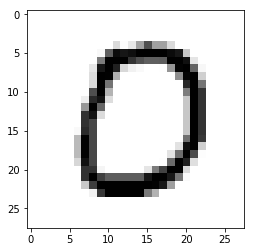

In [10]:
# Evaluate a sample image and display it
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor

%matplotlib inline

image = eval_data[10].reshape(1,28,28,1)

predict_fn = predictor.from_saved_model(export_dir)
predictions = predict_fn(
    {"x": image})

print("Number: ", predictions['classes'][0])

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
plt.imshow(image.reshape(28, 28), cmap=plt.cm.Greys);

In [11]:
!chmod -R 777 logdir-small